# DEFAULT RISK PREDICTION — HOME CREDIT

## 1. Objective

Develop a predictive model to estimate the probability of customer default (TARGET variable) using demographic, financial, credit history, and past behavioral data. The practical goal is to enable safer credit decisions: adjusting limits, approving or rejecting applications, and prioritizing preventive collection actions, reducing losses and improving profitability.

Considering the complexity and strong class imbalance of the *Home Credit Default Risk* dataset, the model was tuned to balance precision and detection capability (recall), prioritizing the identification of customers at higher risk of default. The focus is to support safer and more proactive credit decisions, minimizing loss risk and strengthening financial portfolio management.


## 2. Executive Summary



The project aimed to **develop a predictive default risk model** to support safer and more profitable credit decisions, using the *Home Credit Default Risk* dataset, characterized by **high complexity, more than 800 variables, and strong class imbalance** (approximately **8% defaulters**).

Even in the presence of variables with **low individual correlation** with default risk, the application of statistical and *machine learning* techniques made it possible to **combine multiple weak signals into a robust and interpretable model**, capable of consistently estimating the probability of default.

---

**1. Business Challenge**

The central need was to **reduce financial losses from default** without compromising the experience and conversion of good customers.
The main challenges were:

* Identifying **high-risk customers in advance**;
* Reducing the impact of **false negatives** (defaulters not detected);
* Controlling the volume of **false positives** and their operational costs;
* Ensuring **scalability** in an environment with hundreds of variables.

---

**2. Developed Solution**

A **binary classification model** was built and trained using a wide set of demographic, socioeconomic, behavioral, and credit history variables, totaling **more than 800 features**.

The model was calibrated with an **optimal threshold of 0.191 (based on F1-score ≈ 0.344)**, prioritizing the **capture of defaulters** without excessive loss of good customers, making it suitable for **risk screening and prevention stages**.

Main patterns identified:

* Employment stability and consistent financial history reduce risk;
* High volume of credit inquiries and recent financial decisions increase risk;
* Recent behavioral changes are strong indicators of instability;
* The **combination of multiple variables** proved essential for predictive performance.

---

**3. Performance and Results**

| Metric                 | Result   |
| ---------------------- | -------- |
| Recall (Defaulters)    | **38%**  |
| Precision (Defaulters) | **31%**  |
| AUC-ROC                | **0.80** |
| MCC                    | **0.28** |
| Overall Accuracy       | **88%**  |

The model demonstrated **good discriminatory power**, especially considering the strong class imbalance and high dimensionality of the data.

---

**4. Financial Impact**

Based on realistic simulations (46,127 customers, average loss of **R$ 5,000** per defaulter and an average preventive action cost of **R$ 500**), the estimated impact was:

| Scenario                    | Estimated Net Profit |
| --------------------------- | -------------------- |
| **Without model**           | **R$ 23.78 million** |
| **With model (th = 0.191)** | **R$ 30.17 million** |

**Estimated incremental gain:** approximately **R$ 6.39 million**.

This result shows that the model generates **direct financial value**, even after considering losses from false positives and operational costs.

---

**5. Conclusion**

The model achieved its primary objective: **reducing default risk and increasing portfolio profitability** in a measurable way.

The project demonstrated that, even in a scenario of **high complexity, more than 800 variables, and strong class imbalance**, it is possible to build solutions that are:

* Robust,
* Interpretable,
* Scalable,
* Financially advantageous.

In summary, the work reinforces that **data science applied to credit risk management** not only improves technical metrics but also **generates real and sustainable business impact**.


## 3. About the Data


The data used in this analysis refer to the financial, demographic, and behavioral history of customers from the **Home Credit Default Risk** dataset, which contains detailed information on thousands of individuals with different socioeconomic profiles.

Currently, credit decision-making depends on multiple factors, such as loan history, repayment capacity, property characteristics, employment status, and social behavior patterns. This complexity and variability make manual decisions inconsistent, justifying the application of Data Science and Machine Learning techniques to support default risk assessment and proactive customer portfolio management.


## 4. Getting Started

### 4.1 Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import recall_score, precision_score, f1_score, roc_auc_score, average_precision_score, classification_report, confusion_matrix, matthews_corrcoef
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical
import lightgbm as lgb
from imblearn.ensemble import BalancedRandomForestClassifier
from catboost import CatBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.base import clone
from sklearn.ensemble import AdaBoostClassifier, HistGradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
import shap
from sklearn.preprocessing import PolynomialFeatures



### 4.2 Style Import

In [2]:
plt.style.use('../styles/personalestilo.mplstyle')


Bad key axes.color_cycle in file ../styles/personalestilo.mplstyle, line 9 ('axes.color_cycle: df691b, 5cb85c, 5bc0de, f0ad4e, d9534f, 4e5d6c')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.10.6/lib/matplotlib/mpl-data/matplotlibrc
or from the matplotlib source distribution


### 4.3 Additional Functions

In [2]:
def snake_case(lst):
    def convert(s):
        s = s.replace(' ', '_')
        new_s = ""
        for i, c in enumerate(s):
            if c.isupper():
                if i > 0 and (s[i-1].islower() or (i+1 < len(s) and s[i+1].islower())):
                    new_s += "_"
                new_s += c.lower()
            else:
                new_s += c
        return new_s
    return [convert(s) for s in lst]

def agg_numeric(df, key, prefix):
    df_num = df.select_dtypes(include=[np.number])

    df_num[key] = df[key]


    agg = df_num.groupby(key).agg(['mean', 'max', 'min', 'count'])

    agg.columns = [prefix + "_" + "_".join(col) for col in agg.columns]

    return agg

def plot_numeric_block(df_block, bins=30, color='orange', rows=3, figsize=(18, 12)):
    plt.figure(figsize=figsize)
    cols = df_block.columns
    n_cols = int(np.ceil(len(cols) / rows))
    for i, col in enumerate(cols, 1):
        plt.subplot(rows, n_cols, i)
        sns.histplot(df_block[col], kde=True, color=color, bins=bins)
        plt.title(col)
        plt.xlabel(col)
        plt.ylabel('Frequência')
    plt.tight_layout()
    plt.show()


def plot_target_by_categorical(df, cat_col, target_col='target', suptitle=None):
    categorias = df[cat_col].unique()
    categorias = [str(c) for c in categorias]
    n_categorias = len(categorias)
    n_linhas = (n_categorias // 3) + (1 if n_categorias % 3 != 0 else 0)
    n_linhas = max(n_linhas, 1)
    ncols = 3 if n_categorias > 1 else 1

    fig, axes = plt.subplots(n_linhas, ncols, figsize=(7 * ncols, 5 * n_linhas))
    axes = np.array(axes).reshape(-1)

    palette_target = {'0': "orange", '1': "red"}

    for ax in axes[n_categorias:]:
        ax.axis('off')

    for i, categoria in enumerate(categorias):
        data_plot = df[df[cat_col] == categoria].copy()
        data_plot['target_str'] = data_plot[target_col].astype(str)
        sns.countplot(
            data=data_plot,
            x='target_str',
            hue='target_str',
            palette=palette_target,
            order=['0', '1'],
            ax=axes[i],
            legend=False
        )
        axes[i].set_title(f"{cat_col}: {categoria}")
        axes[i].set_xlabel(target_col)
        axes[i].set_ylabel('Frequência')
        axes[i].set_xticks([0, 1])
        axes[i].set_xticklabels(['Não Inadimplente (0)', 'Inadimplente (1)'])

    if suptitle is None:
        suptitle = f'Frequência de {target_col} por categoria de {cat_col}'
    plt.suptitle(suptitle)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

def find_best_threshold(y_true, y_proba, metric="f1"):
    thresholds = np.linspace(0, 1, 200)

    best_t = 0.5
    best_score = -1

    for t in thresholds:
        y_pred = (y_proba >= t).astype(int)

        if metric == "f1":
            score = f1_score(y_true, y_pred)
        elif metric == "mcc":
            score = matthews_corrcoef(y_true, y_pred)
        elif metric == "recall":
            score = recall_score(y_true, y_pred)
        elif metric == "precision":
            score = precision_score(y_true, y_pred)
        elif metric == "f2":
            score = fbeta_score(y_true, y_pred, beta=2)
        elif metric == "f05":
            score = fbeta_score(y_true, y_pred, beta=0.5)
        else:
            raise ValueError("Métrica inválida.")

        if score > best_score:
            best_score = score
            best_t = t

    return best_t, best_score


def get_fold(X, idx): 
    return X.iloc[idx] if hasattr(X, "iloc") else X[idx]

def get_model_clone(name, model):
    if "cat" in name:
        return CatBoostClassifier(**model.get_params())
    elif "xgb" in name:
        return xgb.XGBClassifier(**model.get_params())
    elif "lgbm" in name:
        return lgb.LGBMClassifier(**model.get_params())
    else:
        return clone(model)



def plot_binaria_target(
    df,
    var_binaria,
    target='target',
    label_0='Não Possui',
    label_1='Possui',
    suptitle=None
):
    flags = [0, 1]
    palette_target = {'0': "orange", '1': "red"}

    fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=False)
    for i, flag in enumerate(flags):
        data_plot = df[df[var_binaria] == flag].copy()
        data_plot['target_str'] = data_plot[target].astype(str)
        sns.countplot(
            data=data_plot,
            x='target_str',
            hue='target_str',
            palette=palette_target,
            order=['0', '1'],
            ax=axes[i],
            legend=False
        )
        label = label_0 if flag == 0 else label_1
        axes[i].set_title(f"{label}")
        axes[i].set_xlabel('Resposta')
        axes[i].set_ylabel('Frequência')
        axes[i].set_xticks([0, 1])
        axes[i].set_xticklabels(['Não Inadimplente (0)', 'Inadimplente (1)'])

    if suptitle is None:
        suptitle = f'Frequência de {target} por {var_binaria}'
    plt.suptitle(suptitle)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


def plot_num_var_by_target(
    df,
    num_var,
    target_var='target',
    title_0=None,
    title_1=None,
    label_x=None,
    color_0='blue',
    color_1='orange',
    figsize=(10, 8),
    discrete=False
):
    fig, axes = plt.subplots(2, 1, figsize=figsize, sharey=False)

    sns.histplot(
        data=df[df[target_var] == 0],
        x=num_var,
        color=color_0,
        ax=axes[0],
        discrete=discrete
    )
    axes[0].set_title(title_0 or f'Distribuição de {num_var} (Sem Inadimplência)')
    axes[0].set_ylabel('Frequência')
    axes[0].set_xlabel(label_x or num_var)

    sns.histplot(
        data=df[df[target_var] == 1],
        x=num_var,
        color=color_1,
        ax=axes[1],
        discrete=discrete
    )
    axes[1].set_title(title_1 or f'Distribuição de {num_var} (Inadimplentes)')
    axes[1].set_ylabel('Frequência')
    axes[1].set_xlabel(label_x or num_var)

    plt.tight_layout()
    plt.show()


def calcular_cramers_v(df, col1, col2):
    contingency_table = pd.crosstab(df[col1], df[col2])
    chi2_stat, p, dof, expected = chi2_contingency(contingency_table)
    n = contingency_table.sum().sum()
    min_dim = min(contingency_table.shape) - 1
    cramers_v = np.sqrt(chi2_stat / (n * min_dim)) if min_dim > 0 else np.nan
    print(f"V de Cramer entre {col1} e {col2}: {cramers_v:.4f}")


def avaliar_metricas(modelo, X_val, y_val, X_test, y_test):
    def obter_prob(modelo, X):
        if hasattr(modelo, "predict_proba"):
            probas = modelo.predict_proba(X)
            return probas[:, 1]
        elif hasattr(modelo, "predict"):
            if isinstance(X, (pd.DataFrame, pd.Series, np.ndarray)):
                dmatrix = xgb.DMatrix(X)
            else:
                dmatrix = X
            probas = modelo.predict(dmatrix)
            return probas
        else:
            raise ValueError("O modelo precisa implementar predict_proba ou ser booster do xgboost.")

    y_val_prob = obter_prob(modelo, X_val)
    y_test_prob = obter_prob(modelo, X_test)

    y_val_pred = (y_val_prob >= 0.5).astype(int)
    y_test_pred = (y_test_prob >= 0.5).astype(int)

    metrics = {
        'recall': [
            recall_score(y_val, y_val_pred),
            recall_score(y_test, y_test_pred)
        ],
        'precision': [
            precision_score(y_val, y_val_pred),
            precision_score(y_test, y_test_pred)
        ],
        'f1_score': [
            f1_score(y_val, y_val_pred),
            f1_score(y_test, y_test_pred)
        ],
        'auc_roc': [
            roc_auc_score(y_val, y_val_prob),
            roc_auc_score(y_test, y_test_prob)
        ],
        'auc_pr': [
            average_precision_score(y_val, y_val_prob),
            average_precision_score(y_test, y_test_prob)
        ]
    }
    df_metrics = pd.DataFrame(metrics, index=['validacao', 'teste']).T
    return df_metrics


def income_stability(row):
    low_income_types = ['Unemployed', 'Student', 'Maternity leave', 'Pensioner']
    high_income_types = ['State servant', 'Businessman', 'Civil servant']
    stable_occupations = [
        'Accountants', 'Core staff', 'HR staff', 'High skill tech staff', 'Managers', 'Medicine staff',
        'Private service staff', 'Secretaries', 'Officials', 'IT staff'
    ]
    unstable_occupations = [
        'Laborers', 'Low-skill Laborers', 'Cleaning staff', 'Waiters/barmen staff', 'Security staff'
    ]
    inc_type = str(row['name_income_type'])
    occ_type = str(row['occupation_type'])
    days_employed = abs(row['days_employed']) if not pd.isnull(row['days_employed']) else 0

    if (inc_type in low_income_types) or (occ_type in unstable_occupations) or (days_employed < 365):
        return 0 
    elif (inc_type in high_income_types) or (occ_type in stable_occupations and days_employed >= 5*365):
        return 2  
    else:
        return 1  





### 4.4 Loading the Data

In [4]:
app_train = pd.read_csv('../data/application_train.csv')
app_test = pd.read_csv('../data/application_test.csv')

In [5]:
bureau = pd.read_csv('../data/bureau.csv')
bureau.name = "bureau"

bureau_balance = pd.read_csv('../data/bureau_balance.csv')
bureau_balance.name = "bb"

prev = pd.read_csv('../data/previous_application.csv')
prev.name = "prev"

pos = pd.read_csv('../data/POS_CASH_balance.csv')
pos.name = "pos"

cc = pd.read_csv('../data/credit_card_balance.csv')
cc.name = "cc"

inst = pd.read_csv('../data/installments_payments.csv')
inst.name = "inst"

In [6]:
bb_agg = agg_numeric(bureau_balance, 'SK_ID_BUREAU', 'bb')
bureau = bureau.merge(bb_agg, on='SK_ID_BUREAU', how='left')

bureau_agg = agg_numeric(bureau, 'SK_ID_CURR', 'bur')

prev_agg = agg_numeric(prev, 'SK_ID_CURR', 'prev')

pos_agg = agg_numeric(pos, 'SK_ID_PREV', 'pos')

prev_pos = prev[['SK_ID_CURR','SK_ID_PREV']].merge(pos_agg, on='SK_ID_PREV', how='left')
pos_final = agg_numeric(prev_pos, 'SK_ID_CURR', 'posf')

cc_agg = agg_numeric(cc, 'SK_ID_PREV', 'cc')

prev_cc = prev[['SK_ID_CURR','SK_ID_PREV']].merge(cc_agg, on='SK_ID_PREV', how='left')
cc_final = agg_numeric(prev_cc, 'SK_ID_CURR', 'ccf')

inst_agg = agg_numeric(inst, 'SK_ID_PREV', 'inst')

prev_inst = prev[['SK_ID_CURR','SK_ID_PREV']].merge(inst_agg, on='SK_ID_PREV', how='left')
inst_final = agg_numeric(prev_inst, 'SK_ID_CURR', 'instf')

df = app_train.copy()
df_test = app_test.copy()

for auxiliary in [bureau_agg, prev_agg, pos_final, cc_final, inst_final]:
    df = df.merge(auxiliary, on='SK_ID_CURR', how='left')
    df_test = df_test.merge(auxiliary, on='SK_ID_CURR', how='left')


In [31]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [8]:
df.to_csv('../data/train.csv', index=False)
df_test.to_csv('../data/test.csv', index=False)


## 5. Data Description

In [ ]:
df1 = df.copy()

### 5.1 Renaming Columns

In [4]:
cols_old = list(df1.columns)

cols_old = list(df1.columns)

cols_new = snake_case(cols_old)

df1.columns = cols_new

In [5]:
for idx, (col, dtype) in enumerate(df1.dtypes.items(), 1):
    print(f'{idx} - {col}: {dtype}')


1 - sk_id_curr: int64
2 - target: int64
3 - name_contract_type: object
4 - code_gender: object
5 - flag_own_car: object
6 - flag_own_realty: object
7 - cnt_children: int64
8 - amt_income_total: float64
9 - amt_credit: float64
10 - amt_annuity: float64
11 - amt_goods_price: float64
12 - name_type_suite: object
13 - name_income_type: object
14 - name_education_type: object
15 - name_family_status: object
16 - name_housing_type: object
17 - region_population_relative: float64
18 - days_birth: int64
19 - days_employed: int64
20 - days_registration: float64
21 - days_id_publish: int64
22 - own_car_age: float64
23 - flag_mobil: int64
24 - flag_emp_phone: int64
25 - flag_work_phone: int64
26 - flag_cont_mobile: int64
27 - flag_phone: int64
28 - flag_email: int64
29 - occupation_type: object
30 - cnt_fam_members: float64
31 - region_rating_client: int64
32 - region_rating_client_w_city: int64
33 - weekday_appr_process_start: object
34 - hour_appr_process_start: int64
35 - reg_region_not_live_r

In [6]:
df1 = df1.drop(columns=['sk_id_curr'])

### 5.2 Data Dimensions

In [7]:
print('Número de linhas:', df1.shape[0])
print('Número de colunas:', df1.shape[1])

Número de linhas: 307511
Número de colunas: 825


### 5.3 Data Types

In [8]:
for idx, (col, dtype) in enumerate(df1.dtypes.items(), 1):
    print(f'{idx} - {col}: {dtype}')


1 - target: int64
2 - name_contract_type: object
3 - code_gender: object
4 - flag_own_car: object
5 - flag_own_realty: object
6 - cnt_children: int64
7 - amt_income_total: float64
8 - amt_credit: float64
9 - amt_annuity: float64
10 - amt_goods_price: float64
11 - name_type_suite: object
12 - name_income_type: object
13 - name_education_type: object
14 - name_family_status: object
15 - name_housing_type: object
16 - region_population_relative: float64
17 - days_birth: int64
18 - days_employed: int64
19 - days_registration: float64
20 - days_id_publish: int64
21 - own_car_age: float64
22 - flag_mobil: int64
23 - flag_emp_phone: int64
24 - flag_work_phone: int64
25 - flag_cont_mobile: int64
26 - flag_phone: int64
27 - flag_email: int64
28 - occupation_type: object
29 - cnt_fam_members: float64
30 - region_rating_client: int64
31 - region_rating_client_w_city: int64
32 - weekday_appr_process_start: object
33 - hour_appr_process_start: int64
34 - reg_region_not_live_region: int64
35 - reg_r

#### 5.3.1 Modifying Data Types

In [9]:
df1['flag_own_car'] = df1['flag_own_car'].map({'N': 0, 'Y': 1})
df1['flag_own_realty'] = df1['flag_own_realty'].map({'N': 0, 'Y': 1})
df1['emergencystate_mode'] = df1['emergencystate_mode'].map({'No': 0, 'Yes': 1})

weekday_map = {
    'MONDAY': 1,
    'TUESDAY': 2,
    'WEDNESDAY': 3,
    'THURSDAY': 4,
    'FRIDAY': 5,
    'SATURDAY': 6,
    'SUNDAY': 7
}

df1['weekday_appr_process_start'] = df1['weekday_appr_process_start'].map(weekday_map)

### 5.4 Checking and Filling NaN Values

In [10]:
df1 = df1.replace('XNA', pd.NA)

print(df1.isna().sum().to_string())

target                                                0
name_contract_type                                    0
code_gender                                           4
flag_own_car                                          0
flag_own_realty                                       0
cnt_children                                          0
amt_income_total                                      0
amt_credit                                            0
amt_annuity                                          12
amt_goods_price                                     278
name_type_suite                                    1292
name_income_type                                      0
name_education_type                                   0
name_family_status                                    0
name_housing_type                                     0
region_population_relative                            0
days_birth                                            0
days_employed                                   

#### 5.4.1 Filling Missing Values

In [11]:

aux_missing_cols = {}


aux_missing_cols['is_building']          = df1.filter(like='commonarea_').notna().any(axis=1).astype(int)
aux_missing_cols['is_building_missing']  = (~df1.filter(like='commonarea_').notna().any(axis=1)).astype(int)
aux_missing_cols['has_basement']         = df1['basementarea_avg'].notna().astype(int)
aux_missing_cols['basementarea_missing'] = df1['basementarea_avg'].isna().astype(int)
aux_missing_cols['has_noliving']         = df1['nonlivingarea_avg'].notna().astype(int)
aux_missing_cols['nonlivingarea_missing']= df1['nonlivingarea_avg'].isna().astype(int)
aux_missing_cols['is_employed']          = (~df1['days_employed'].isna()).astype(int)

aux_missing_cols['livingarea_missing']    = df1['livingarea_avg'].isna().astype(int)
aux_missing_cols['apartments_missing']    = df1['apartments_avg'].isna().astype(int)
aux_missing_cols['floorsmax_missing']     = df1['floorsmax_avg'].isna().astype(int)
aux_missing_cols['years_build_missing']   = df1['years_build_avg'].isna().astype(int)
aux_missing_cols['commonarea_missing']    = df1['commonarea_avg'].isna().astype(int)

aux_missing_cols['emergencystate_missing']= df1['emergencystate_mode'].isna().astype(int)
df1['emergencystate_mode']               = df1['emergencystate_mode'].fillna(0)
for col in ['elevators_avg', 'elevators_mode', 'elevators_medi']:
    aux_missing_cols[col + "_missing"] = df1[col].isna().astype(int)
    df1[col] = df1[col].fillna(0)


cols_moda = [
    'housetype_mode', 'wallsmaterial_mode', 'occupation_type', 'organization_type'
]
for col in cols_moda:
    aux_missing_cols[col + '_missing'] = df1[col].isna().astype(int)

df1['housetype_mode']      = df1['housetype_mode'].fillna('Unknown')
df1['wallsmaterial_mode']  = df1['wallsmaterial_mode'].fillna('Unknown')
df1['occupation_type']     = df1['occupation_type'].fillna('Other')
df1['organization_type']   = df1['organization_type'].fillna('Unknown')

drop_columns = {
    'fondkapremont_mode', 'landarea_mode', 'landarea_medi', 
    'livingarea_mode', 'livingarea_medi',
    'entrances_avg', 'entrances_mode', 'entrances_medi', 
    'floorsmax_mode', 'floorsmax_medi', 
    'apartments_mode', 'apartments_medi', 'years_build_mode','years_build_medi'
}

do_not_drop = {
    'livingarea_avg', 'apartments_avg', 'floorsmax_avg', 'years_build_avg', 
    'basementarea_avg', 'nonlivingarea_avg', 'livingapartments_missing', 
    'own_car_age', 'years_beginexpluatation_avg','commonarea_avg', 'nonlivingapartments_avg', 'livingapartments_avg', 'nonlivingapartments_missing', 'commonarea_missing', 'basementarea_missing', 'nonlivingarea_missing', 'years_beginexpluatation_missing'
}

prefixes = (
    'nonlivingapartments_','livingapartments_','floorsmin_','commonarea_','basementarea_', 
    'nonlivingarea_','years_beginexpluatation_'
)

cols_to_drop = [
    col for col in df1.columns 
    if ((col.startswith(prefixes) and col not in do_not_drop) or col in drop_columns)
]

df1 = df1.drop(columns=cols_to_drop)



In [12]:

aux_missing_cols['name_type_suite_missing'] = df1['name_type_suite'].isna().astype(int)
mode_suite = df1["name_type_suite"].mode()[0]
df1["name_type_suite"] = df1["name_type_suite"].fillna(mode_suite)

aux_missing_cols['code_gender_missing'] = df1['code_gender'].isna().astype(int)
mode_gender = df1["code_gender"].mode()[0]
df1["code_gender"] = df1["code_gender"].fillna(mode_gender)

cols_nan_remanescentes = df1.columns[df1.isnull().any()]
df_mediana = pd.DataFrame(columns=['coluna', 'mediana'])
medianas = []
for col_nome in cols_nan_remanescentes:
    aux_missing_cols[col_nome + '_missing'] = df1[col_nome].isna().astype(int)
    mediana = df1[col_nome].median()
    medianas.append({'coluna': col_nome, 'mediana': mediana})
    df1[col_nome] = df1[col_nome].fillna(mediana)
df_mediana = pd.DataFrame(medianas)


In [13]:
df1 = pd.concat([df1, pd.DataFrame(aux_missing_cols, index=df1.index)], axis=1)
df1 = df1.copy()


#### 5.4.2 Checking Missing Values After Modifications

In [14]:
print(df1.isna().sum().to_string())

target                                                   0
name_contract_type                                       0
code_gender                                              0
flag_own_car                                             0
flag_own_realty                                          0
cnt_children                                             0
amt_income_total                                         0
amt_credit                                               0
amt_annuity                                              0
amt_goods_price                                          0
name_type_suite                                          0
name_income_type                                         0
name_education_type                                      0
name_family_status                                       0
name_housing_type                                        0
region_population_relative                               0
days_birth                                              

## 6. Feature Engineering

In [ ]:
df2 = df1.copy()

### 6.1 List of Hypotheses

#### Block 1 - (1 a 20)

**H1** — Contract type influences the probability of default.

It is expected that customers with Revolving loans present higher risk, as these are short-term credits with higher interest rates.

**H2** — Gender is associated with default risk.

Differences in financial behavior between men and women may be reflected in payment rates.

**H3** — Customers who own a car have a lower probability of default.

Vehicle ownership may indicate greater financial stability.

**H4** — Owning a home reduces the chance of default.

Ownership of a fixed asset may reflect financial security and a stronger credit history.

**H5** — The number of children influences default risk.

Larger families tend to have higher fixed expenses, which may increase the probability of late payments.

**H6** — Higher total income is associated with lower default risk.

Customers with greater financial capacity have more margin to honor their debts.

**H7** — Higher credit amounts are related to higher default risk.

Larger loans may overload the budget, especially for lower-income customers.

**H8** — Higher monthly installments increase the chance of default.

High payments may compromise the customer's cash flow.

**H9** — The value of goods purchased influences default risk.

High-value purchases may indicate higher indebtedness and greater financial risk.

**H10** — The type of accompaniment when applying for credit is associated with default risk.

Customers who apply alone (Unaccompanied) may have different financial behavior than couples or families.



#### Block 2 - (21 a 40)

**H21** — Having a work phone registered reduces the risk of default.

A validated employment link may indicate professional stability and more reliable income.

**H22** — Customers with a work phone provided are less likely to default.

This information tends to be provided by formally employed workers, reflecting better economic stability.

**H23** — Having a registered mobile phone is associated with lower default risk.

It indicates greater ease of communication and follow-up by the lender.

**H24** — Having a landline phone registered reduces default risk.

It may be associated with fixed residences and greater social stability.

**H25** — Customers with a registered email tend to present lower default risk.

It indicates a higher level of formalization, digital access, and ease of communication for collections or notifications.

**H26** — Occupation type influences default risk.

Self-employed and temporary workers tend to have more unstable income, increasing risk compared to formally employed or public servants.

**H27** — The number of family members is positively related to default risk.

Larger families imply higher fixed expenses and lower financial margin for payments.

**H28** — Customers from regions with lower ratings have a higher probability of default.

Regional ratings may reflect socioeconomic conditions and access to credit in the area.

**H29** — The customer's city rating influences default risk.

Urban regions with worse economic indicators may concentrate customers with higher financial risk.

**H30** — The day of the week when the credit application is made influences the probability of default.

Applications made on weekdays (especially early in the week) may come from more organized profiles than those made on weekends.

**H31** — The time of credit application is associated with default.

Requests made at atypical hours (late night, early morning) may be linked to impulsive behavior or higher risk.

**H32** — Living in a region different from the registered one increases default risk.

It indicates recent mobility or registration inconsistencies, factors linked to lower reliability.

**H33** — Working in a region different from the registered one is associated with higher risk.

It may represent long commutes or job instability.

**H34** — Living and working in different regions may increase the probability of default.

Commuting may indicate additional costs and less available time, affecting financial stability.

**H35** — Living in a city different from the registered one increases the chance of default.

Differences between official and actual addresses may signal registration inconsistencies or residential instability.

**H36** — Working in a city different from the registered one increases default risk.

It indicates possible long commutes or informal employment.

**H37** — Living in a different city than the workplace influences default risk.

Long commutes can represent higher costs and lower professional stability.

**H38** — The type of employing organization is associated with default risk.

Public employees and workers in large companies tend to present lower risk compared to self-employed or small company workers.

**H39** — External score 2 is inversely related to default.

The higher the ext_source_2 value, the lower the default risk, as it indicates a better external credit assessment.

**H40** — External score 3 is inversely related to default.

High values reflect greater trustworthiness and lower credit risk according to external sources.



#### Block 3 - (41 a 72)

**H41** — The average number of elevators in a building is inversely related to the probability of default.

Properties with more elevators usually belong to higher-standard buildings, indicating better socioeconomic conditions and lower credit risk.

**H42** — Housing type influences default risk.

Customers living in owned houses or apartments tend to have lower default rates than those living in rented or third-party housing, reflecting greater asset stability.

**H43** — The main wall material of the property is associated with default risk.

More durable or higher-quality materials (such as stone or brick) tend to indicate higher-standard properties and better financial conditions.

**H44** — A higher number of observations or defaulters in the 30-day social circle increases the customer's probability of default.

Individuals inserted in social groups with higher default incidence may share similar risk profiles or economic vulnerability.

**H45** — Default in the 60-day social circle is positively associated with individual default risk.

The financial behavior of close contacts over longer periods tends to reflect social influence and similar economic conditions.

**H46** — The time since the last phone change is related to default probability.

Customers who frequently change their phone number may present greater instability or contact difficulties, increasing credit risk.

**H47** — The number of submitted documents is inversely associated with default.

Submitting more documents indicates greater transparency and compliance, while fewer documents may signal fraud risk or lower reliability.


#### Block 4 - (73 a 90)

**H48** — Credit inquiry history and credit amounts influence the probability of default.

These variables represent both the frequency of credit bureau inquiries and the average and total amounts of contracted credit. Customers who perform many bureau checks or hold large amounts of active credit tend to show higher financial exposure and, consequently, higher default risk.

**H49** — Property characteristics and employment status influence repayment capacity.

Variables related to property structure and employment situation help estimate the customer's economic and social stability.

### 6.2 Feature Derivation

In [6]:

df2['days_employed_anom'] = df2["days_employed"] == 365243
df2['days_birth'] = df2['days_birth'].abs()
df2['days_employed'] = df2['days_employed'].abs()
df2['days_id_publish'] = df2['days_id_publish'].abs()
df2['days_registration'] = df2['days_registration'].abs()
df2['age_years'] = df2['days_birth'] / 365
df2['employment_years'] = df2['days_employed'] / 365
df2['id_publish_years'] = df2['days_id_publish'] / 365

df2['annuity_burden_ratio'] = df2['amt_annuity'] / (df2['bur_amt_credit_sum_mean'] + 1e-6)
df2['phone_change_rate'] = df2['days_last_phone_change'] / (df2['days_birth'] + 1e-6)
df2['id_change_rate'] = df2['days_id_publish'] / (df2['days_birth'] + 1e-6)
df2['ext_source_weighted_mean'] = (
    0.5 * df2['ext_source_2'] + 0.3 * df2['ext_source_3'] + 0.2 * df2['ext_source_1']
)
df2['ext_source_max'] = df2[['ext_source_1', 'ext_source_2', 'ext_source_3']].max(axis=1)
df2['amt_application_credit_diff'] = df2['prev_amt_application_mean'] - df2['bur_amt_credit_sum_mean']
df2['amt_application_goods_diff'] = df2['prev_amt_application_mean'] - df2['amt_goods_price']


flag_document_cols = [col for col in df2.columns if col.startswith('flag_document_')]
df2['num_flag_document'] = df2[flag_document_cols].sum(axis=1)
df2['credit_to_income_ratio'] = df2['bur_amt_credit_sum_mean'] / (df2['amt_income_total'] + 1e-5)
df2['annuity_to_income_ratio'] = df2['amt_annuity'] / (df2['amt_income_total'] + 1e-5)
df2['payment_rate'] = df2['amt_annuity'] / (df2['bur_amt_credit_sum_mean'] + 1e-5)
df2['goods_to_credit_ratio'] = df2['bur_amt_credit_sum_mean'] / (df2['amt_goods_price'] + 1e-5)
df2['credit_efficiency'] = df2['bur_amt_credit_sum_mean'] / (df2['prev_amt_application_mean'] + 1e-5)
df2['employment_life_ratio'] = df2['days_employed'] / (df2['days_birth'])
df2['bureau_request_intensity'] = (
    df2['amt_req_credit_bureau_day'] +
    df2['amt_req_credit_bureau_week'] +
    df2['amt_req_credit_bureau_mon'] +
    df2['amt_req_credit_bureau_qrt']
)

ext_sources = ['ext_source_1', 'ext_source_2', 'ext_source_3']
df2['ext_source_mean'] = df2[ext_sources].mean(axis=1)
df2['ext_source_range'] = df2[ext_sources].max(axis=1) - df2[ext_sources].min(axis=1)
df2['ext_source_std'] = df2[ext_sources].std(axis=1)
df2['ext_source_agreement'] = 1 / (df2['ext_source_std'] + 1e-5)


df2['decision_credit_diff'] = df2['prev_days_decision_mean'] / (df2['bur_amt_credit_sum_mean'] + 1 + 1e-5)
df2['bureau_to_credit_ratio'] = df2['bureau_request_intensity'] / (df2['bur_amt_credit_sum_mean'] + 1 + 1e-5)

df2['credit_per_employment_year'] = df2['bur_amt_credit_sum_mean'] / (df2['employment_years'] + 1e-6)
df2['annuity_per_employment_year'] = df2['amt_annuity'] / (df2['employment_years'] + 1e-6)

df2['income_per_employed'] = df2['amt_income_total'] / ((df2['days_employed']+ 1e-5))
df2['income_per_birth'] = df2['amt_income_total'] / (df2['days_birth'])
df2['own_car_age_birth_ratio'] = df2['own_car_age'] / (df2['days_birth'])
df2['own_car_age_employed_ratio'] = df2['own_car_age'] / ((df2['days_employed']+ 1e-5))
df2['days_since_last_employment_until_application'] = df2['days_employed'] - df2['days_birth']

poly_vars = [
    'days_birth',
    'payment_rate',
    'ext_source_mean',
]
X_poly = df2[poly_vars].fillna(0).copy()
poly = PolynomialFeatures(degree=3, include_bias=False)
X_poly_trans = poly.fit_transform(X_poly)
poly_feature_names = poly.get_feature_names_out(poly_vars)
df_poly = pd.DataFrame(X_poly_trans, columns=poly_feature_names, index=df2.index)
df_poly = df_poly.drop(columns=poly_vars, errors='ignore')
df2 = pd.concat([df2, df_poly], axis=1)


df2['employment_stability'] = df2['employment_years'] / (df2['age_years'] + 1e-6)
df2['id_document_age_ratio'] = df2['id_publish_years'] / (df2['age_years'] + 1e-6)
df2['phone_change_frequency'] = 1 / (df2['days_last_phone_change'] + 1e-6)


df2['recent_instability'] = df2['phone_change_rate'] + df2['id_change_rate']
df2['bureau_overdue_ratio'] = df2['bur_amt_credit_max_overdue_max'] / (df2['bur_amt_credit_sum_mean'] + 1e-6)
df2['credit_risk_signal'] = df2['credit_to_income_ratio'] * ((df2['ext_source_1'] + df2['ext_source_2'] + df2['ext_source_3']) / 3)
df2['annuity_per_age'] = df2['amt_annuity'] / (df2['own_car_age'] + 1e-6)
df2["overdue_flag"] = (df2["bur_amt_credit_max_overdue_max"] > 0).astype(int)
df2["entry_vs_due_ratio"] = df2["instf_inst_days_entry_payment_mean_mean"] / (df2["prev_days_first_due_mean"]+ 1e-6)
df2["ext_source_interaction"] = df2["ext_source_1"] * df2["ext_source_3"]
df2["pos_balance_range"] = df2["posf_pos_months_balance_max_max"] - df2["bur_bb_months_balance_mean_min"]
df2["area_quality"] = df2["totalarea_mode"] / (df2["region_population_relative"] + 1e-6)


## 7. Exploratory Data Analysis

In [ ]:
df3 = df2.copy()

### 7.1 Univariate Analysis

#### 7.1.1 Target Variable

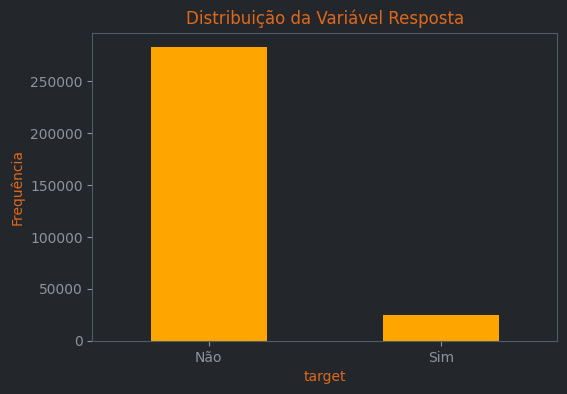

In [57]:
plt.figure(figsize=(6,4))
df3['target'].value_counts().plot(kind='bar', color='orange')
plt.title('Distribuição da Variável Resposta')
plt.xlabel('target')
plt.ylabel('Frequência')
plt.xticks([0,1], ['Não', 'Sim'], rotation=0)
plt.show()


#### 7.1.2 Numerical Variables

In [ ]:
df_numeric = df3.select_dtypes(include=['number']).drop(columns=['target'])

df_numeric_1 = df_numeric.iloc[:, 0:15]    # colunas 0 a 14  (15 colunas)
df_numeric_2 = df_numeric.iloc[:, 15:30]   # colunas 15 a 29 (15 colunas)
df_numeric_3 = df_numeric.iloc[:, 30:45]   # colunas 30 a 44 (15 colunas)
df_numeric_4 = df_numeric.iloc[:, 45:60]   # colunas 45 a 59 (15 colunas)
df_numeric_5 = df_numeric.iloc[:, 60:75]   # colunas 60 a 74 (15 colunas)

##### Block 1 - (1 a 15)

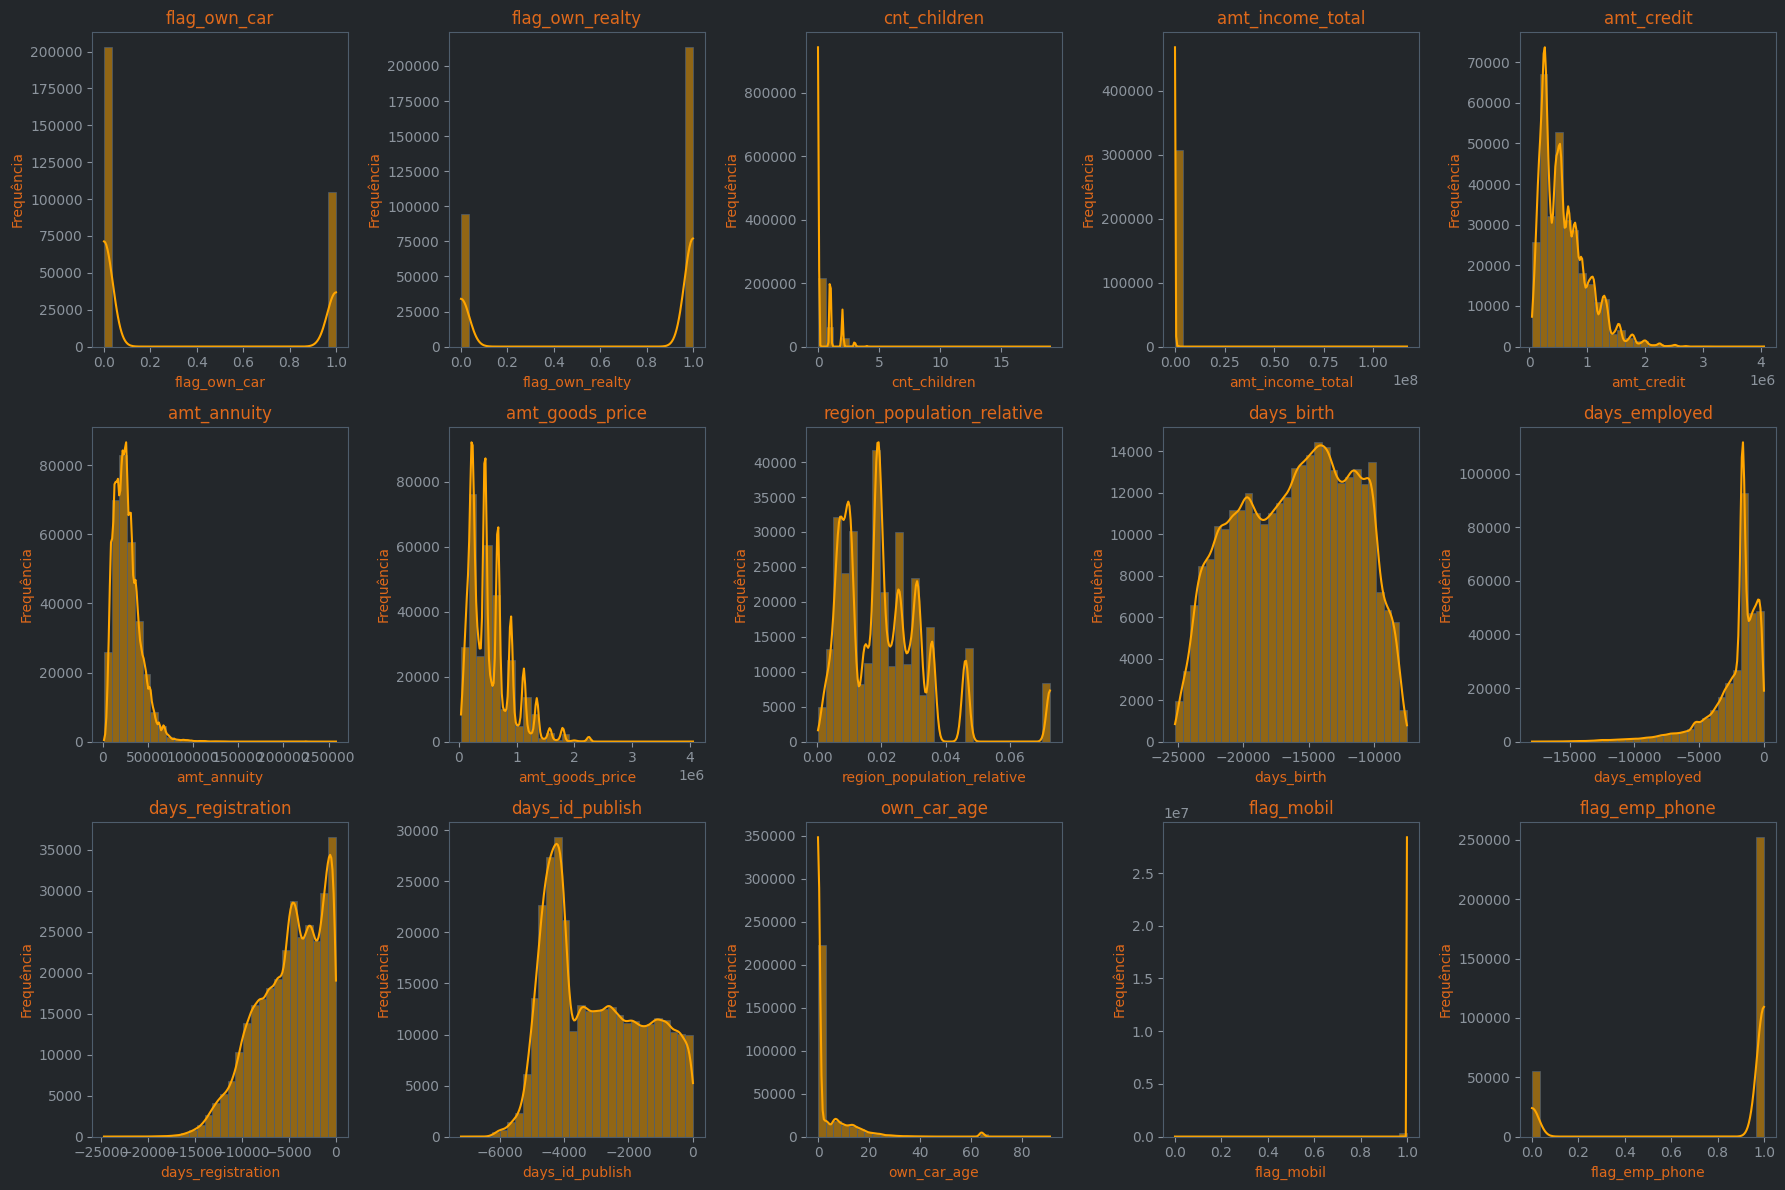

In [59]:
plot_numeric_block(df_numeric_1)

##### Block 2 - (16 a 30)

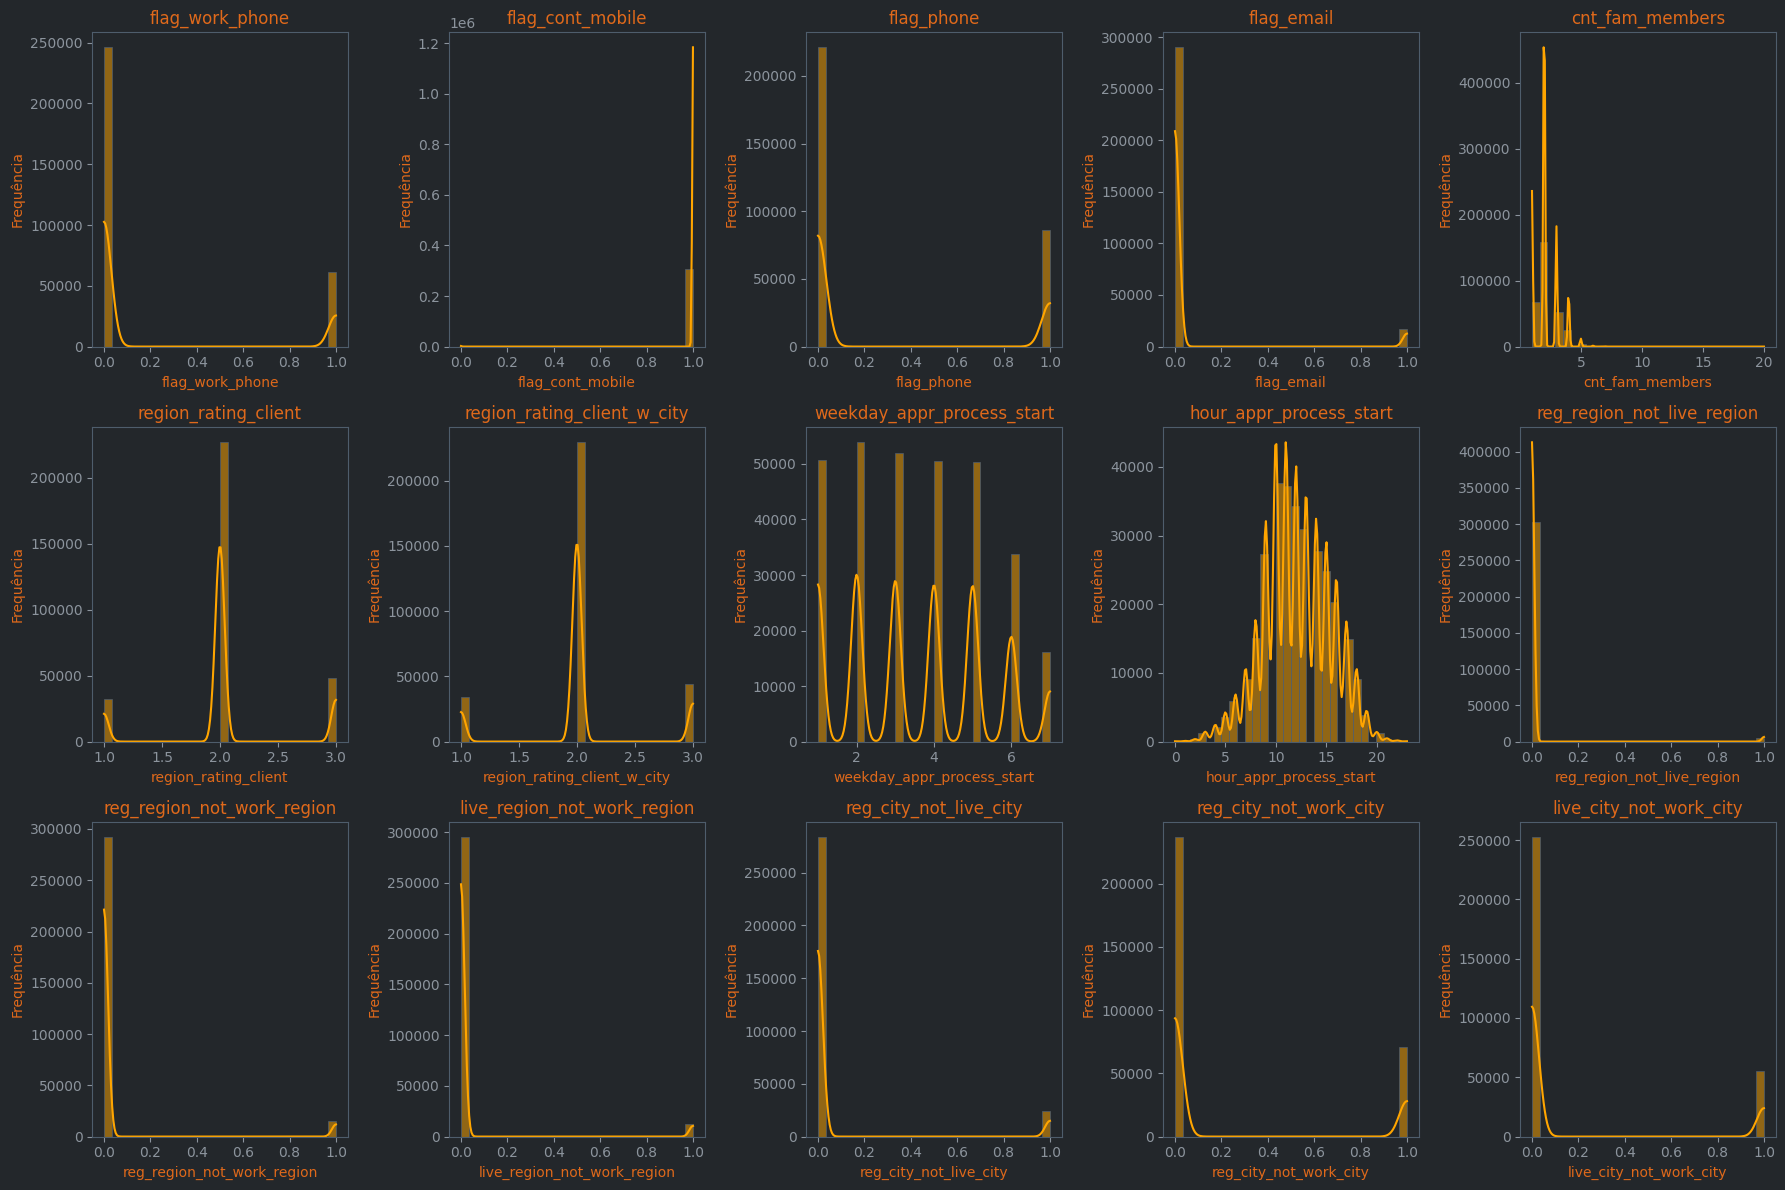

In [60]:
plot_numeric_block(df_numeric_2)

##### Block 3 - (31 a 45)

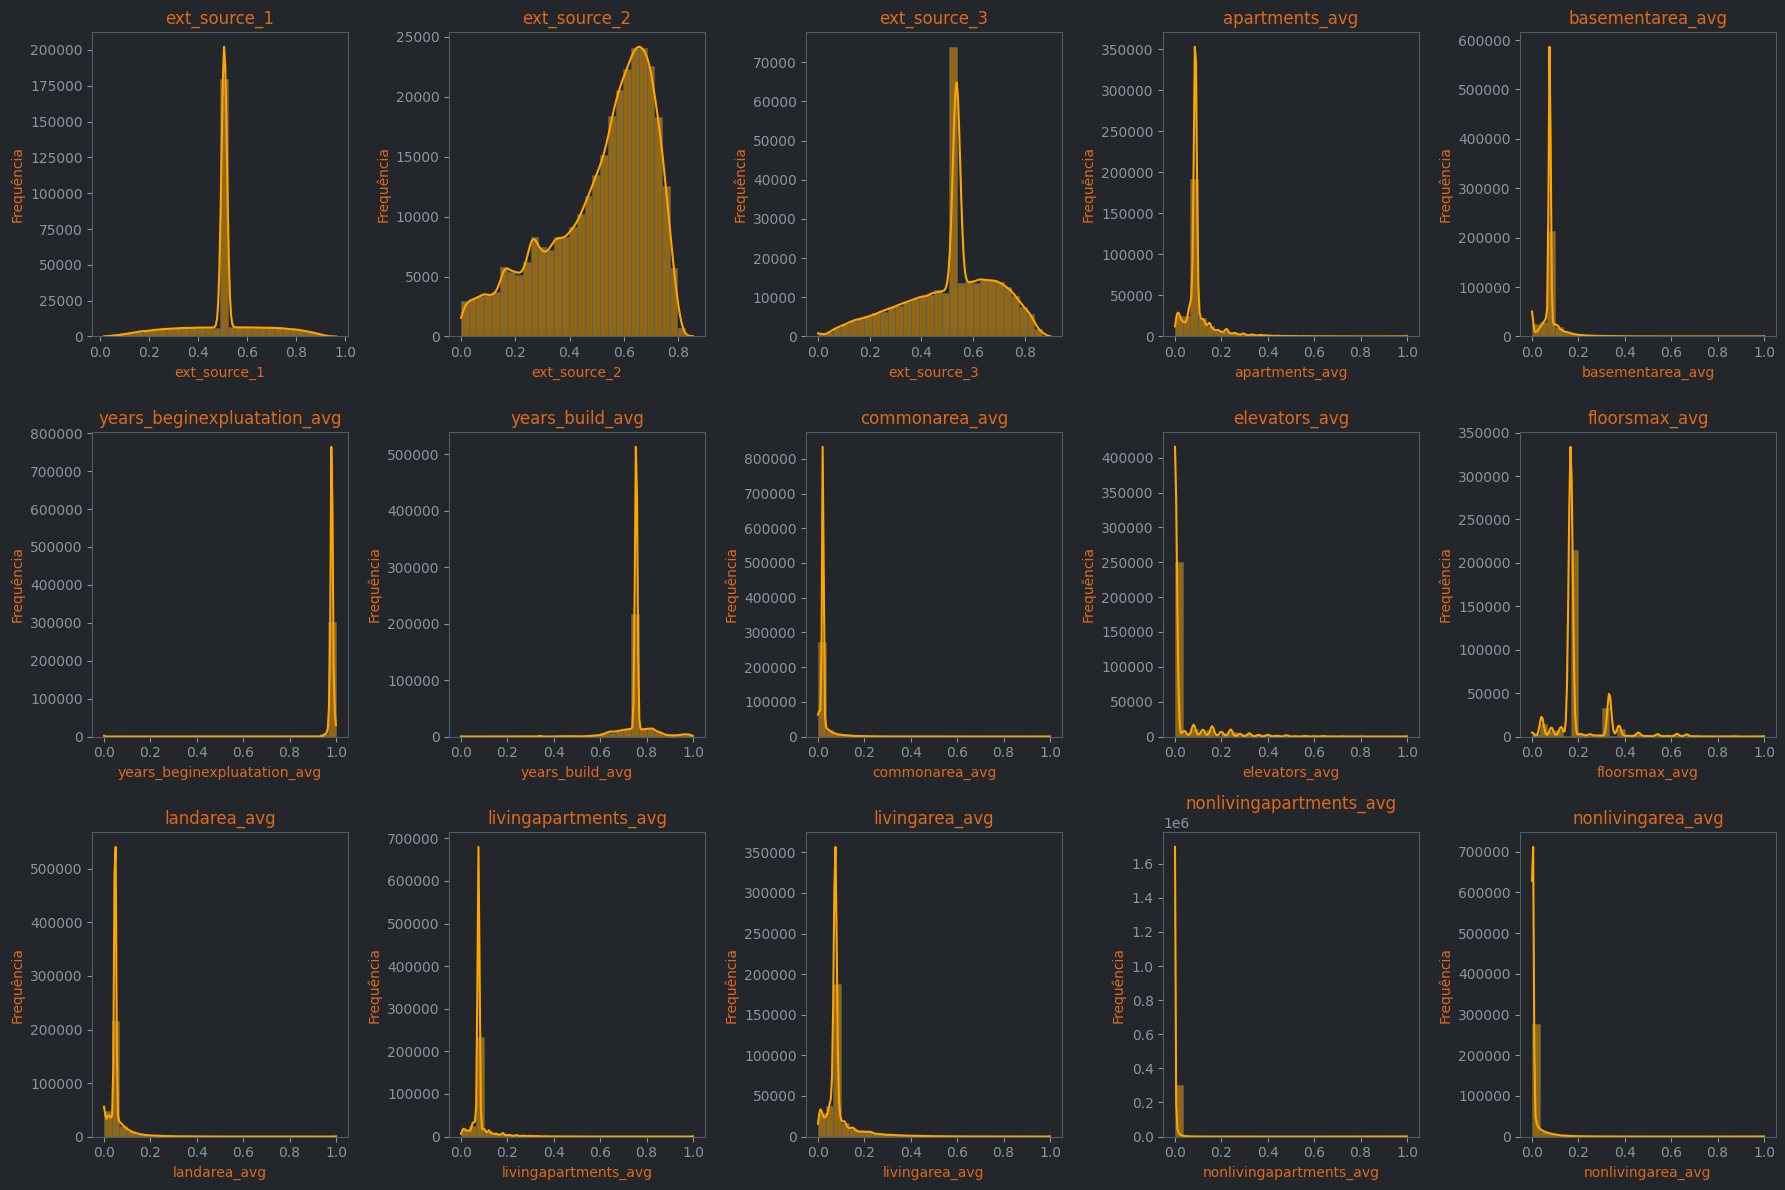

In [61]:
plot_numeric_block(df_numeric_3)

##### Block 4 - (46 a 60)

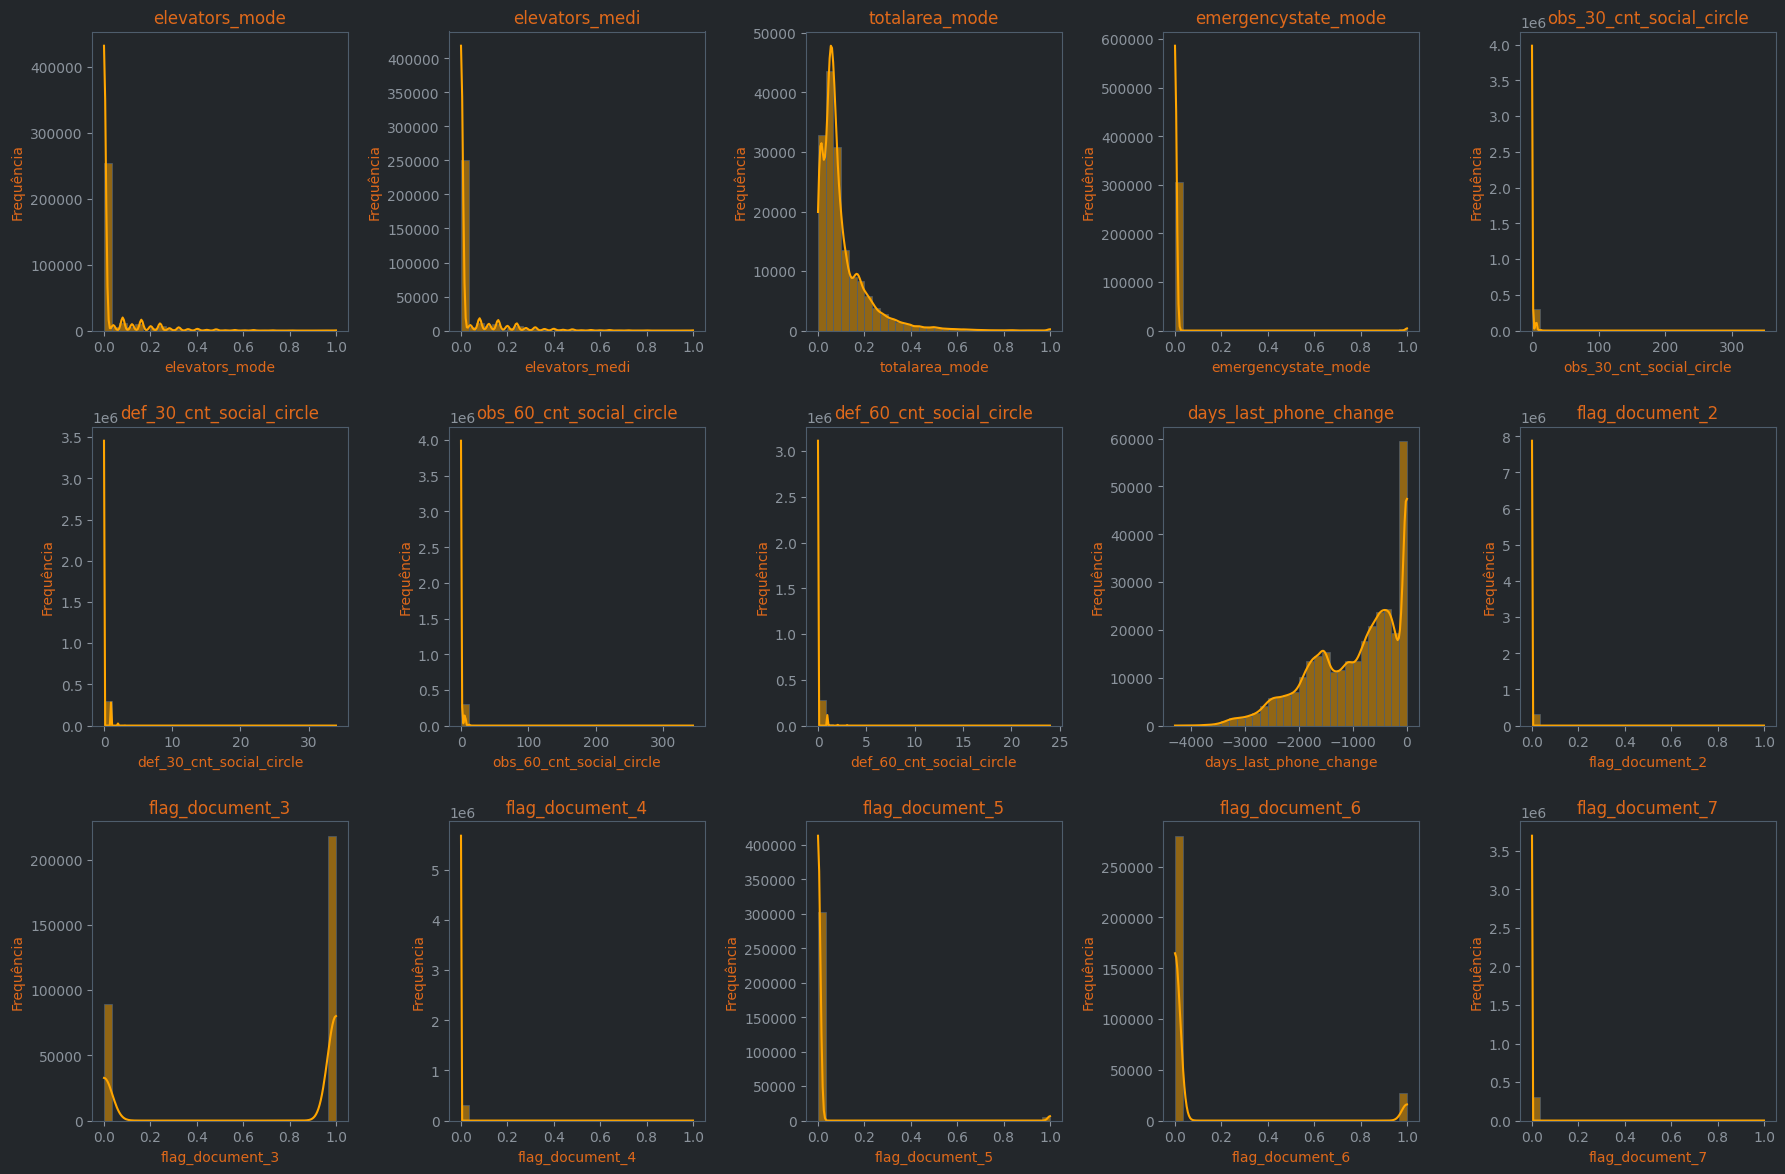

In [62]:
plot_numeric_block(df_numeric_4)

##### Block 5 - (61 a 75)

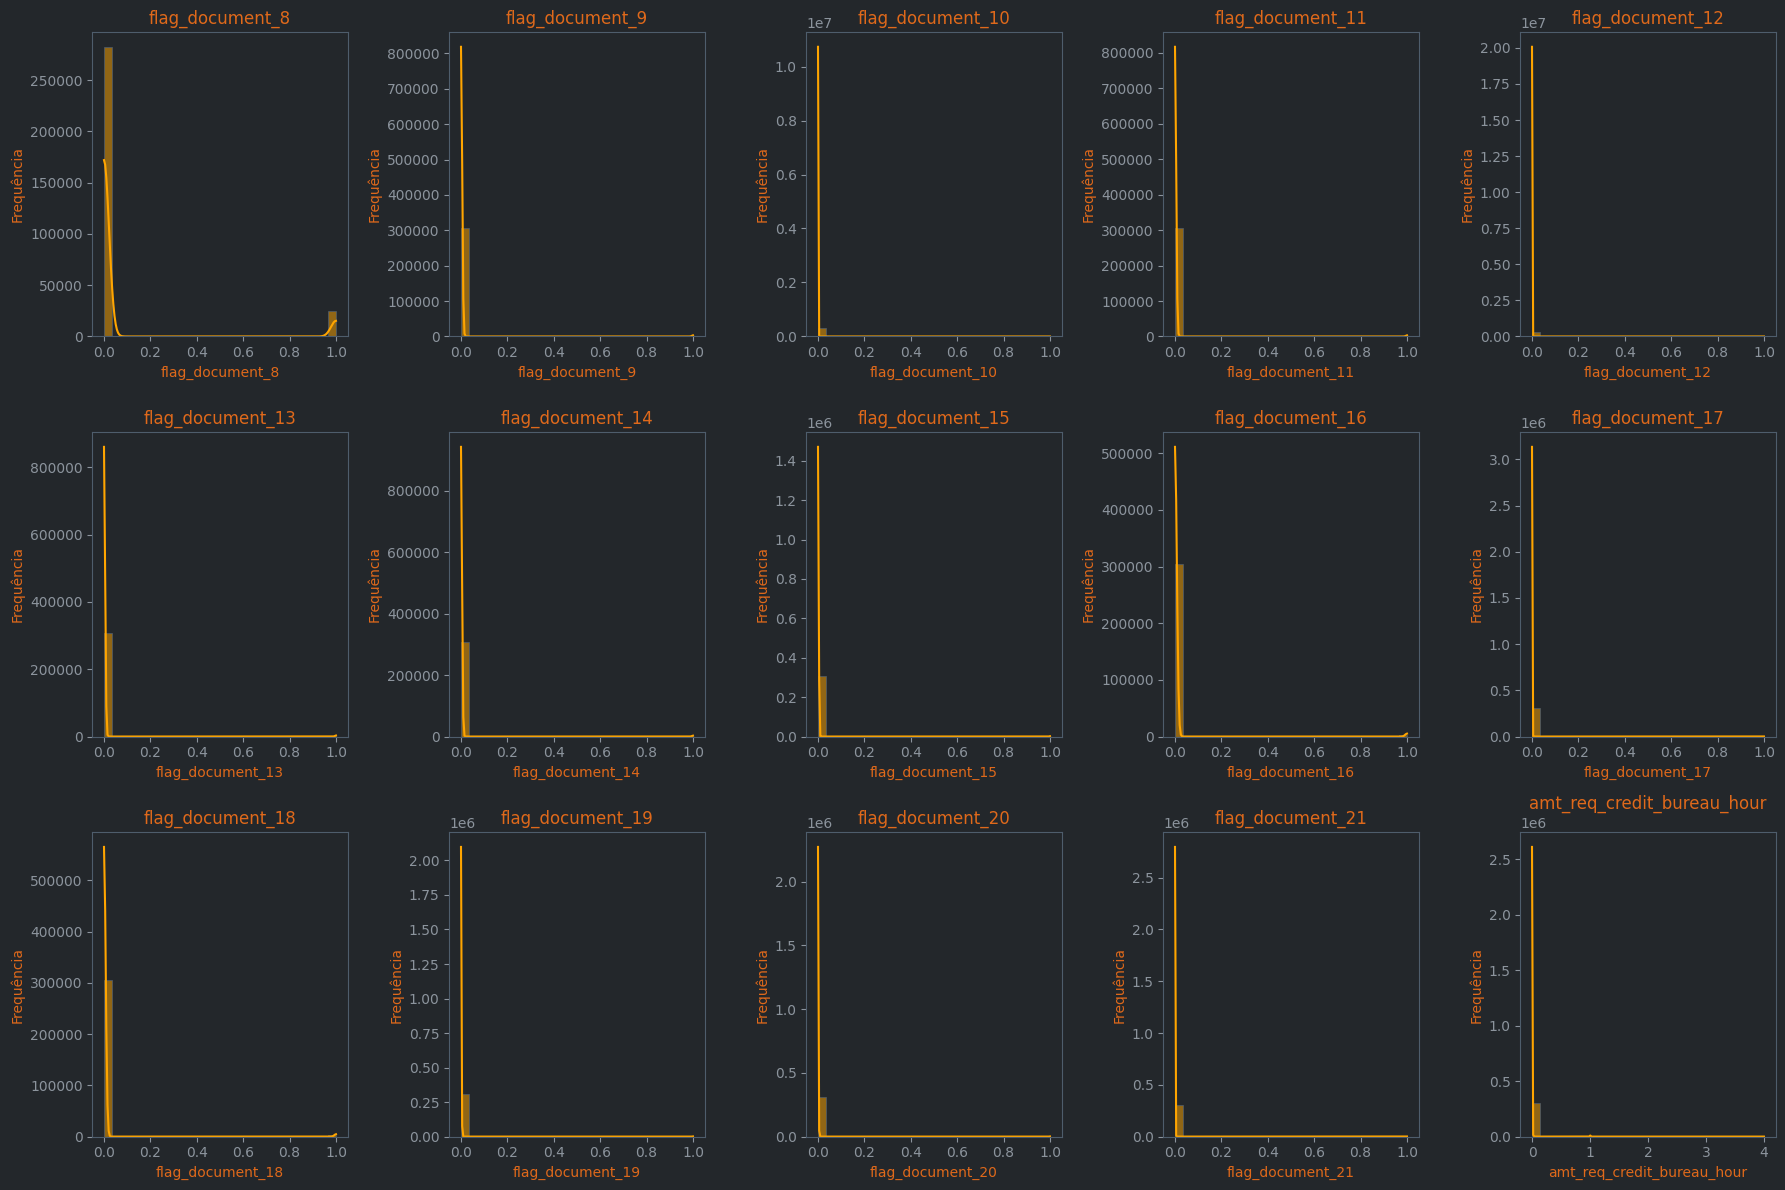

In [63]:
plot_numeric_block(df_numeric_5)

#### 7.1.3 Categorical Variables

In [66]:
df_categorical = df3.select_dtypes(include=['object', 'category'])

cat_cols = df_categorical.columns.tolist()

df_categorical_1 = df_categorical[cat_cols[:4]]
df_categorical_2 = df_categorical[cat_cols[4:8]]
df_categorical_3 = df_categorical[cat_cols[8:13]]


##### Block 1 - (1 a 4)

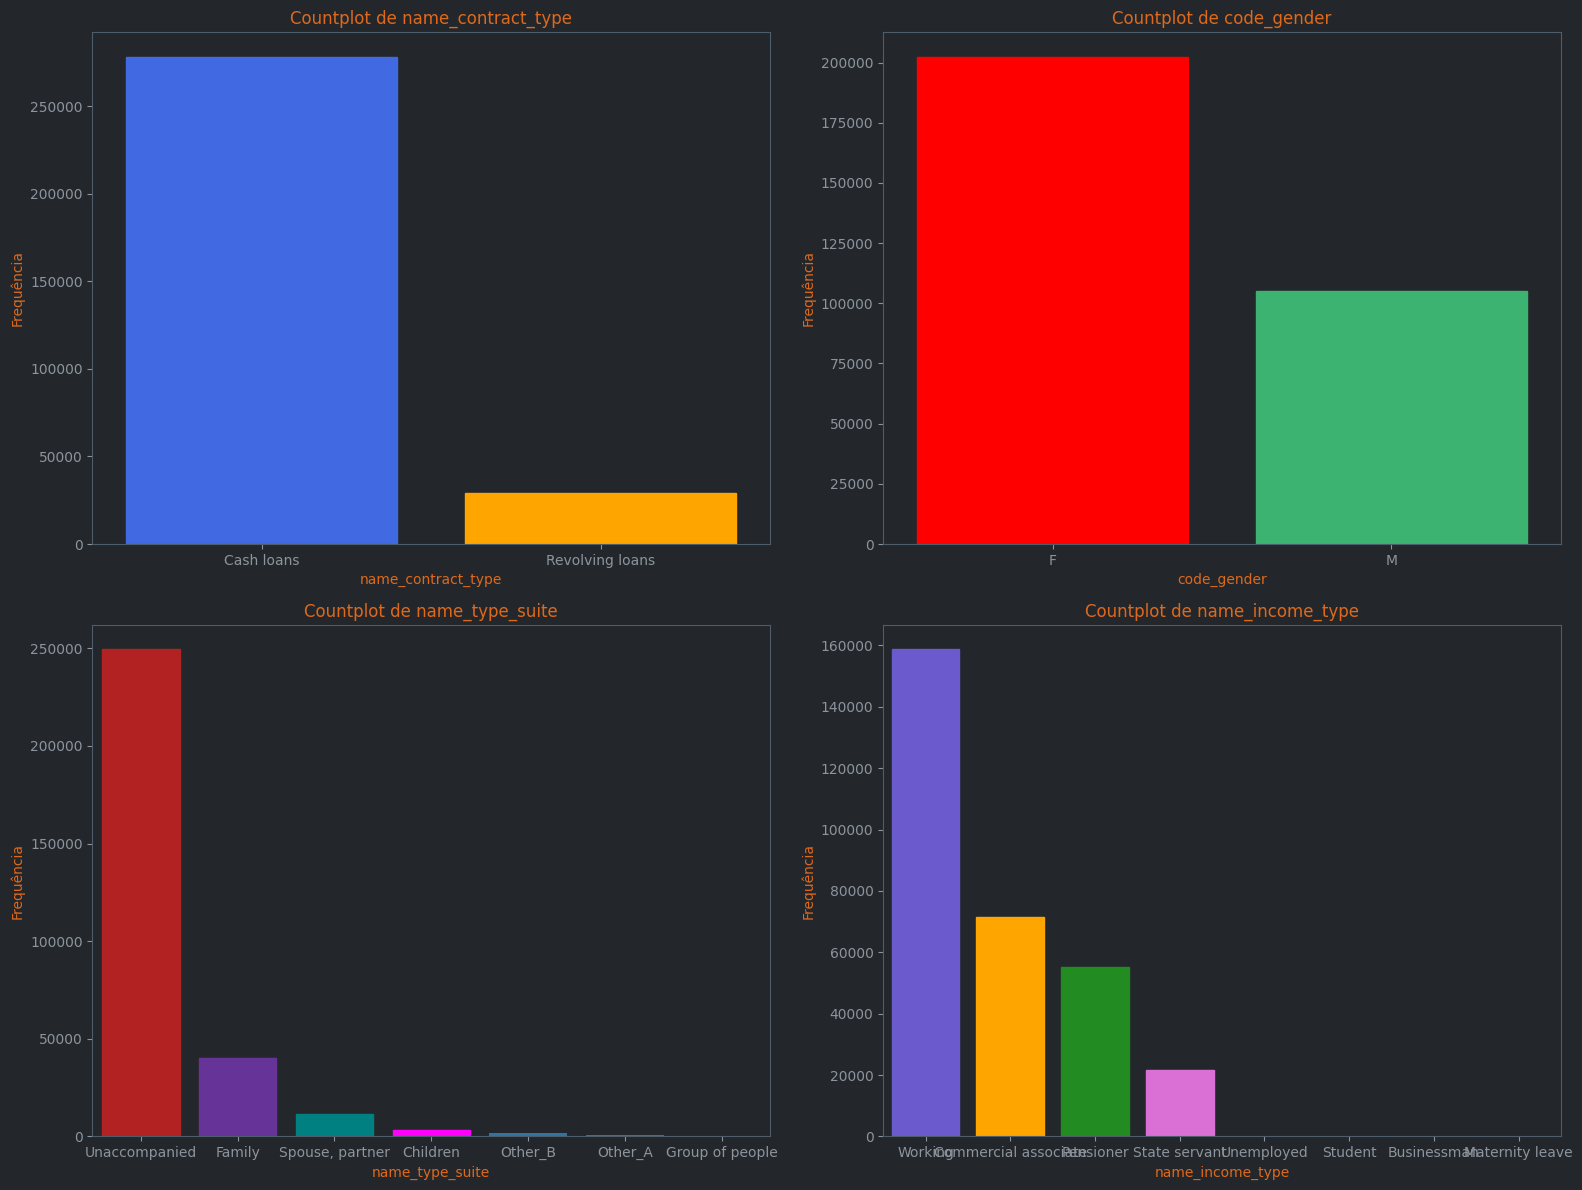

In [67]:

fig, axs = plt.subplots(2, 2, figsize=(16, 12))

categorical_columns = df_categorical_1.columns.tolist()
colors_list = [
    ['royalblue', 'orange', 'seagreen', 'crimson'],
    ['red', 'mediumseagreen', 'steelblue', 'gold'],
    ['firebrick', 'rebeccapurple', 'teal', 'magenta'],
    ['slateblue', 'orange', 'forestgreen', 'orchid']
]

for idx, col in enumerate(categorical_columns):
    row = idx // 2
    col_pos = idx % 2
    

    count_vals = df_categorical_1[col].value_counts()
    ordered_categories = count_vals.index.tolist()


    sns.countplot(
        x=col,
        data=df_categorical_1,
        ax=axs[row, col_pos],
        order=ordered_categories,
        color=None
    )
    colors = colors_list[idx] if idx < len(colors_list) else None
    for i, bar in enumerate(axs[row, col_pos].patches):
        if colors and i < len(colors):
            bar.set_color(colors[i])
    
    axs[row, col_pos].set_title(f'Countplot de {col}')
    axs[row, col_pos].set_xlabel(col)
    axs[row, col_pos].set_ylabel('Frequência')

plt.tight_layout()
plt.show()



##### Block 2 - (5 a 8)

C:\Users\Patryck\AppData\Local\Temp\ipykernel_12620\382229923.py:37: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=11)


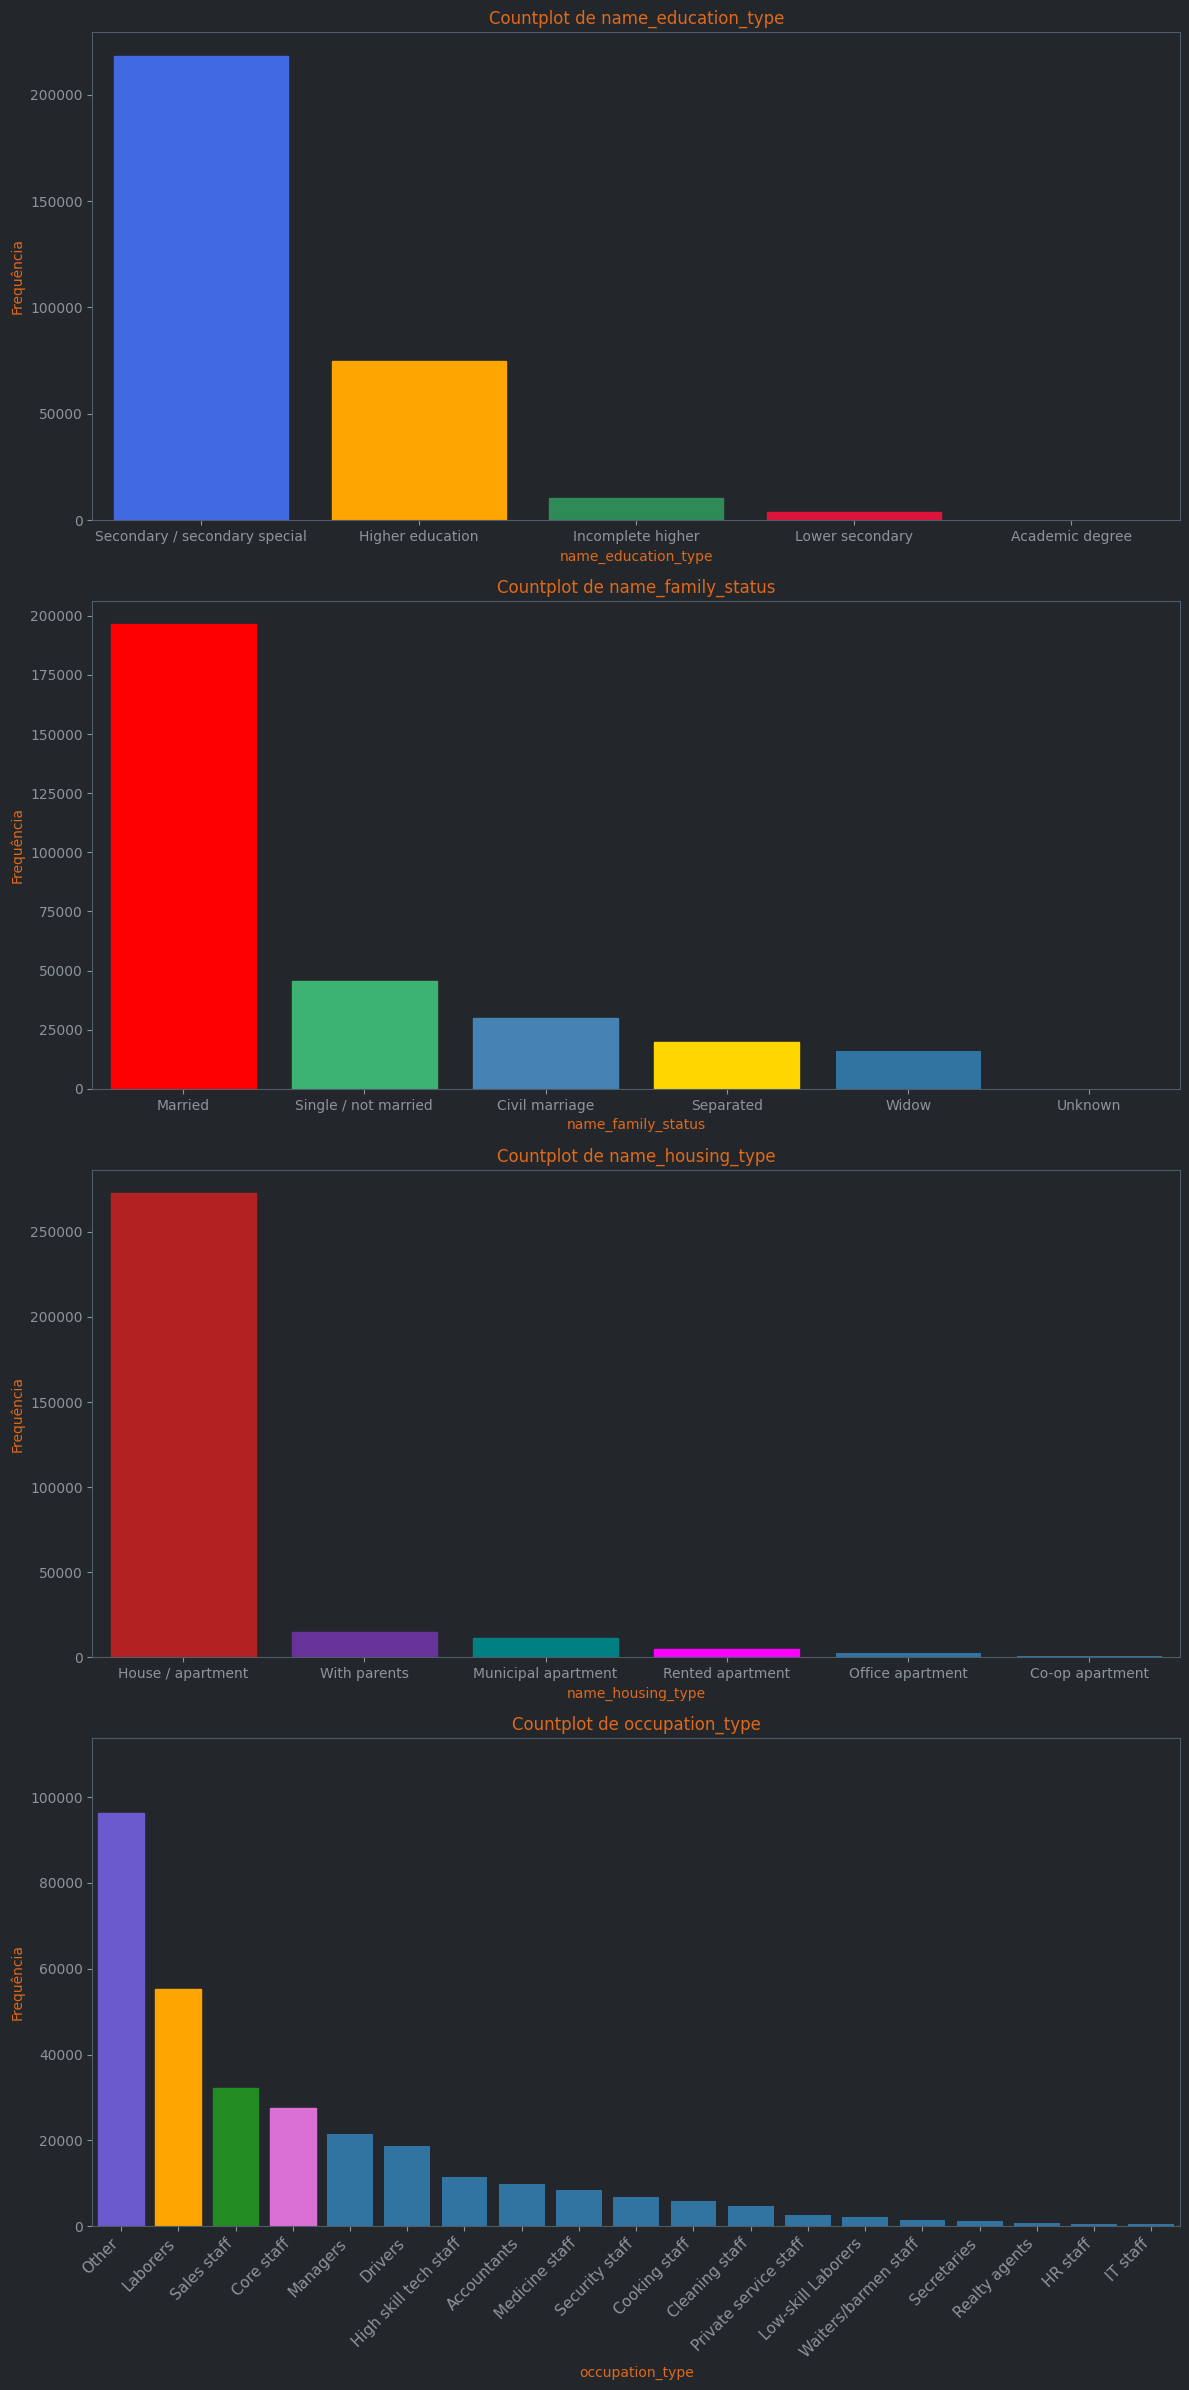

In [68]:


categorical_columns = df_categorical_2.columns.tolist() 

fig, axs = plt.subplots(len(categorical_columns), 1, figsize=(12, 24)) 
colors_list = [
    ['royalblue', 'orange', 'seagreen', 'crimson'],
    ['red', 'mediumseagreen', 'steelblue', 'gold'],
    ['firebrick', 'rebeccapurple', 'teal', 'magenta'],
    ['slateblue', 'orange', 'forestgreen', 'orchid'],  
]

if len(categorical_columns) == 1:
    axs = [axs]

for idx, col in enumerate(categorical_columns):
    ax = axs[idx]
    
    freq_order = df_categorical_2[col].value_counts().index.tolist()
    
    sns.countplot(
        x=col,
        data=df_categorical_2,
        ax=ax,
        order=freq_order,
        color=None
    )
    colors = colors_list[idx] if idx < len(colors_list) else None
    for i, bar in enumerate(ax.patches):
        if colors and i < len(colors):
            bar.set_color(colors[i])

    ax.set_title(f'Countplot de {col}')
    ax.set_xlabel(col)
    ax.set_ylabel('Frequência')


    if col.upper() == "OCCUPATION_TYPE":
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=11)
        ax.margins(y=0.18)

plt.tight_layout()
plt.show()



##### Block 3 - (8 a 13)

C:\Users\Patryck\AppData\Local\Temp\ipykernel_12620\372829898.py:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(


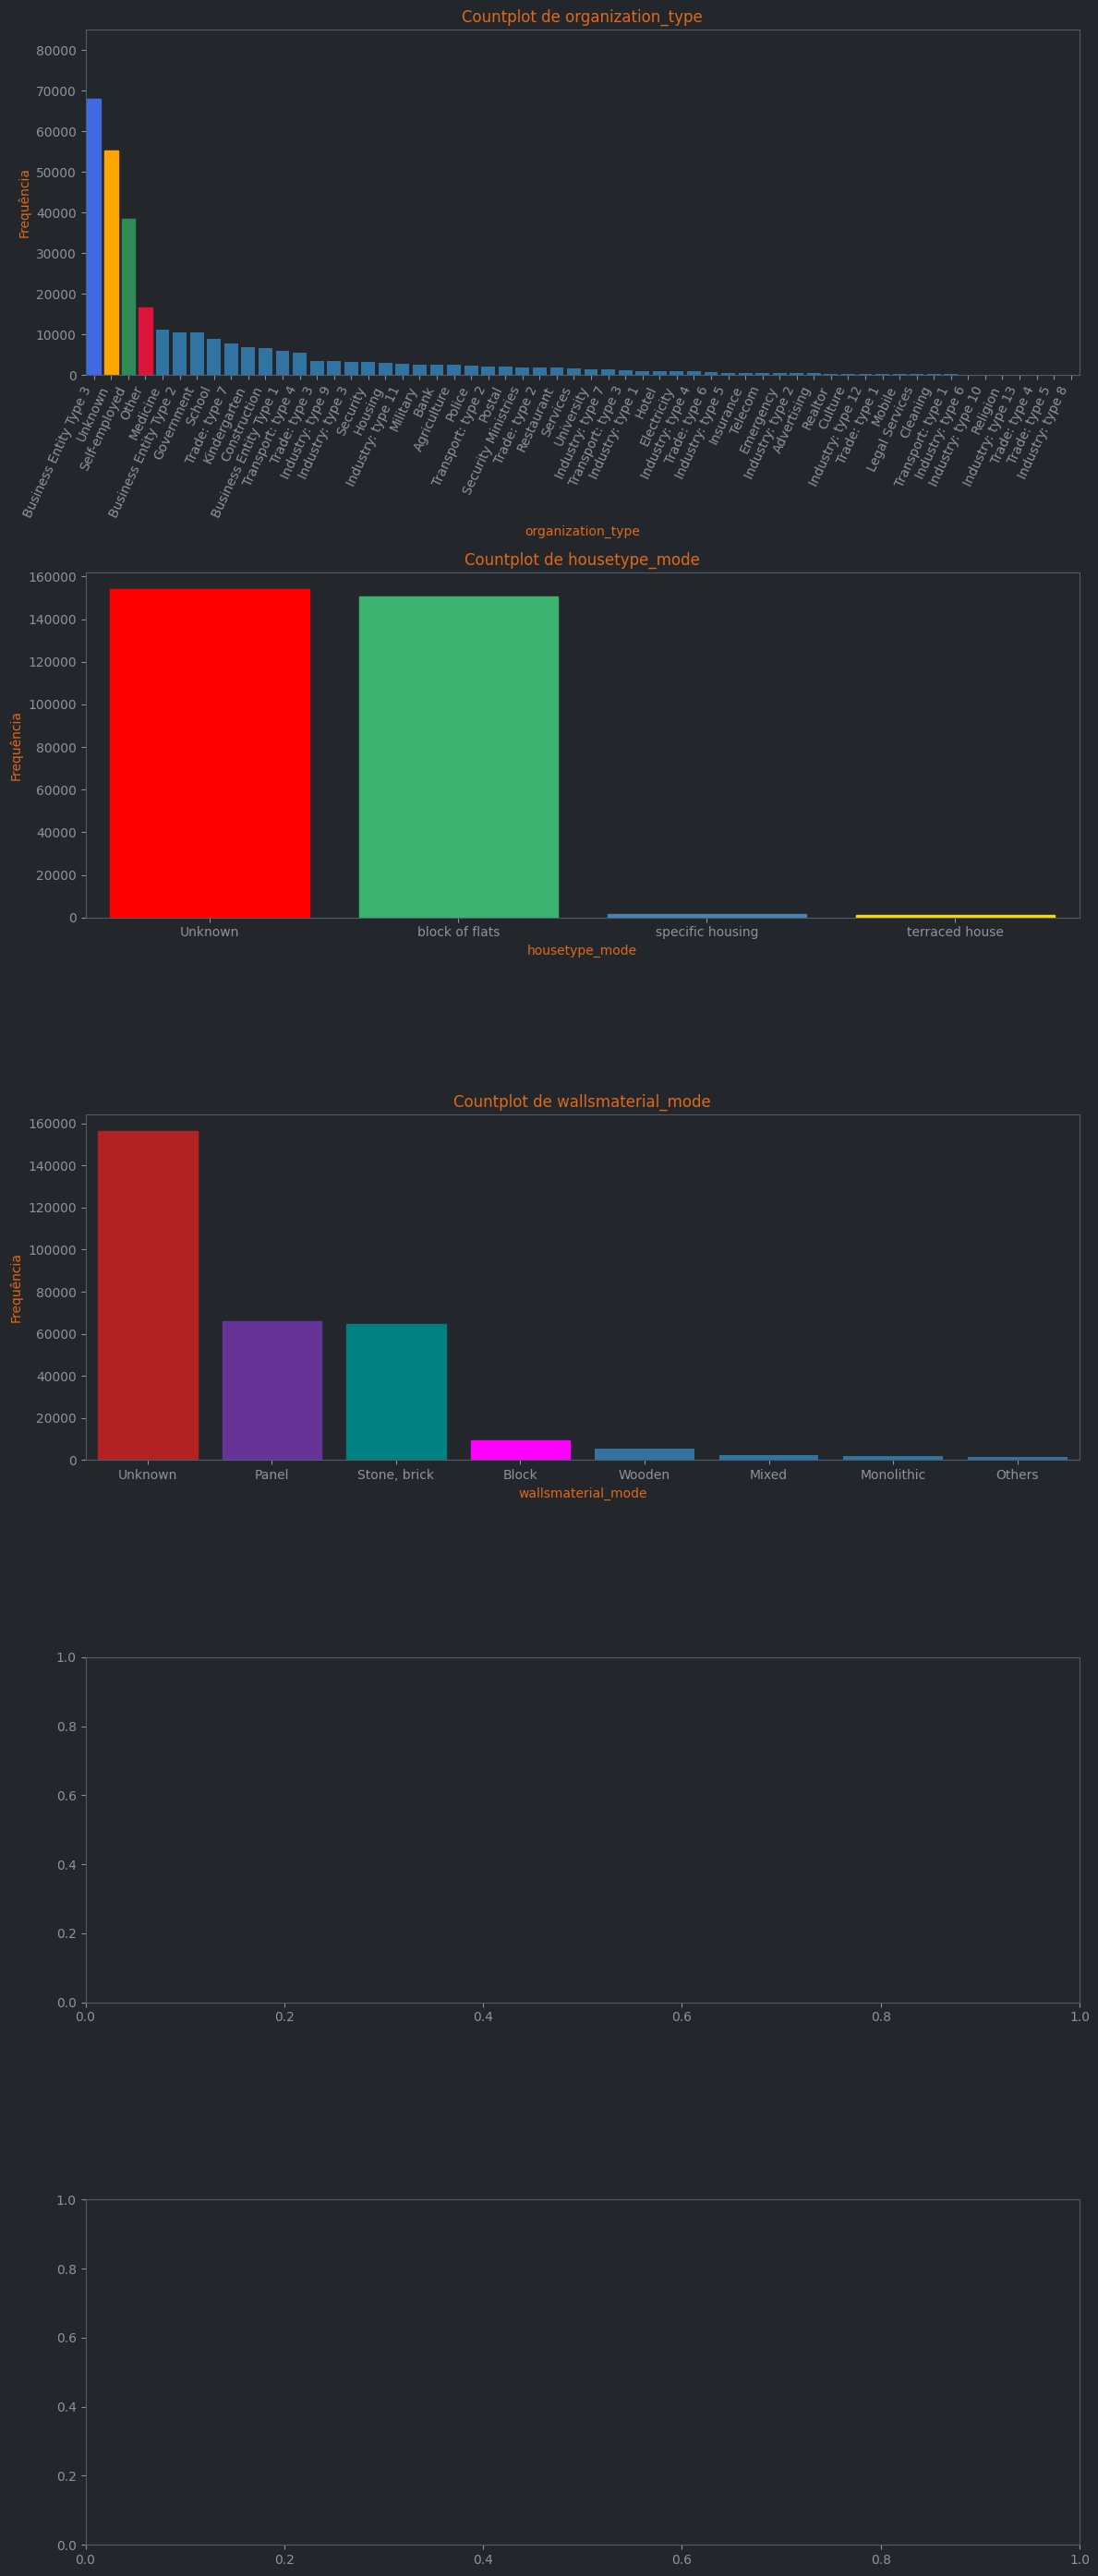

In [69]:


categorical_columns = df_categorical_3.columns.tolist()

fig, axs = plt.subplots(5, 1, figsize=(12, 28))  

colors_list = [
    ['royalblue', 'orange', 'seagreen', 'crimson'],
    ['red', 'mediumseagreen', 'steelblue', 'gold'],
    ['firebrick', 'rebeccapurple', 'teal', 'magenta'],
    ['slateblue', 'orange', 'forestgreen', 'orchid'],
    ['goldenrod', 'orchid', 'dodgerblue', 'firebrick'],  
]

for idx, col in enumerate(categorical_columns):
    ax = axs[idx]
    
    order = df_categorical_3[col].value_counts().index.tolist()
    
    sns.countplot(
        x=col,
        data=df_categorical_3,
        ax=ax,
        order=order,
        color=None
    )
    colors = colors_list[idx] if idx < len(colors_list) else None
    for i, bar in enumerate(ax.patches):
        if colors and i < len(colors):
            bar.set_color(colors[i])

    ax.set_title(f'Countplot de {col}')
    ax.set_xlabel(col)
    ax.set_ylabel('Frequência')

    if col.upper() == "ORGANIZATION_TYPE":
        ax.set_xticklabels(
            ax.get_xticklabels(),
            rotation=65,
            ha='right',
            fontsize=10
        )
        ax.margins(y=0.25)
        plt.subplots_adjust(bottom=0.38, top=0.96)

plt.tight_layout()
plt.show()


### 7.2 Bivariate Analysis

#### Block 1 Hypotesis

##### H1 — Contract type influences the probability of default. FALSE

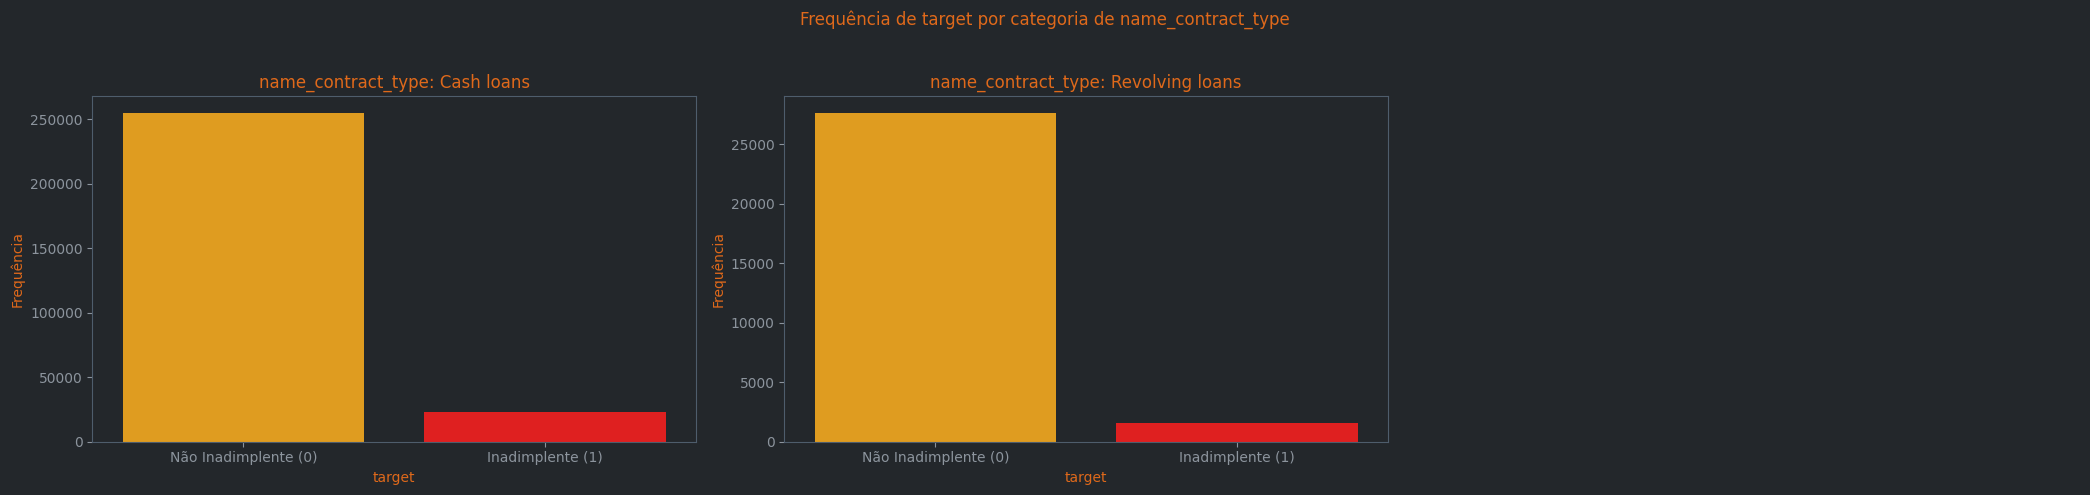

V de Cramer entre name_contract_type e target: 0.0309


In [70]:
plot_target_by_categorical(df3, cat_col='name_contract_type', target_col='target')
calcular_cramers_v(df3, 'name_contract_type', 'target')

##### H2 — Gender is associated with default risk. FALSE

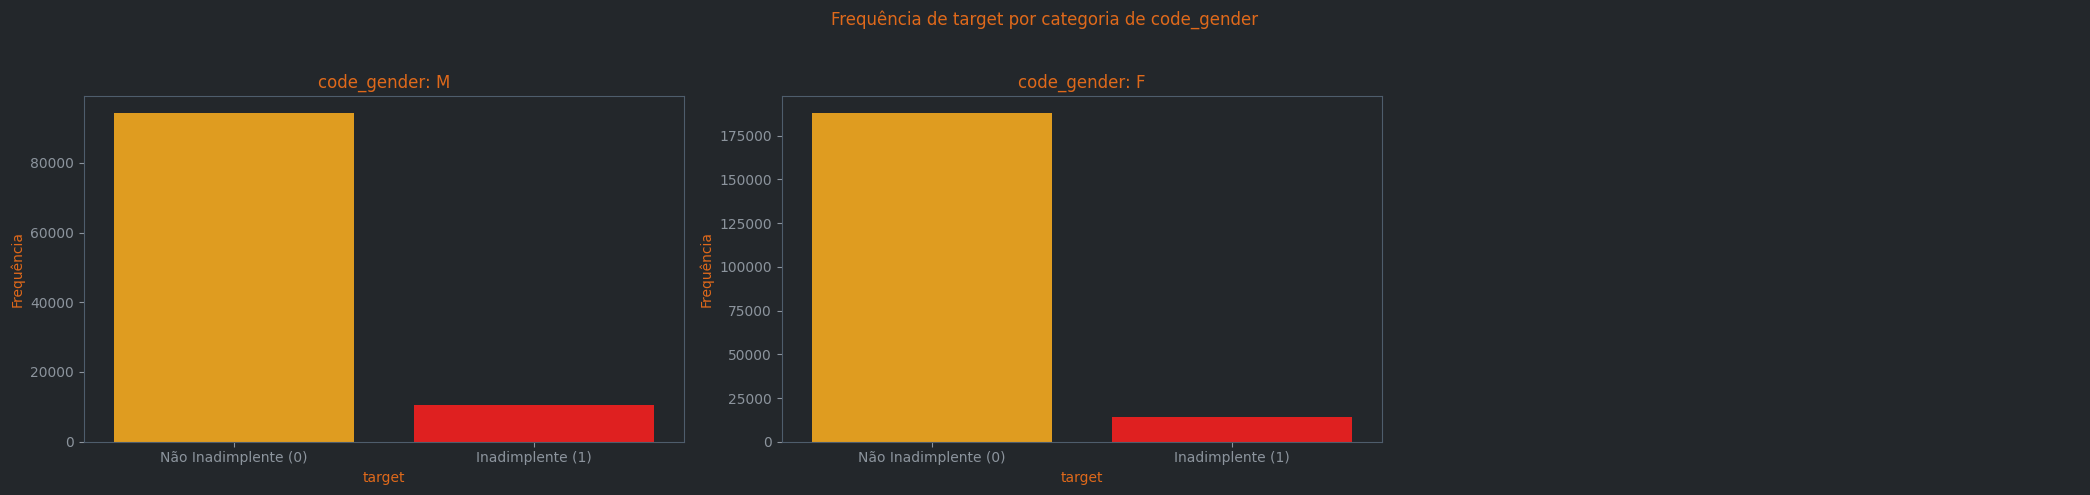

V de Cramer entre code_gender e target: 0.0547


In [71]:
plot_target_by_categorical(df3, cat_col='code_gender', target_col='target')

calcular_cramers_v(df3, 'code_gender', 'target')


##### H3 — Customers who own a car have a lower probability of default. FALSE

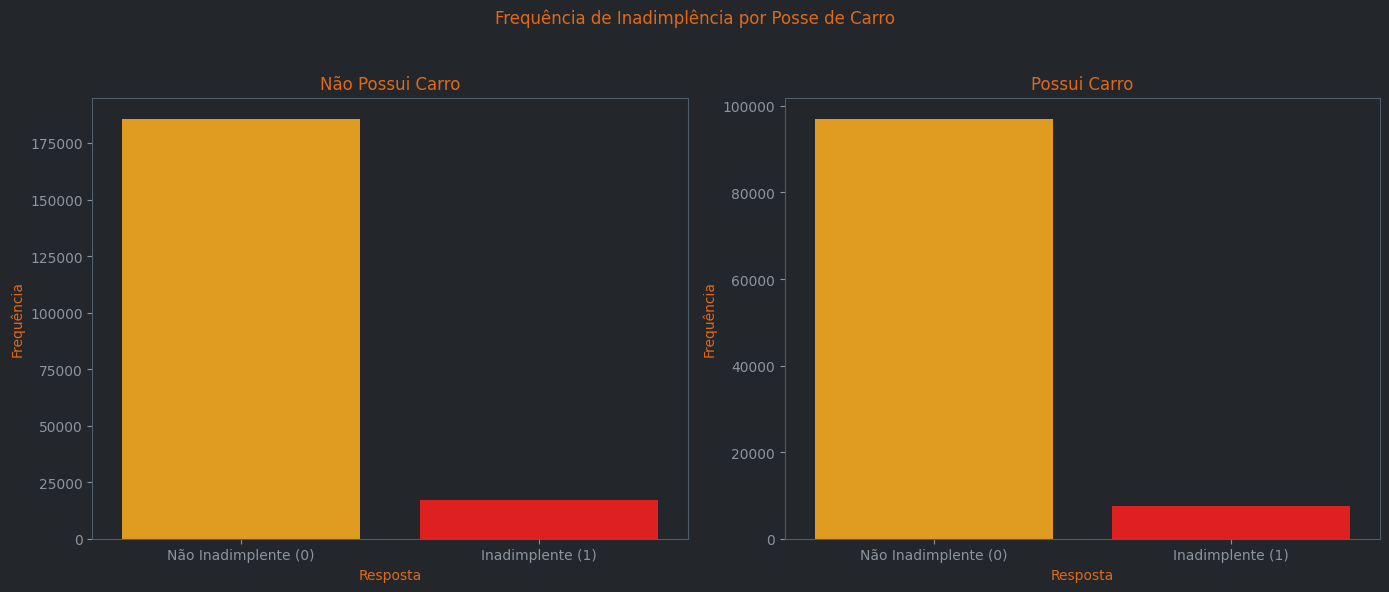

V de Cramer entre flag_own_car e target: 0.0218


In [72]:
plot_binaria_target(
    df3,
    var_binaria='flag_own_car',
    label_0='Não Possui Carro',
    label_1='Possui Carro',
    suptitle='Frequência de Inadimplência por Posse de Carro'
)

calcular_cramers_v(df3, 'flag_own_car', 'target')


##### H4 — Owning a home reduces the chance of default. FALSE

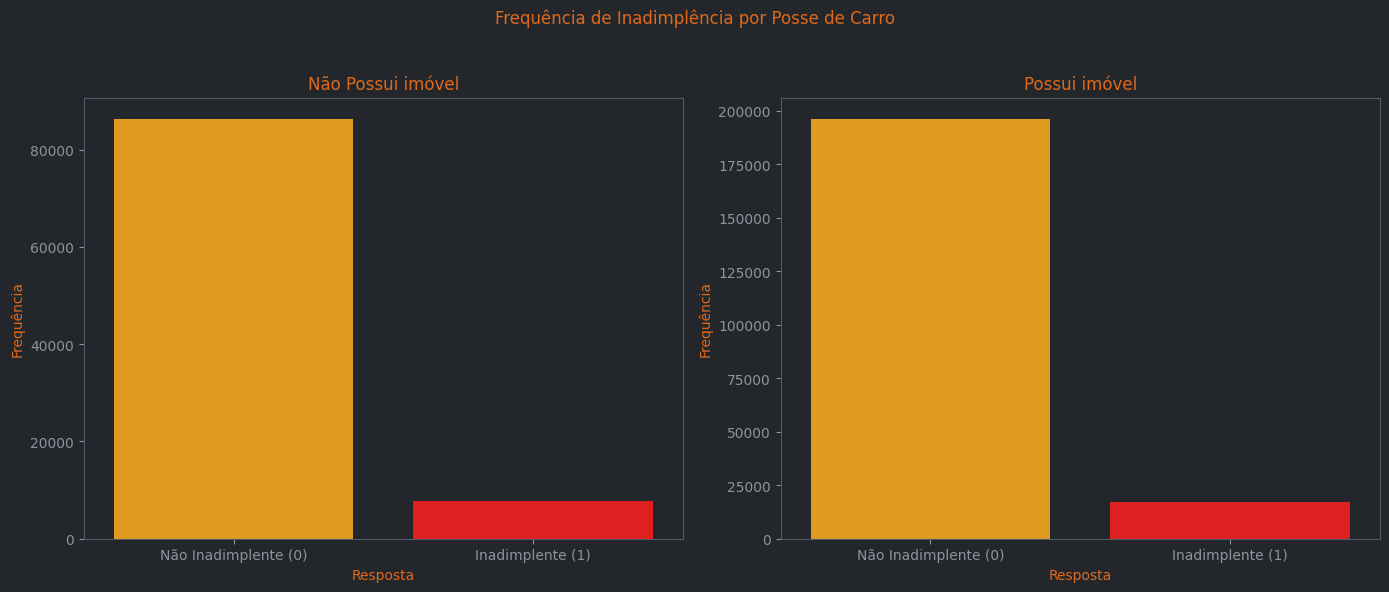

V de Cramer entre flag_own_realty e target: 0.0061


In [73]:
plot_binaria_target(
    df3,
    var_binaria='flag_own_realty',
    label_0='Não Possui imóvel',
    label_1='Possui imóvel',
    suptitle='Frequência de Inadimplência por Posse de Carro'
)

calcular_cramers_v(df3, 'flag_own_realty', 'target')


##### H5 — The number of children influences default risk. FALSE

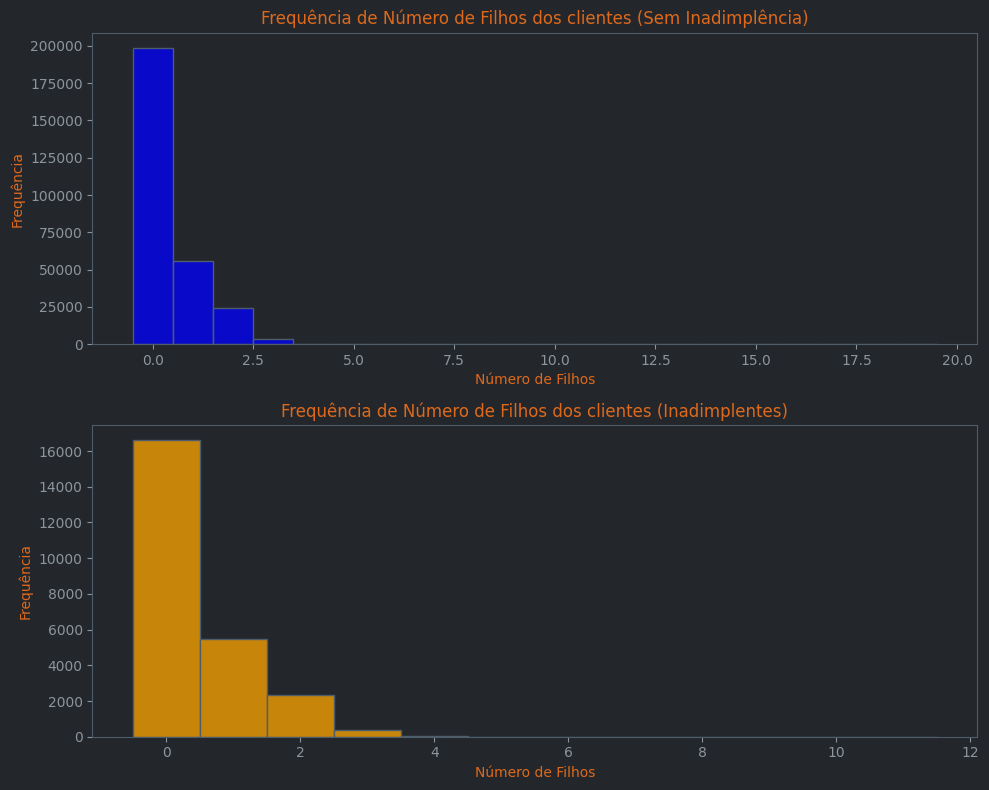

Correlação de Pearson entre cnt_children e target: 0.0192


In [74]:
plot_num_var_by_target(
    df3,
    num_var='cnt_children',
    title_0='Frequência de Número de Filhos dos clientes (Sem Inadimplência)',
    title_1='Frequência de Número de Filhos dos clientes (Inadimplentes)',
    label_x='Número de Filhos',
    discrete=True
)

pearson_corr = df3['cnt_children'].corr(df3['target'], method='pearson')
print(f"Correlação de Pearson entre cnt_children e target: {pearson_corr:.4f}")

##### H6 — Higher total income is associated with lower default risk. TRUE

In [ ]:
plot_num_var_by_target(
    df3,
    num_var='amt_income_total',
    title_0='Distribuição da Renda Total (amt_income_total) dos clientes (Sem Inadimplência)',
    title_1='Distribuição da Renda Total (amt_income_total) dos clientes (Inadimplentes)',
    label_x='Renda Total',
    discrete=True
)

pearson_corr = df3['amt_income_total'].corr(df3['target'], method='pearson')
print(f"Correlação de Pearson entre amt_income_total e target: {pearson_corr:.4f}")


##### H7 — Higher credit amounts are related to higher default risk. FALSE


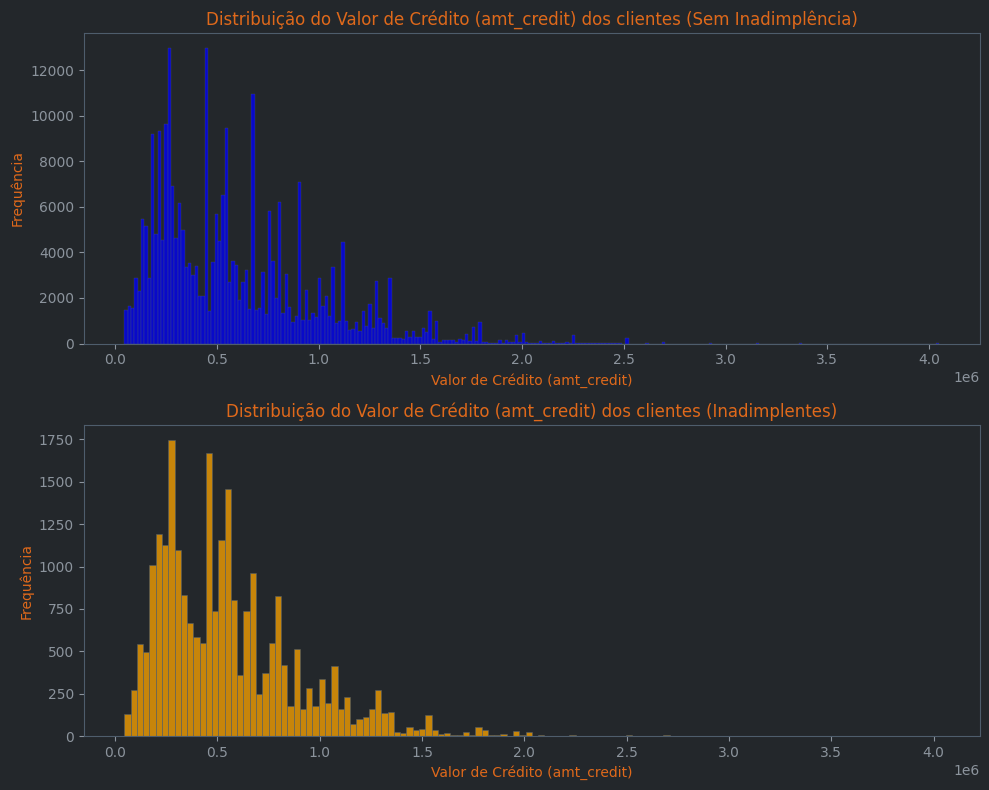

Correlação de Pearson entre amt_credit e target: -0.0304


In [ ]:
plot_num_var_by_target(
    df3,
    num_var='amt_credit',
    title_0='Distribuição do Valor de Crédito (amt_credit) dos clientes (Sem Inadimplência)',
    title_1='Distribuição do Valor de Crédito (amt_credit) dos clientes (Inadimplentes)',
    label_x='Valor de Crédito',
    discrete=True
)

pearson_corr = df3['amt_credit'].corr(df3['target'], method='pearson')
print(f"Correlação de Pearson entre amt_credit e target: {pearson_corr:.4f}")

##### H8 — Higher monthly installments increase the chance of default. FALSE


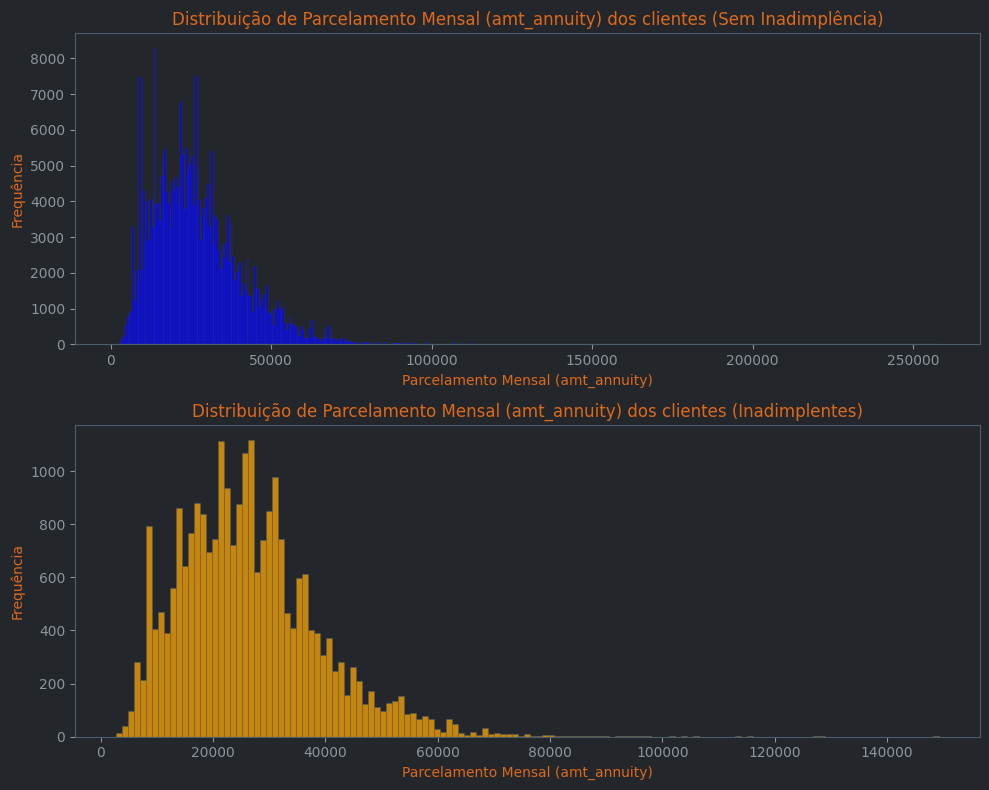

Correlação de Pearson entre amt_annuity e target: -0.0128


In [ ]:
plot_num_var_by_target(
    df3,
    num_var='amt_annuity',
    title_0='Distribuição de Parcelamento Mensal (amt_annuity) dos clientes (Sem Inadimplência)',
    title_1='Distribuição de Parcelamento Mensal (amt_annuity) dos clientes (Inadimplentes)',
    label_x='Parcelamento Mensal',
    discrete=True
)
pearson_corr = df3['amt_annuity'].corr(df3['target'], method='pearson')
print(f"Correlação de Pearson entre amt_annuity e target: {pearson_corr:.4f}")


##### H9 — The value of goods purchased influences default risk. FALSE


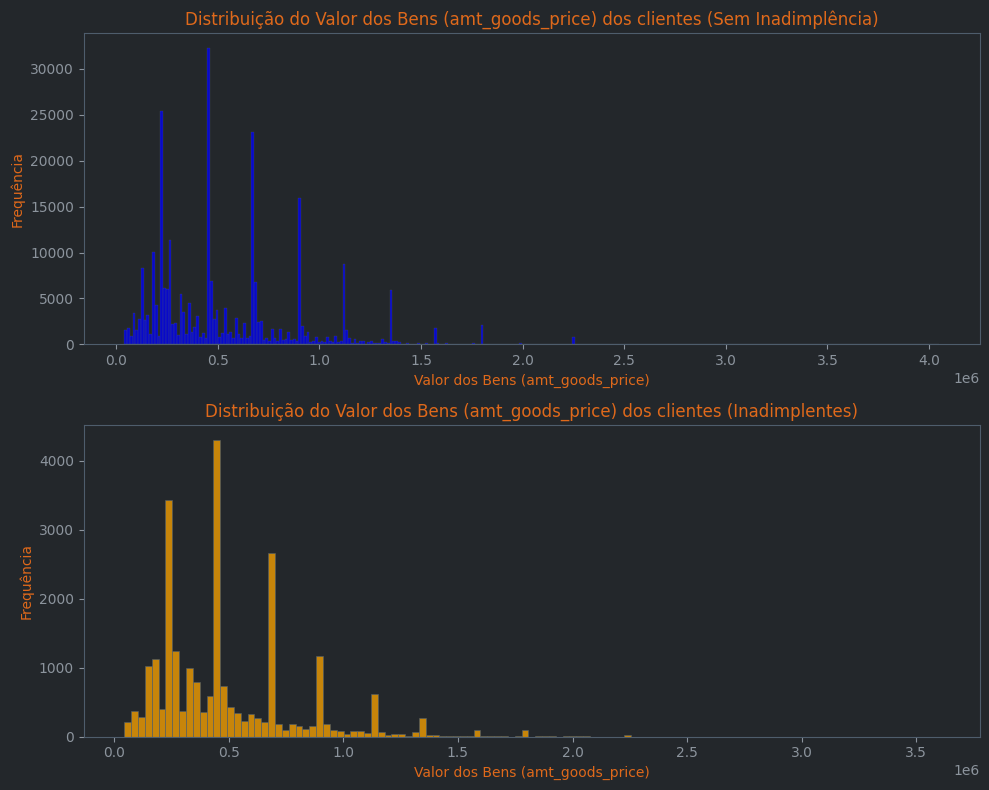

Correlação de Pearson entre amt_goods_price e target: -0.0396


In [ ]:
plot_num_var_by_target(
    df3,
    num_var='amt_goods_price',
    title_0='Distribuição do Valor dos Bens (amt_goods_price) dos clientes (Sem Inadimplência)',
    title_1='Distribuição do Valor dos Bens (amt_goods_price) dos clientes (Inadimplentes)',
    label_x='Valor dos Bens',
    discrete=True
)

pearson_corr = df3['amt_goods_price'].corr(df3['target'], method='pearson')
print(f"Correlação de Pearson entre amt_goods_price e target: {pearson_corr:.4f}")

#### Block 2 Hypotesis

##### H21 — Having a work phone registered reduces the risk of default. TRUE

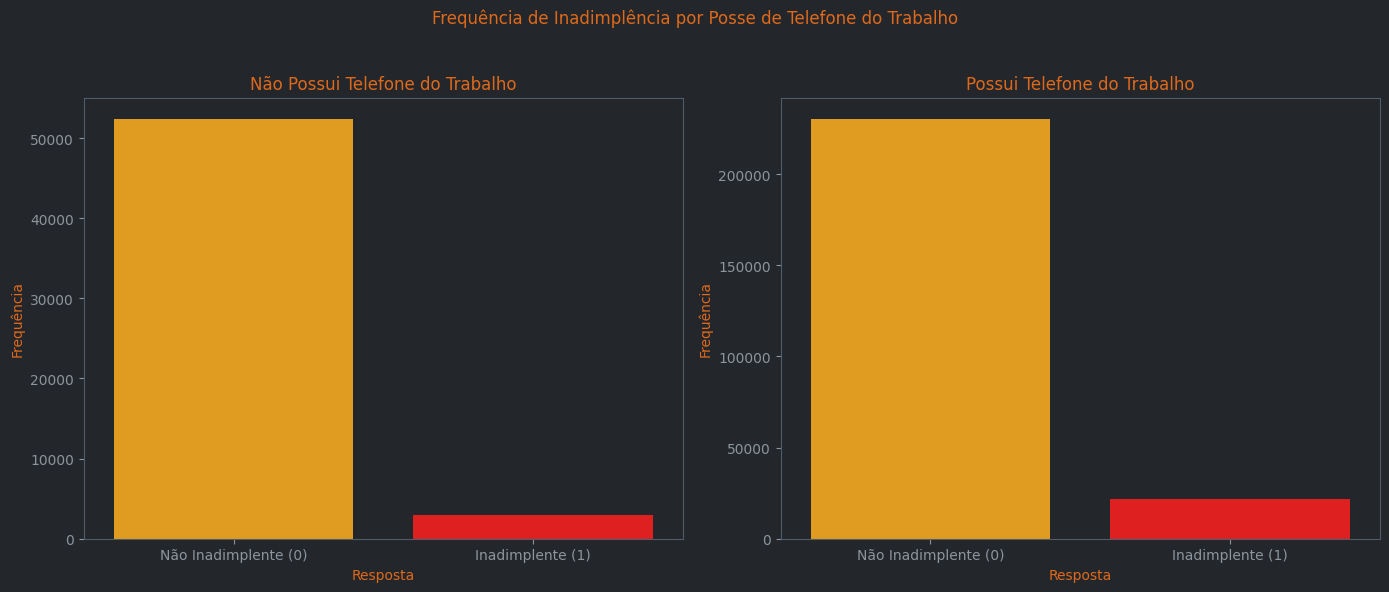

V de Cramer entre flag_emp_phone e target: 0.0460


In [ ]:
plot_binaria_target(
    df3,
    var_binaria='flag_emp_phone',
    label_0='Não Possui Telefone do Trabalho',
    label_1='Possui Telefone do Trabalho',
    suptitle='Frequência de Inadimplência por Posse de Telefone do Trabalho'
)

calcular_cramers_v(df3, 'flag_emp_phone', 'target')


##### H22 — Customers with a work phone provided are less likely to default. TRUE


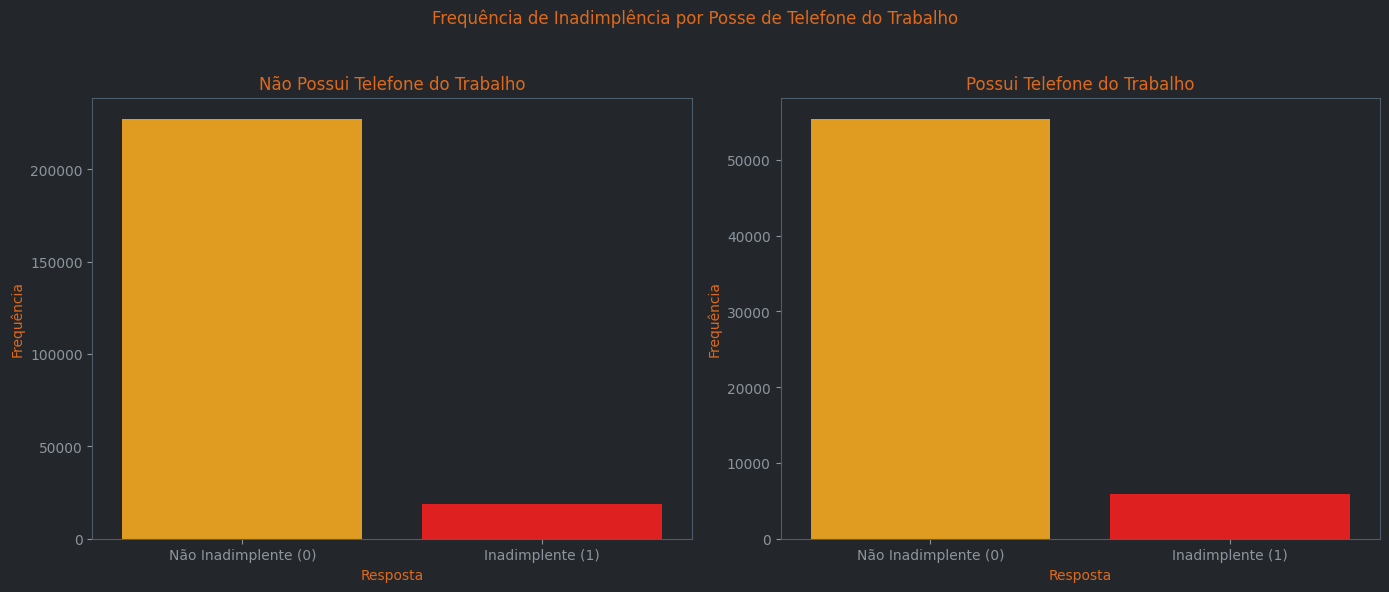

V de Cramer entre flag_work_phone e target: 0.0285


In [ ]:
plot_binaria_target(
    df3,
    var_binaria='flag_work_phone',
    label_0='Não Possui Telefone do Trabalho',
    label_1='Possui Telefone do Trabalho',
    suptitle='Frequência de Inadimplência por Posse de Telefone do Trabalho'
)

calcular_cramers_v(df3, 'flag_work_phone', 'target')



##### H23 — Having a registered mobile phone is associated with lower default risk. FALSE


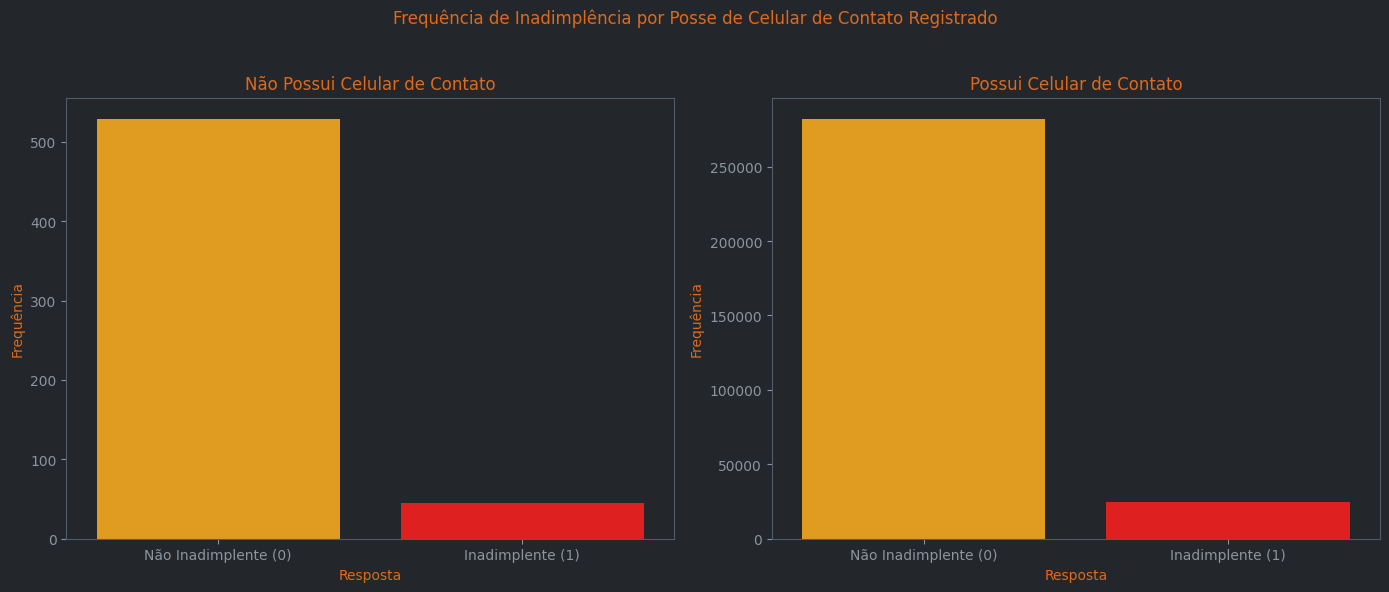

V de Cramer entre flag_cont_mobile e target: 0.0002


In [ ]:
plot_binaria_target(
    df3,
    var_binaria='flag_cont_mobile',
    label_0='Não Possui Celular de Contato',
    label_1='Possui Celular de Contato',
    suptitle='Frequência de Inadimplência por Posse de Celular de Contato Registrado'
)

calcular_cramers_v(df3, 'flag_cont_mobile', 'target')


##### H24 — Having a landline phone registered reduces default risk. TRUE


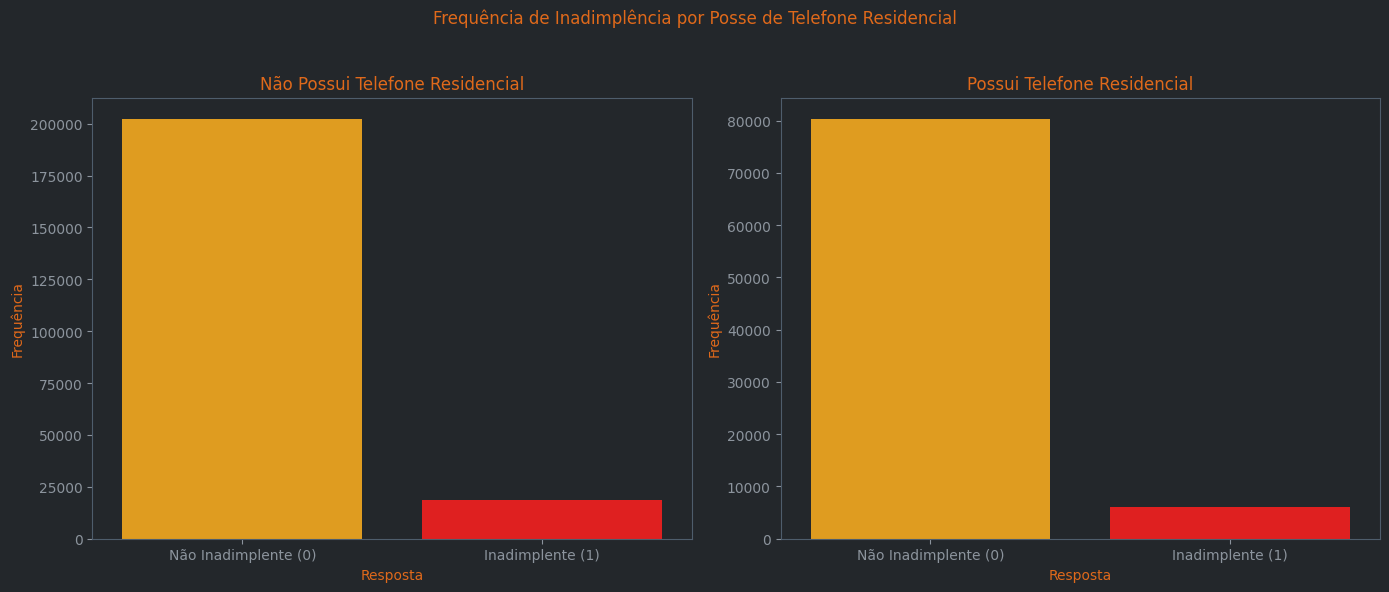

V de Cramer entre flag_phone e target: 0.0238


In [ ]:
plot_binaria_target(
    df3,
    var_binaria='flag_phone',
    label_0='Não Possui Telefone Residencial',
    label_1='Possui Telefone Residencial',
    suptitle='Frequência de Inadimplência por Posse de Telefone Residencial'
)


calcular_cramers_v(df3, 'flag_phone', 'target')


##### H25 — Customers with a registered email tend to present lower default risk. FALSE

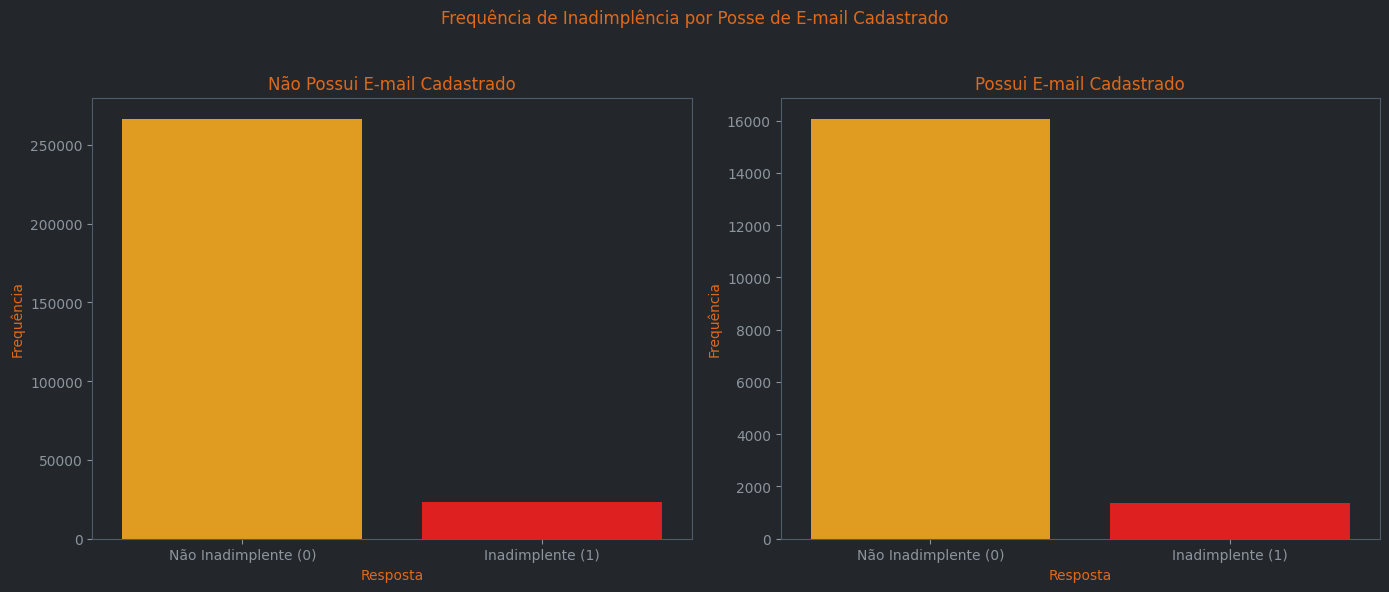

V de Cramer entre flag_email e target: 0.0017


In [ ]:
plot_binaria_target(
    df3,
    var_binaria='flag_email',
    label_0='Não Possui E-mail Cadastrado',
    label_1='Possui E-mail Cadastrado',
    suptitle='Frequência de Inadimplência por Posse de E-mail Cadastrado'
)


calcular_cramers_v(df3, 'flag_email', 'target')


##### H26 — Occupation type influences default risk. TRUE


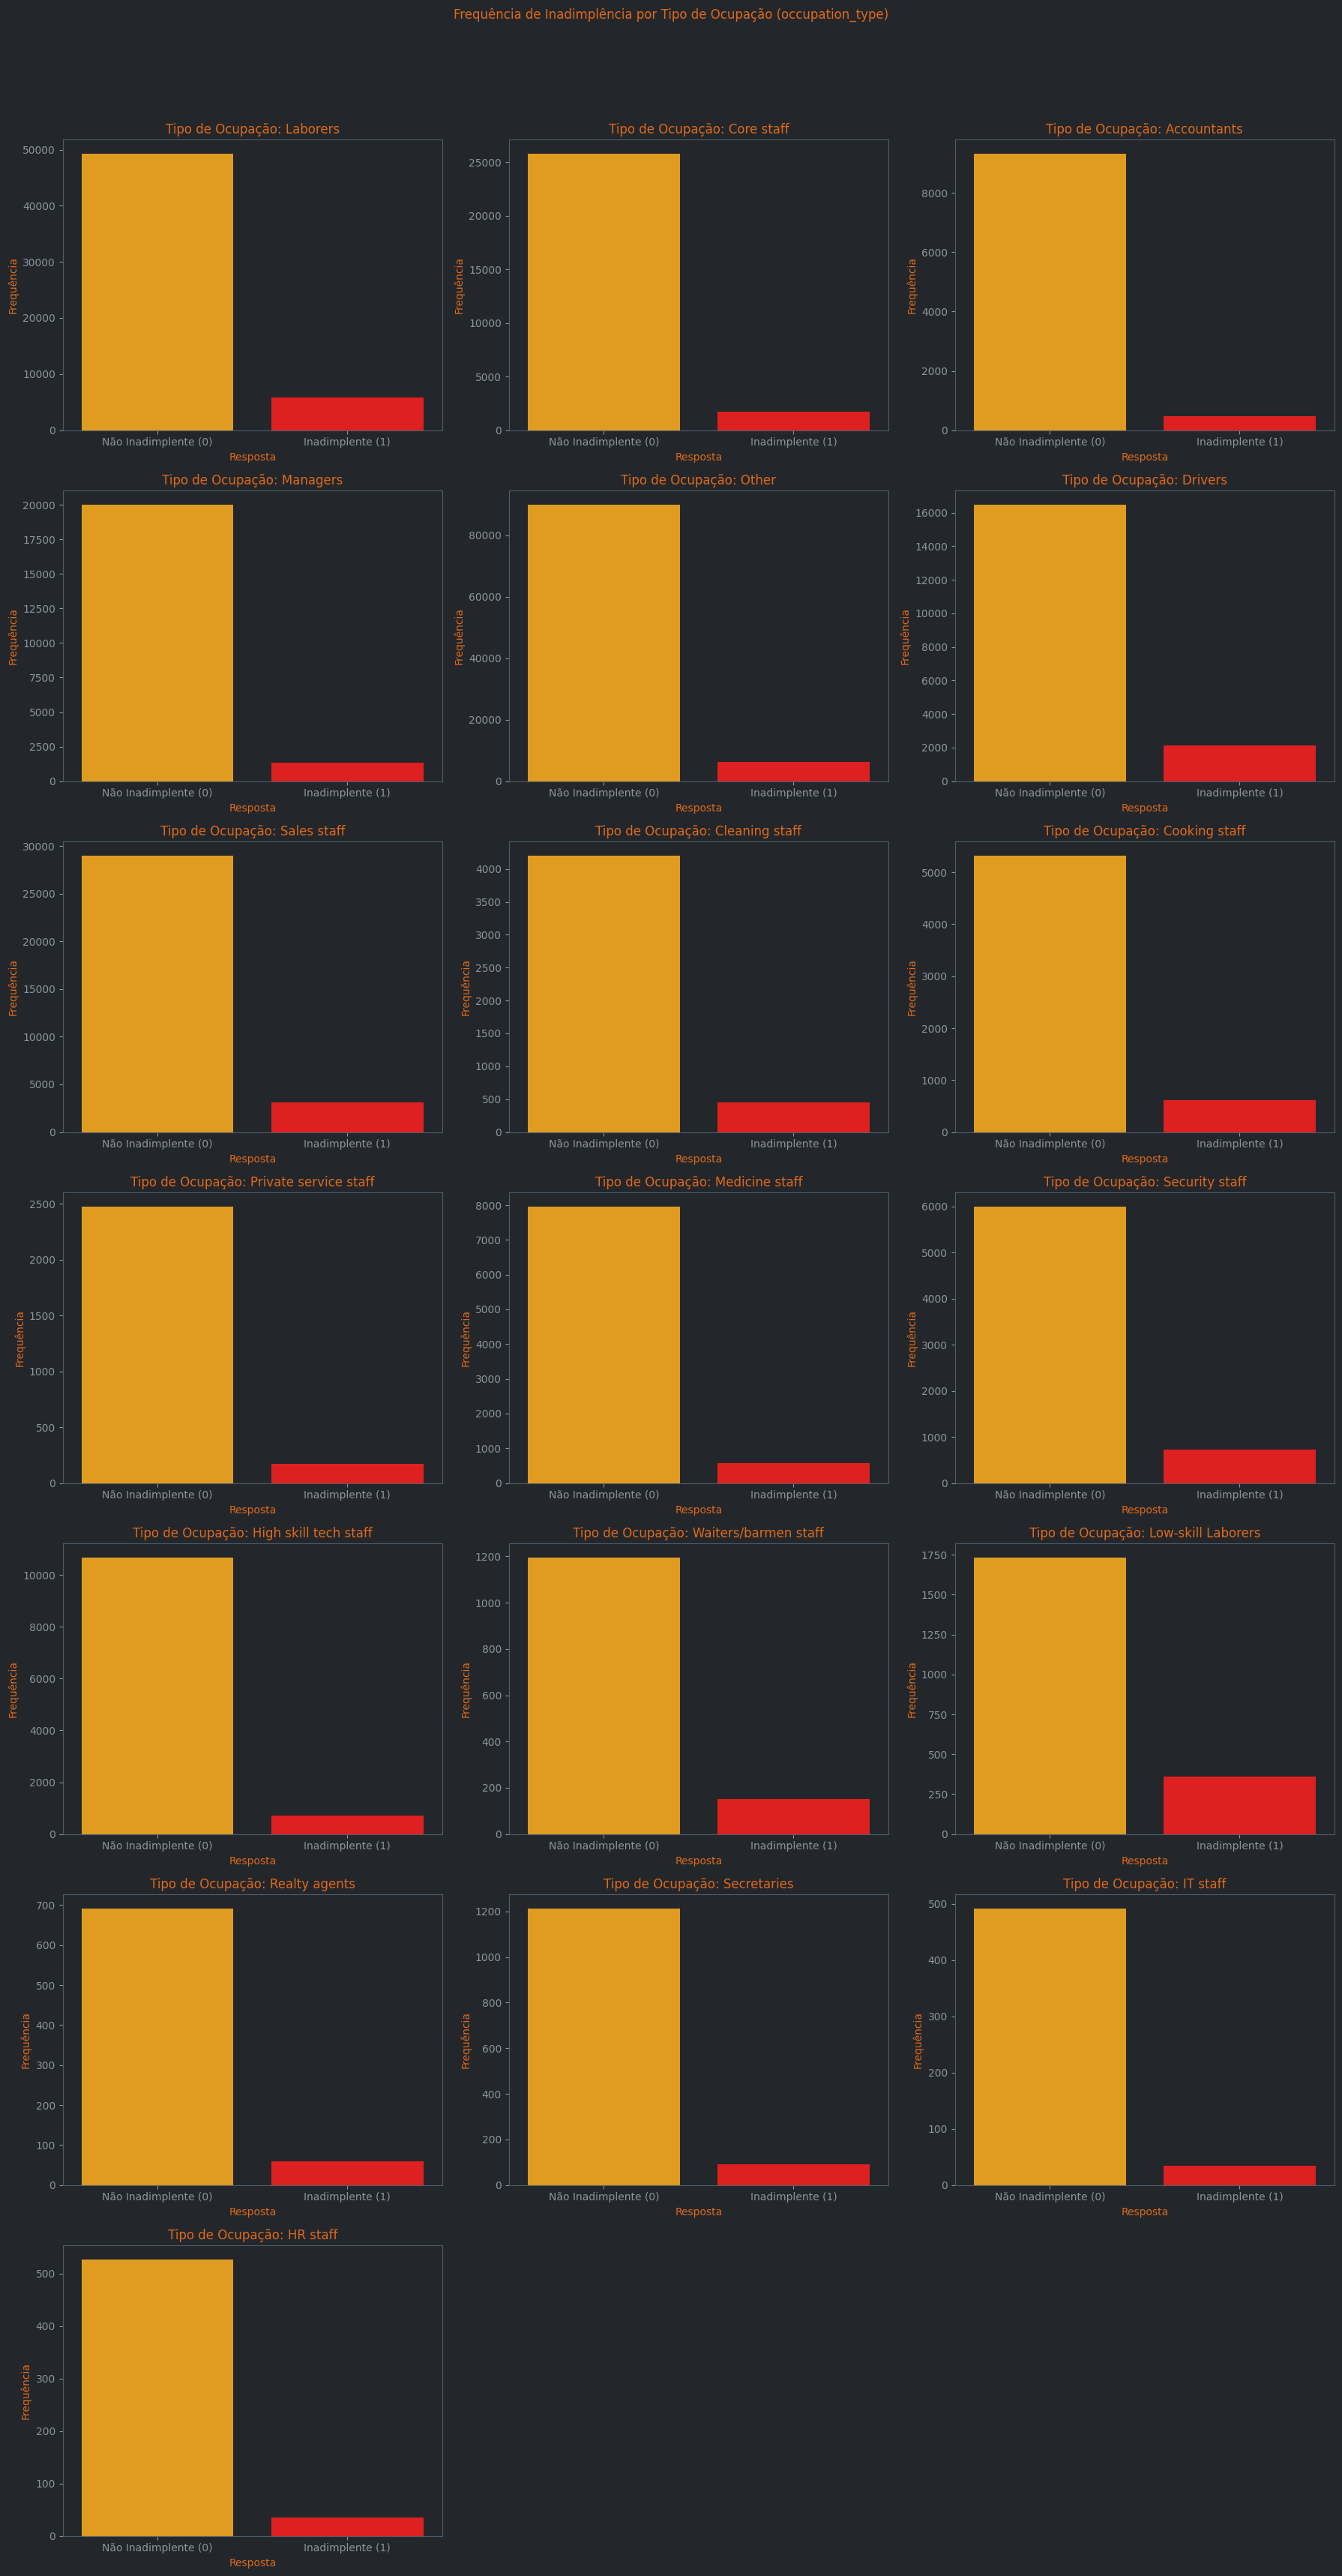

V de Cramer entre occupation_type e target: 0.0801


In [ ]:
plot_target_by_categorical(df3, cat_col='occupation_type', target_col='target')
calcular_cramers_v(df3, 'occupation_type', 'target')

##### H27 — The number of family members is positively related to default risk. FALSE

In [ ]:
plot_num_var_by_target(
    df3,
    num_var='cnt_fam_members',
    title_0='Distribuição de cnt_fam_members dos clientes (Sem Inadimplência)',
    title_1='Distribuição de cnt_fam_members dos clientes (Inadimplentes)',
    label_x='cnt_fam_members',
    discrete=True
)
pearson_corr = df3['cnt_fam_members'].corr(df3['target'], method='pearson')
print(f"Correlação de Pearson entre cnt_fam_members e target: {pearson_corr:.4f}")

##### H28 — Customers from regions with lower ratings have a higher probability of default. TRUE

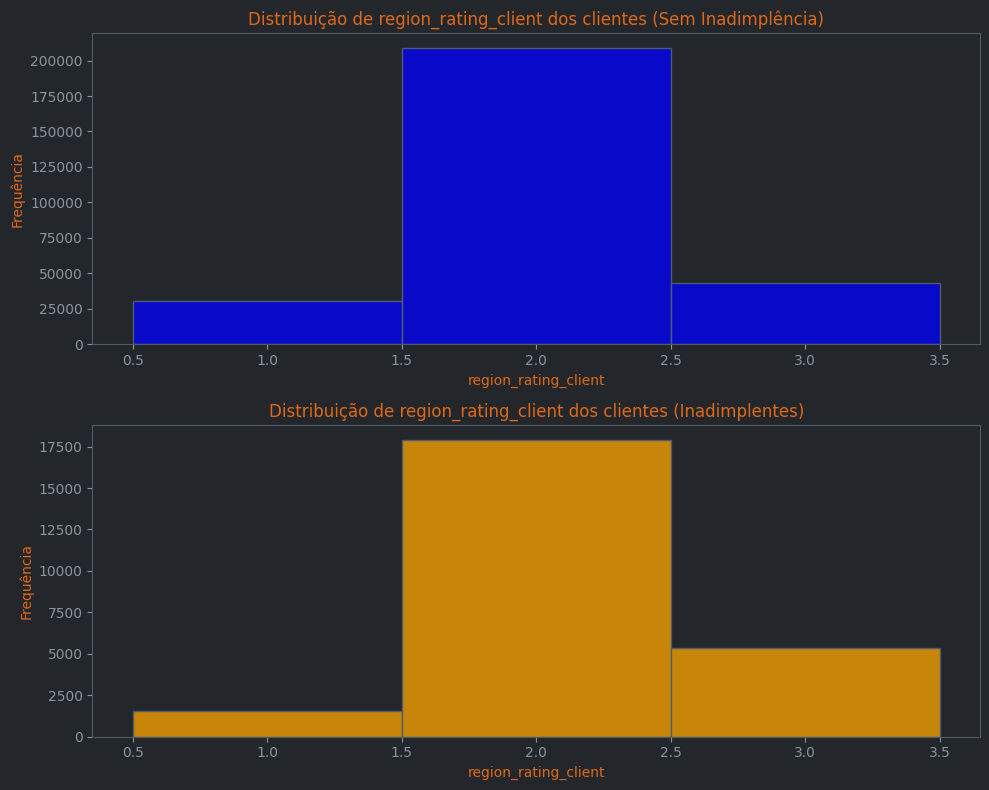

Correlação de Pearson entre region_rating_client e target: 0.0589


In [ ]:
plot_num_var_by_target(
    df3,
    num_var='region_rating_client',
    title_0='Distribuição de region_rating_client dos clientes (Sem Inadimplência)',
    title_1='istribuição de region_rating_client dos clientes (Inadimplentes)',
    label_x='region_rating_client',
    discrete=True
)
# Correlação de region_rating_client com a target
pearson_corr = df3['region_rating_client'].corr(df3['target'], method='pearson')
print(f"Correlação de Pearson entre region_rating_client e target: {pearson_corr:.4f}")

##### H29 — The customer's city rating influences default risk. TRUE

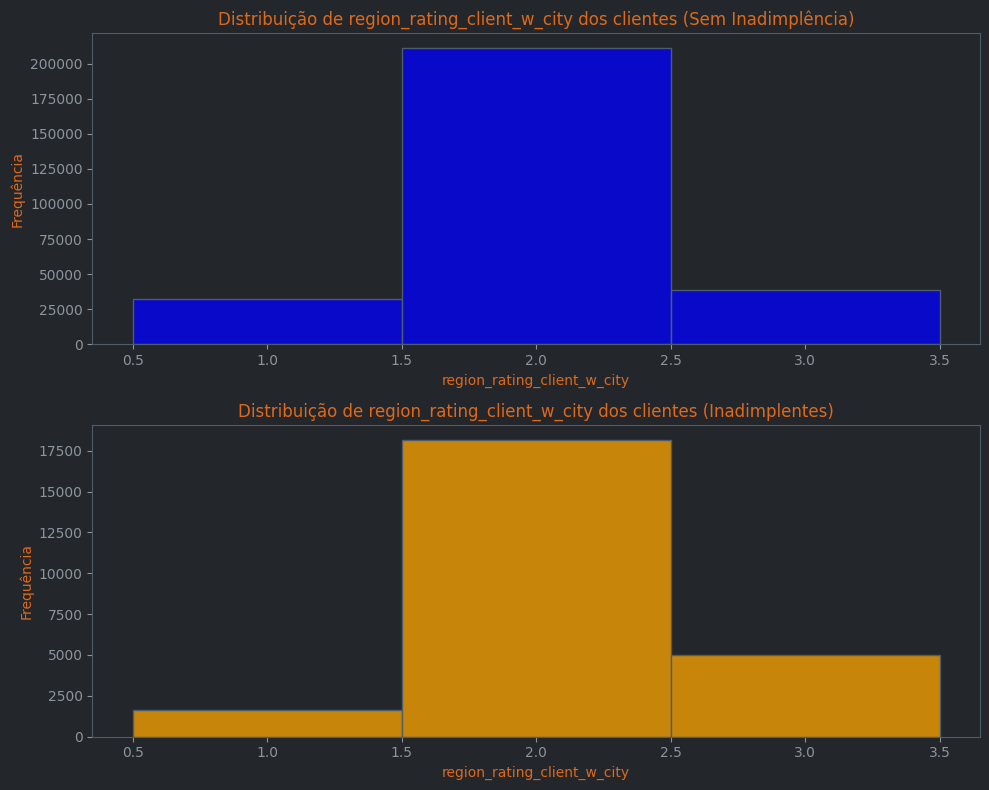

Correlação de Pearson entre region_rating_client_w_city e target: 0.0609


In [ ]:
plot_num_var_by_target(
    df3,
    num_var='region_rating_client_w_city',
    title_0='Distribuição de region_rating_client_w_city dos clientes (Sem Inadimplência)',
    title_1='Distribuição de region_rating_client_w_city dos clientes (Inadimplentes)',
    label_x='region_rating_client_w_city',
    discrete=True
)
# Correlação de region_rating_client_w_city com a target
pearson_corr = df3['region_rating_client_w_city'].corr(df3['target'], method='pearson')
print(f"Correlação de Pearson entre region_rating_client_w_city e target: {pearson_corr:.4f}")

##### H30 — The day of the week when the credit application is made influences the probability of default. FALSE

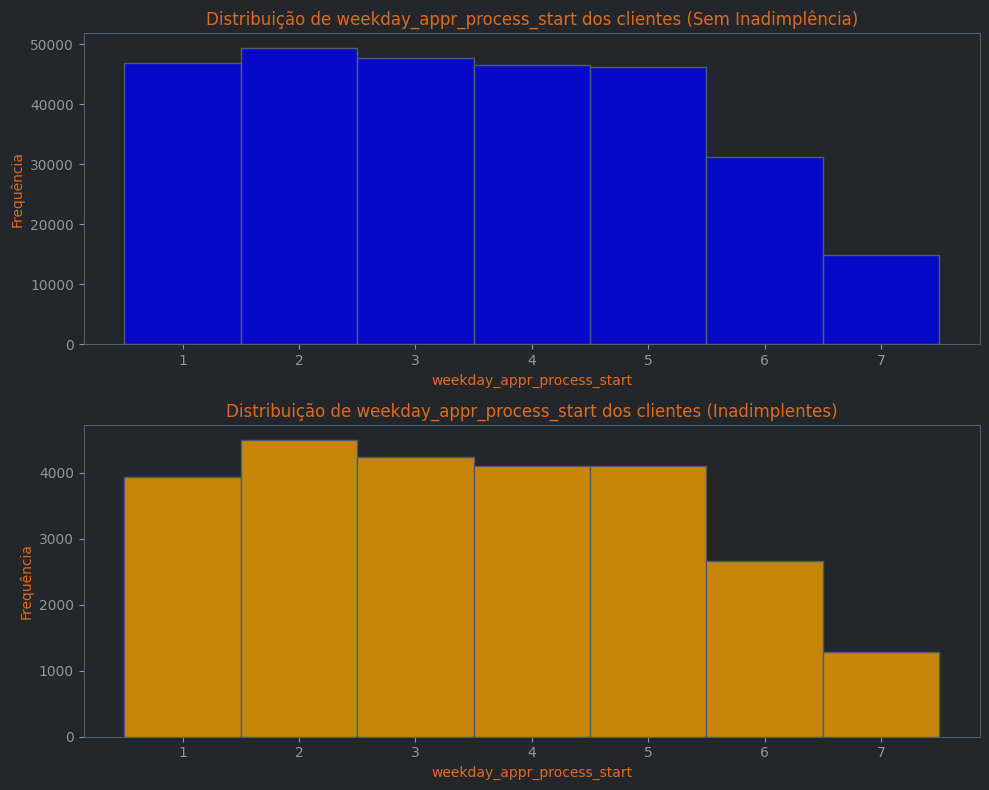

Correlação de Pearson entre weekday_appr_process_start e target: -0.0002


In [ ]:
plot_num_var_by_target(
    df3,
    num_var='weekday_appr_process_start',
    title_0='Distribuição de weekday_appr_process_start dos clientes (Sem Inadimplência)',
    title_1='Distribuição de weekday_appr_process_start dos clientes (Inadimplentes)',
    label_x='weekday_appr_process_start',
    discrete=True
)

pearson_corr = df3['weekday_appr_process_start'].corr(df3['target'], method='pearson')
print(f"Correlação de Pearson entre weekday_appr_process_start e target: {pearson_corr:.4f}")

##### H31 — The time of credit application is associated with default. FALSE

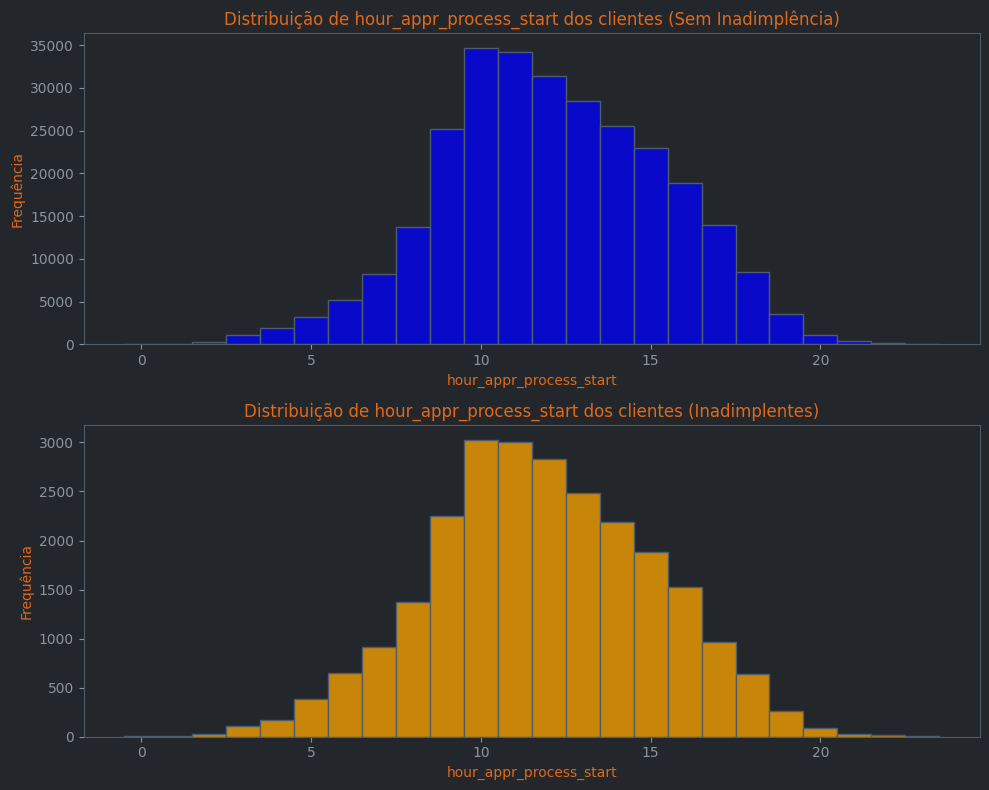

Correlação de Pearson entre hour_appr_process_start e target: -0.0242


In [ ]:
plot_num_var_by_target(
    df3,
    num_var='hour_appr_process_start',
    title_0='Distribuição de hour_appr_process_start dos clientes (Sem Inadimplência)',
    title_1='Distribuição de hour_appr_process_start dos clientes (Inadimplentes)',
    label_x='hour_appr_process_start',
    discrete=True
)
pearson_corr = df3['hour_appr_process_start'].corr(df3['target'], method='pearson')
print(f"Correlação de Pearson entre hour_appr_process_start e target: {pearson_corr:.4f}")


##### H32 — Living in a region different from the registered one increases default risk. FALSE


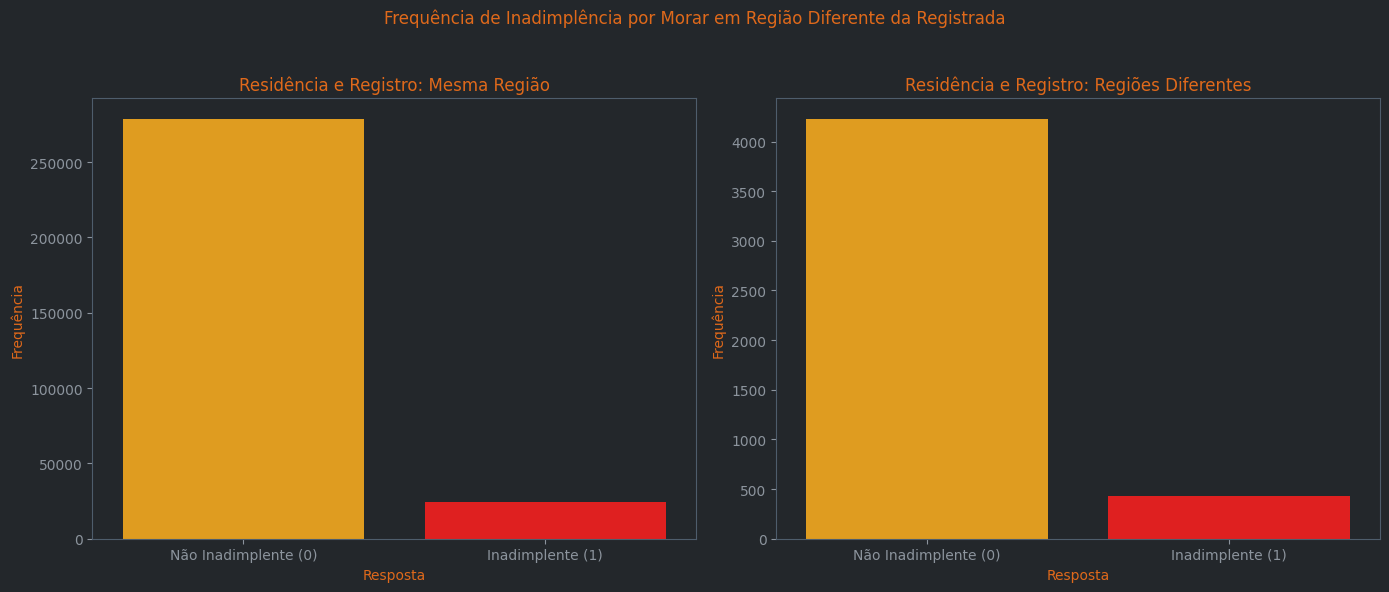

V de Cramer entre reg_region_not_live_region e target: 0.0055


In [ ]:
reg_region_flags = [0, 1]

palette_target = {'0': "orange", '1': "red"}  

fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=False)

for i, flag in enumerate(reg_region_flags):
    data_plot = df3[df3['reg_region_not_live_region'] == flag].copy()
    data_plot['target_str'] = data_plot['target'].astype(str)
    sns.countplot(
        data=data_plot,
        x='target_str',
        hue='target_str',
        palette=palette_target,
        order=['0', '1'],
        ax=axes[i],
        legend=False
    )
    reg_region_label = "Mesma Região" if flag == 0 else "Regiões Diferentes"
    axes[i].set_title(f"Residência e Registro: {reg_region_label}")
    axes[i].set_xlabel('Resposta')
    axes[i].set_ylabel('Frequência')
    axes[i].set_xticks([0, 1])
    axes[i].set_xticklabels(['Não Inadimplente (0)', 'Inadimplente (1)'])

plt.suptitle('Frequência de Inadimplência por Morar em Região Diferente da Registrada')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

plot_num_var_by_target(
    df3,
    num_var='reg_region_not_live_region',
    title_0='Distribuição do Valor de Crédito (amt_credit) dos clientes (Sem Inadimplência)',
    title_1='Distribuição do Valor de Crédito (amt_credit) dos clientes (Inadimplentes)',
    label_x='reg_region_not_live_region',
    discrete=True
)
calcular_cramers_v(df3, 'reg_region_not_live_region', 'target')


##### H33 — Working in a region different from the registered one is associated with higher risk. FALSE

In [ ]:
plot_binaria_target(
    df3,
    var_binaria='reg_region_not_work_region',
    label_0='Mesma Região',
    label_1='Regiões Diferentes',
    suptitle='Frequência de Inadimplência por Morar em Região Diferente da Região de Trabalho'
)

calcular_cramers_v(df3, 'reg_region_not_work_region', 'target')



##### H34 — Living and working in different regions may increase the probability of default. FALSE


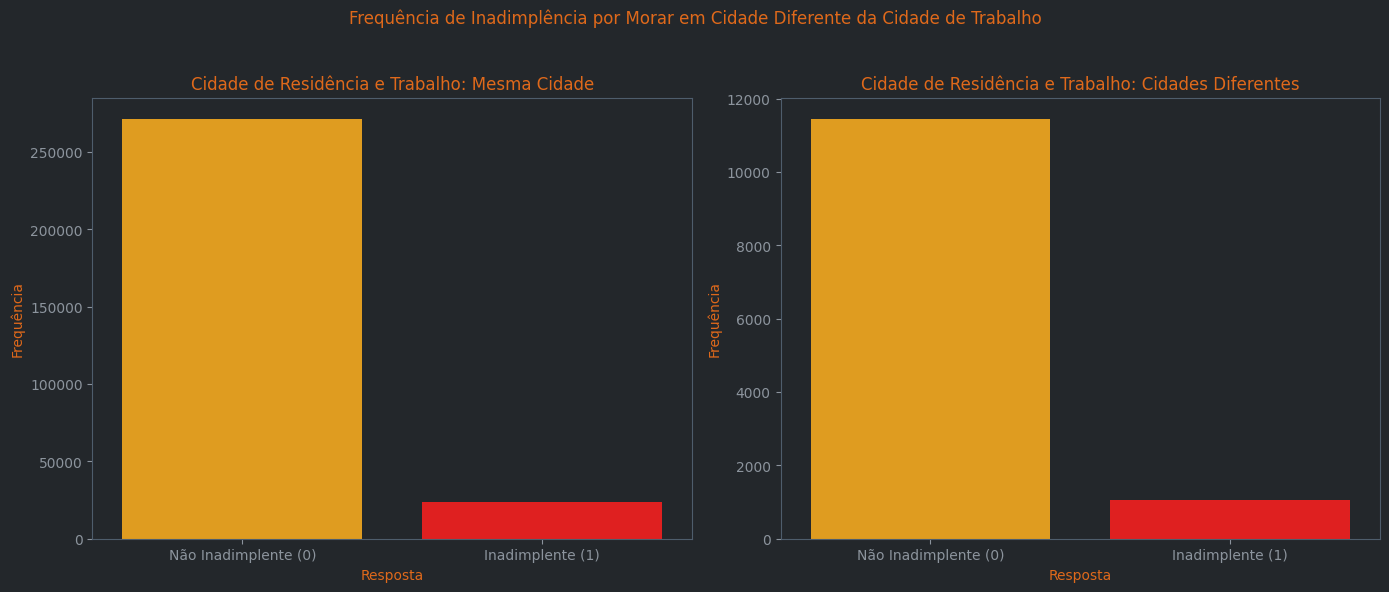

V de Cramer entre live_region_not_work_region e target: 0.0028


In [ ]:

live_region_not_work_flags = [0, 1]

palette_target = {'0': "orange", '1': "red"}  

fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=False)

for i, flag in enumerate(live_region_not_work_flags):

    data_plot = df3[df3['live_region_not_work_region'] == flag].copy()
    data_plot['target_str'] = data_plot['target'].astype(str)
    sns.countplot(
        data=data_plot,
        x='target_str',
        hue='target_str',
        palette=palette_target,
        order=['0', '1'],
        ax=axes[i],
        legend=False
    )

    live_region_work_str = "Mesma Cidade" if flag == 0 else "Cidades Diferentes"
    axes[i].set_title(f"Cidade de Residência e Trabalho: {live_region_work_str}")
    axes[i].set_xlabel('Resposta')
    axes[i].set_ylabel('Frequência')
    axes[i].set_xticks([0, 1])
    axes[i].set_xticklabels(['Não Inadimplente (0)', 'Inadimplente (1)'])

plt.suptitle('Frequência de Inadimplência por Morar em Cidade Diferente da Cidade de Trabalho')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

plot_binaria_target(
    df3,
    var_binaria='live_region_not_work_region',
    label_0='Mesma Cidade',
    label_1='Cidades Diferentes',
    suptitle='Frequência de Inadimplência por Morar em Cidade Diferente da Cidade de Trabalho'
)
calcular_cramers_v(df3, 'live_region_not_work_region', 'target')



##### H35 — Living in a city different from the registered one increases the chance of default. TRUE


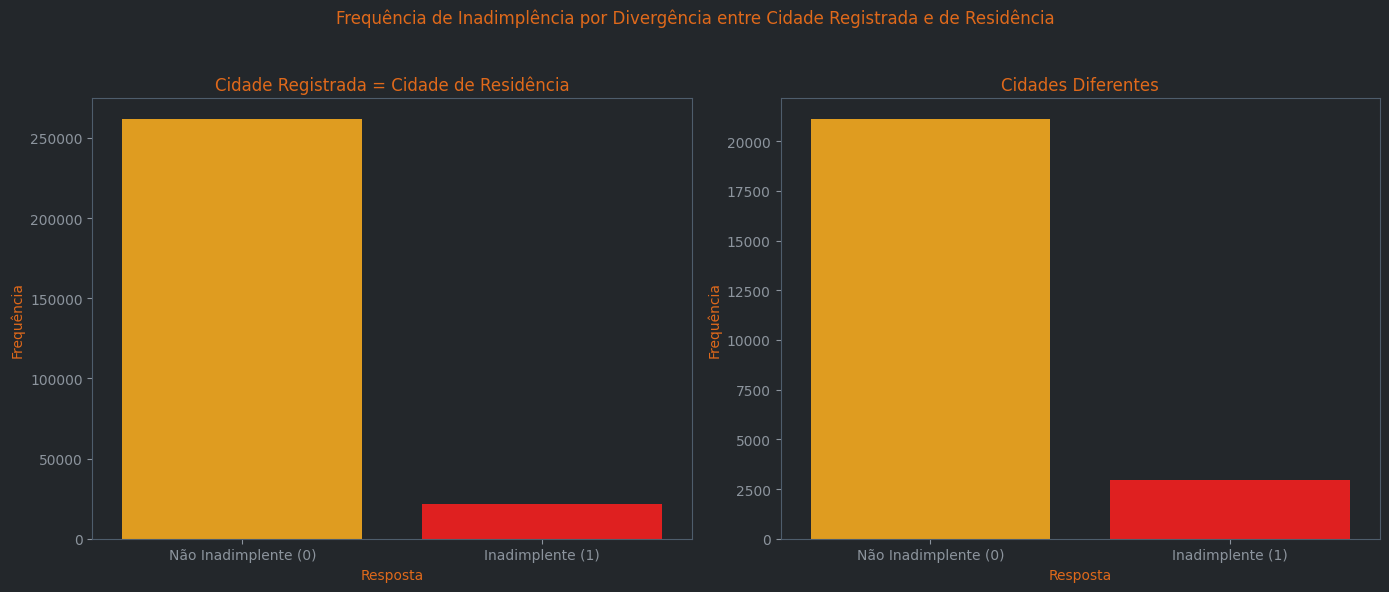

V de Cramer entre reg_city_not_live_city e target: 0.0444


In [ ]:
plot_binaria_target(
    df3,
    var_binaria='reg_city_not_live_city',
    label_0='Cidade Registrada = Cidade de Residência',
    label_1='Cidades Diferentes',
    suptitle='Frequência de Inadimplência por Divergência entre Cidade Registrada e de Residência'
)
calcular_cramers_v(df3, 'reg_city_not_live_city', 'target')


##### H36 — Working in a city different from the registered one increases default risk. TRUE


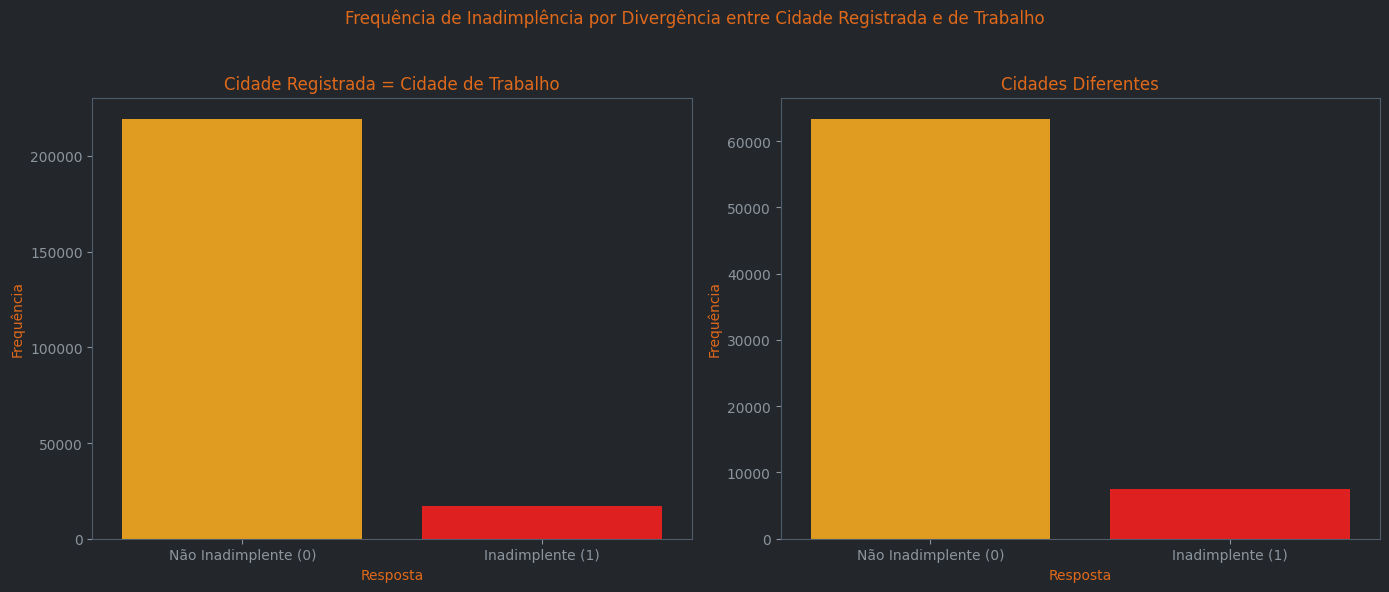

V de Cramer entre reg_city_not_work_city e target: 0.0510


In [ ]:

plot_binaria_target(
    df3,
    var_binaria='reg_city_not_work_city',
    label_0='Cidade Registrada = Cidade de Trabalho',
    label_1='Cidades Diferentes',
    suptitle='Frequência de Inadimplência por Divergência entre Cidade Registrada e de Trabalho'
)
calcular_cramers_v(df3, 'reg_city_not_work_city', 'target')


##### H37 — Living in a different city than the workplace influences default risk. TRUE 


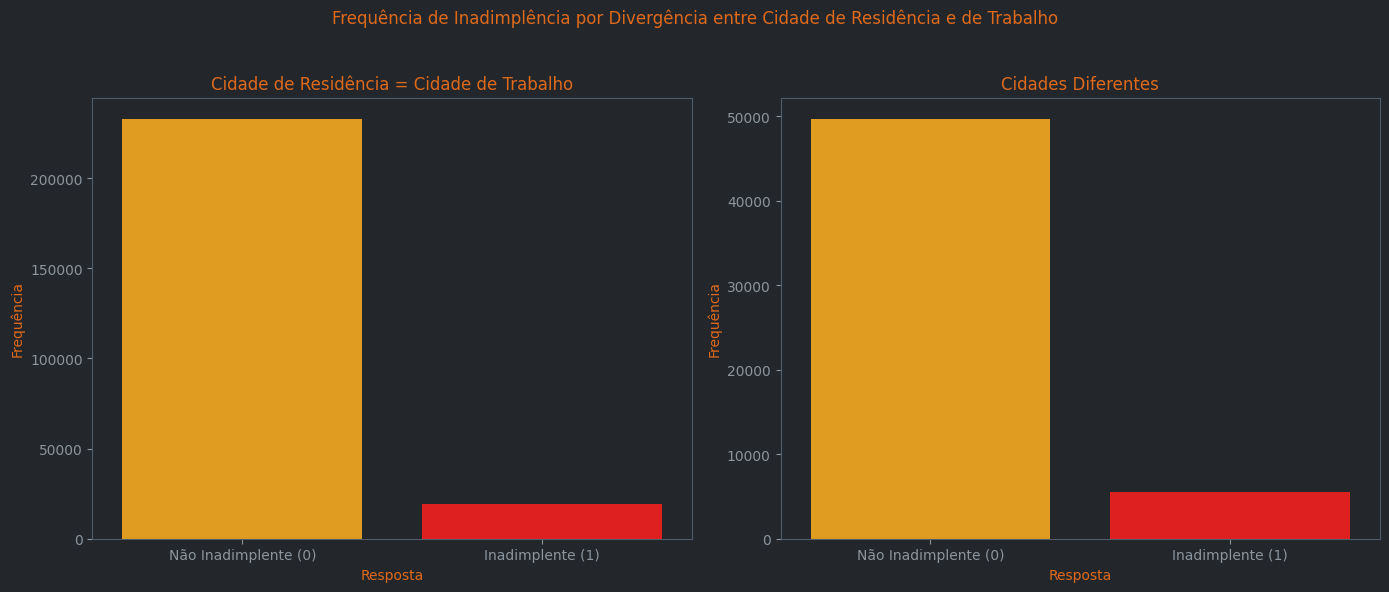

V de Cramer entre live_city_not_work_city e target: 0.0325


In [ ]:
plot_binaria_target(
    df3,
    var_binaria='live_city_not_work_city',
    label_0='Cidade de Residência = Cidade de Trabalho',
    label_1='Cidades Diferentes',
    suptitle='Frequência de Inadimplência por Divergência entre Cidade de Residência e de Trabalho'
)
calcular_cramers_v(df3, 'live_city_not_work_city', 'target')


##### H38 — The type of employing organization is associated with default risk. TRUE


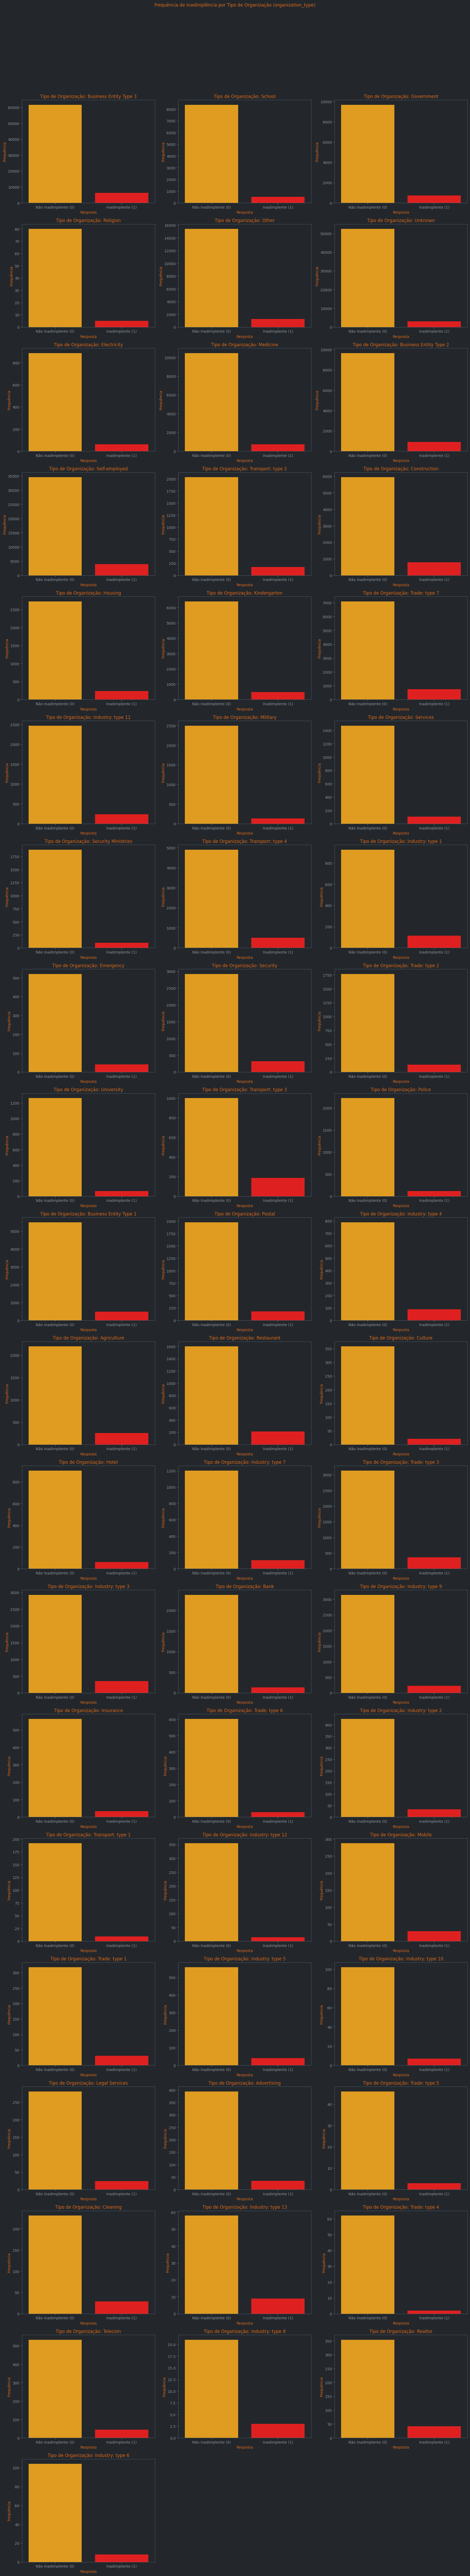

V de Cramer entre organization_type e target: 0.0723


In [ ]:
plot_target_by_categorical(df3, cat_col='organization_type', target_col='target')
calcular_cramers_v(df3, 'organization_type', 'target')

##### H39 — External score 2 is inversely related to default. TRUE


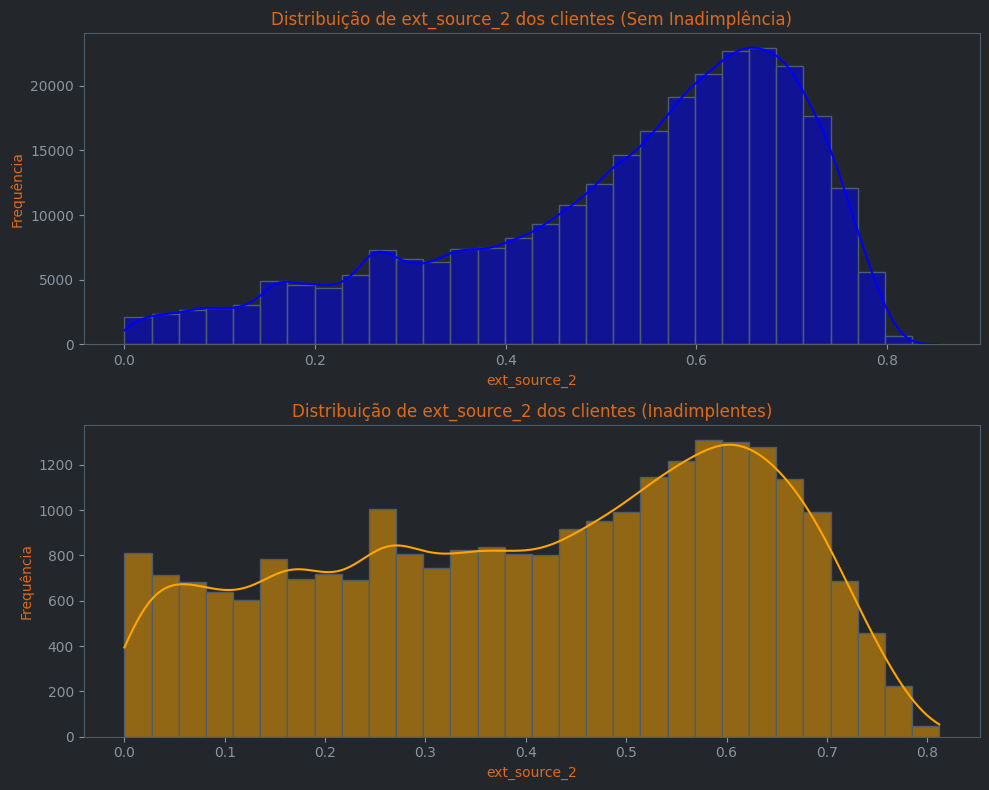

Correlação de Pearson entre ext_source_2 e target: -0.1603


In [ ]:

plot_num_var_by_target(
    df3,
    num_var='ext_source_2',
    title_0='Distribuição de ext_source_2 dos clientes (Sem Inadimplência)',
    title_1='Distribuição de ext_source_2 dos clientes (Inadimplentes)',
    label_x='Distribuição de ext_source_2 dos clientes (Inadimplentes)',
    discrete=True
)
pearson_corr = df3['ext_source_2'].corr(df3['target'], method='pearson')
print(f"Correlação de Pearson entre ext_source_2 e target: {pearson_corr:.4f}")

##### H40 — External score 3 is inversely related to default. TRUE


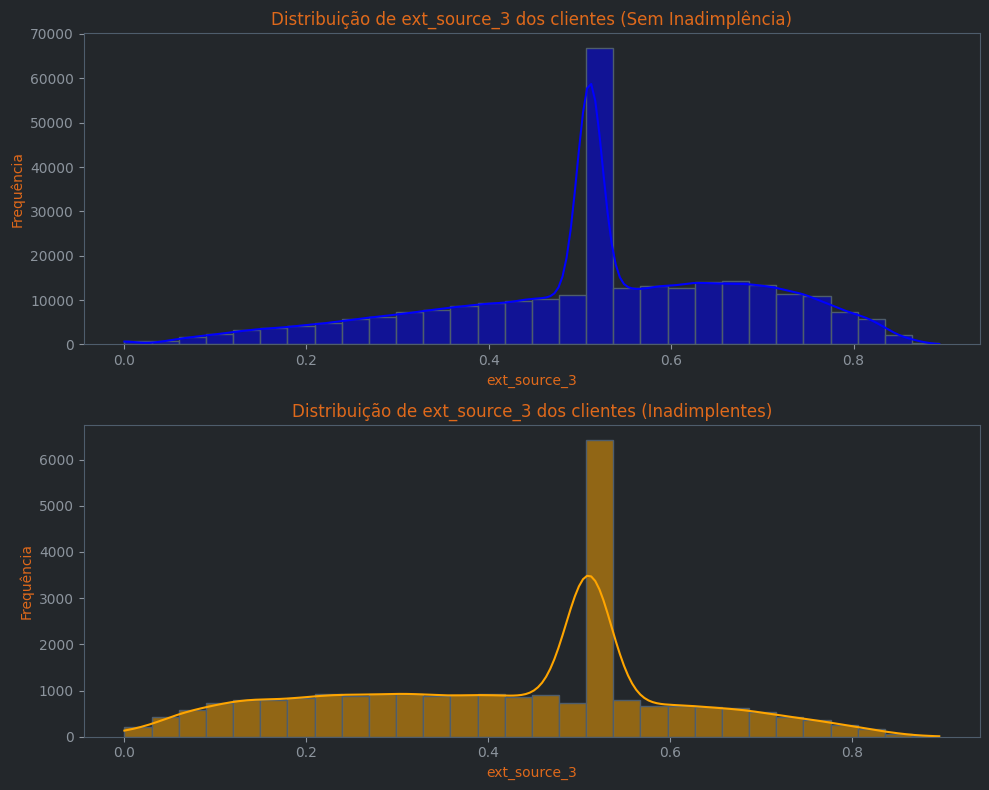

Correlação de Pearson entre ext_source_3 e target: -0.1574


In [ ]:

plot_num_var_by_target(
    df3,
    num_var='ext_source_2',
    title_0='Distribuição de ext_source_3 dos clientes (Sem Inadimplência)',
    title_1='Distribuição de ext_source_3 dos clientes (Inadimplentes)',
    label_x='Distribuição de ext_source_3 dos clientes (Inadimplentes)',
    discrete=True
)


pearson_corr = df3['ext_source_3'].corr(df3['target'], method='pearson')
print(f"Correlação de Pearson entre ext_source_3 e target: {pearson_corr:.4f}")

#### Block 3 Hypotesis

##### H41 — The average number of elevators in a building is inversely related to the probability of default. TRUE


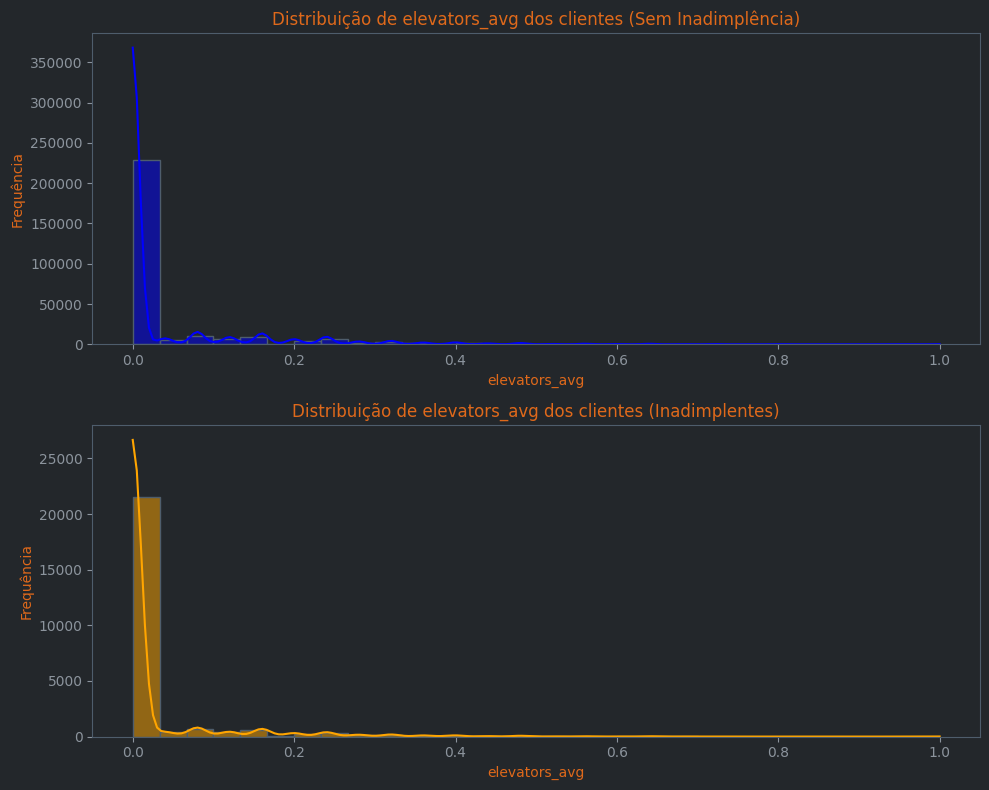

Correlação de Pearson entre elevators_avg e target: -0.0359


In [ ]:
plot_num_var_by_target(
    df3,
    num_var='elevators_avg',
    title_0='Distribuição de elevators_avg dos clientes (Sem Inadimplência)',
    title_1='Distribuição de elevators_avg dos clientes (Inadimplentes)',
    label_x='elevators_avg',
    discrete=True
)
# Correlação de elevators_avg com a target
pearson_corr = df3['elevators_avg'].corr(df3['target'], method='pearson')
print(f"Correlação de Pearson entre elevators_avg e target: {pearson_corr:.4f}")

##### H42 — Housing type influences default risk. TRUE

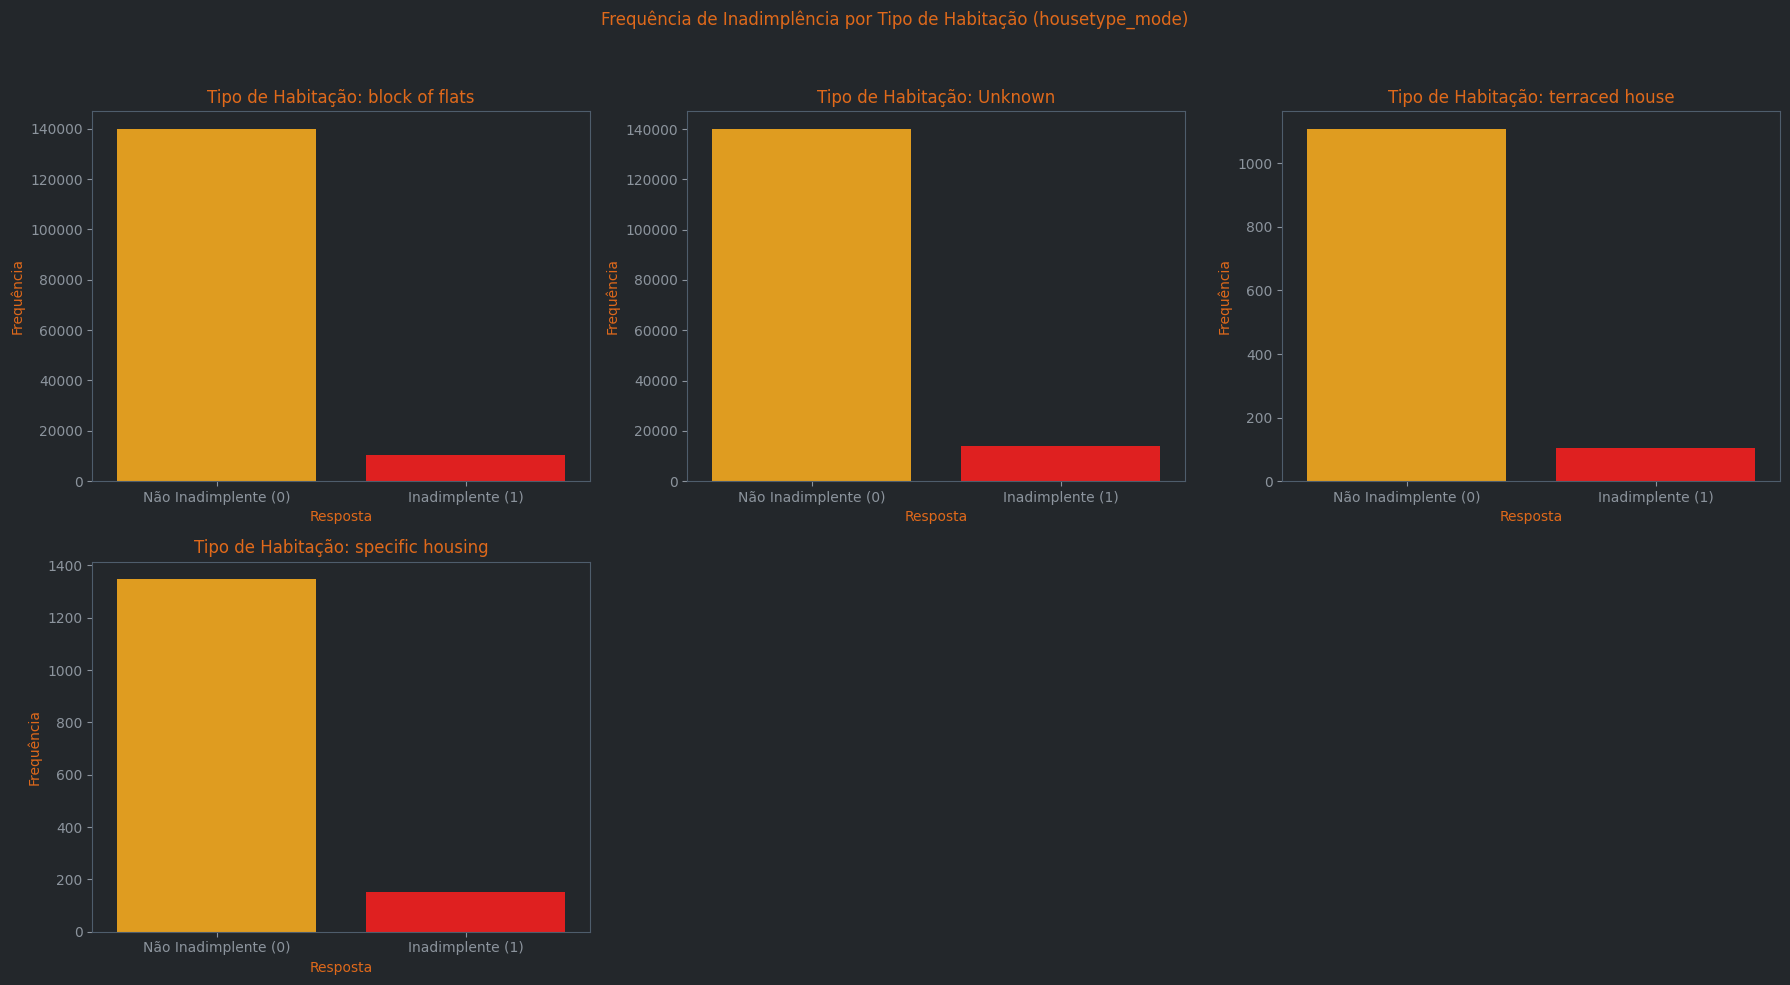

V de Cramer entre housetype_mode e target: 0.0407


In [ ]:
plot_target_by_categorical(df3, cat_col='housetype_mode', target_col='target')

calcular_cramers_v(df3, 'housetype_mode', 'target')

##### H43 — The main wall material of the property is associated with default risk. TRUE


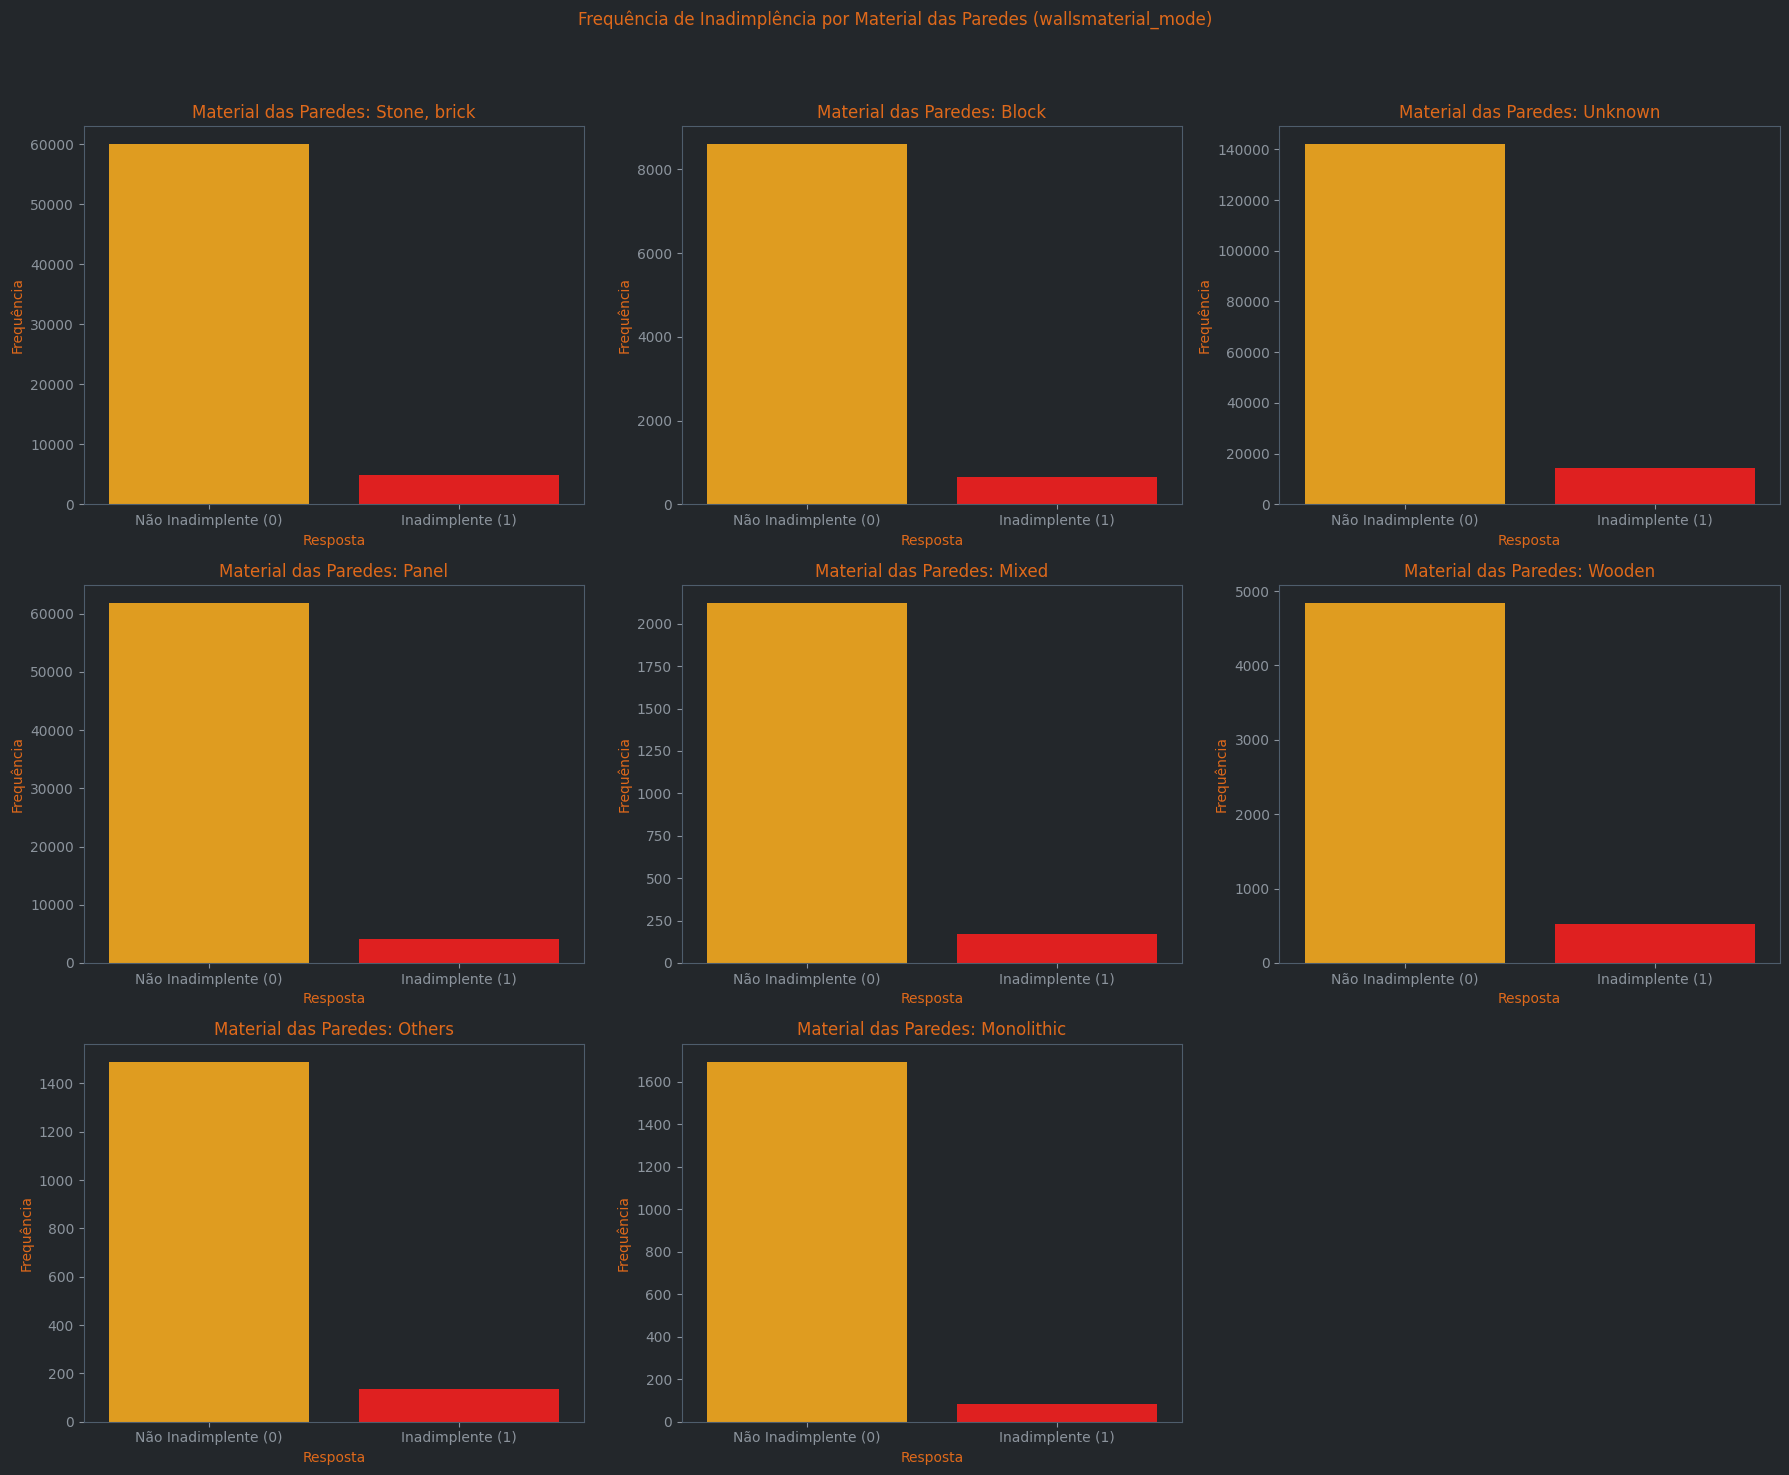

V de Cramer entre wallsmaterial_mode e target: 0.0441


In [ ]:
plot_target_by_categorical(df3, cat_col='wallsmaterial_mode', target_col='target')

calcular_cramers_v(df3, 'wallsmaterial_mode', 'target')

##### H44 — A higher number of observations or defaulters in the 30-day social circle increases the customer's probability of default. TRUE


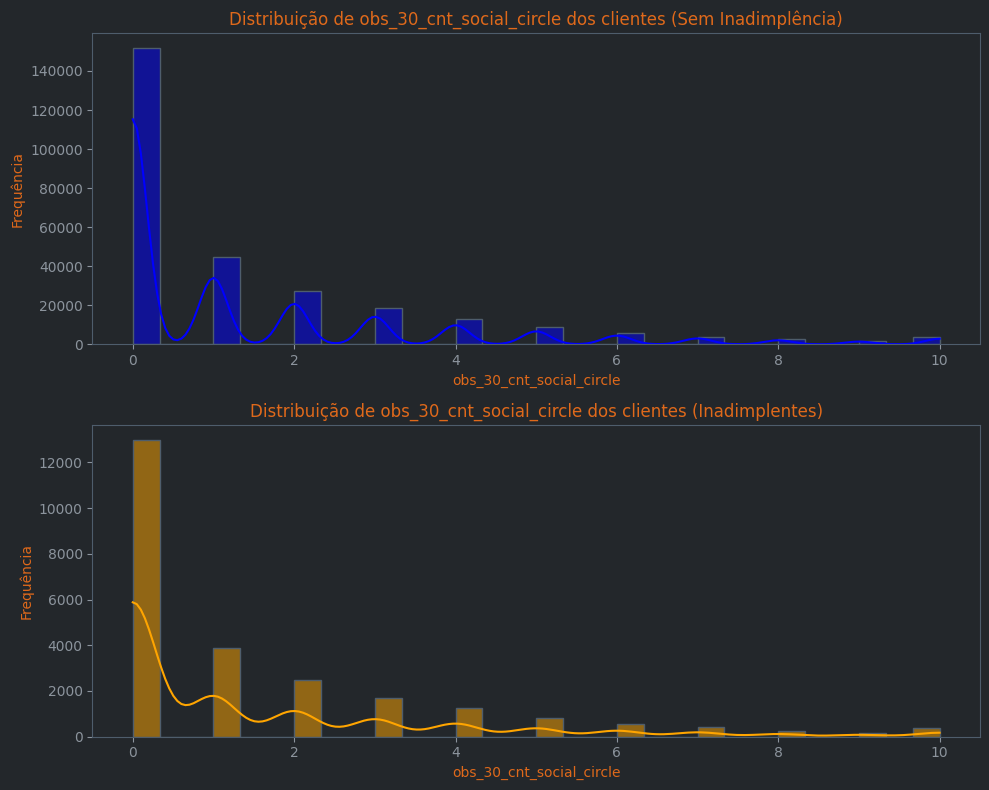

Correlação de Pearson entre obs_30_cnt_social_circle e target: 0.0104


In [ ]:
plot_num_var_by_target(
    df3,
    num_var='obs_30_cnt_social_circle',
    title_0='Distribuição de obs_30_cnt_social_circle dos clientes (Sem Inadimplência)',
    title_1='Distribuição de obs_30_cnt_social_circle dos clientes (Inadimplentes)',
    label_x='obs_30_cnt_social_circle',
    discrete=True
)
# Correlação de obs_30_cnt_social_circle com a target
pearson_corr = df3['obs_30_cnt_social_circle'].corr(df3['target'], method='pearson')
print(f"Correlação de Pearson entre obs_30_cnt_social_circle e target: {pearson_corr:.4f}")

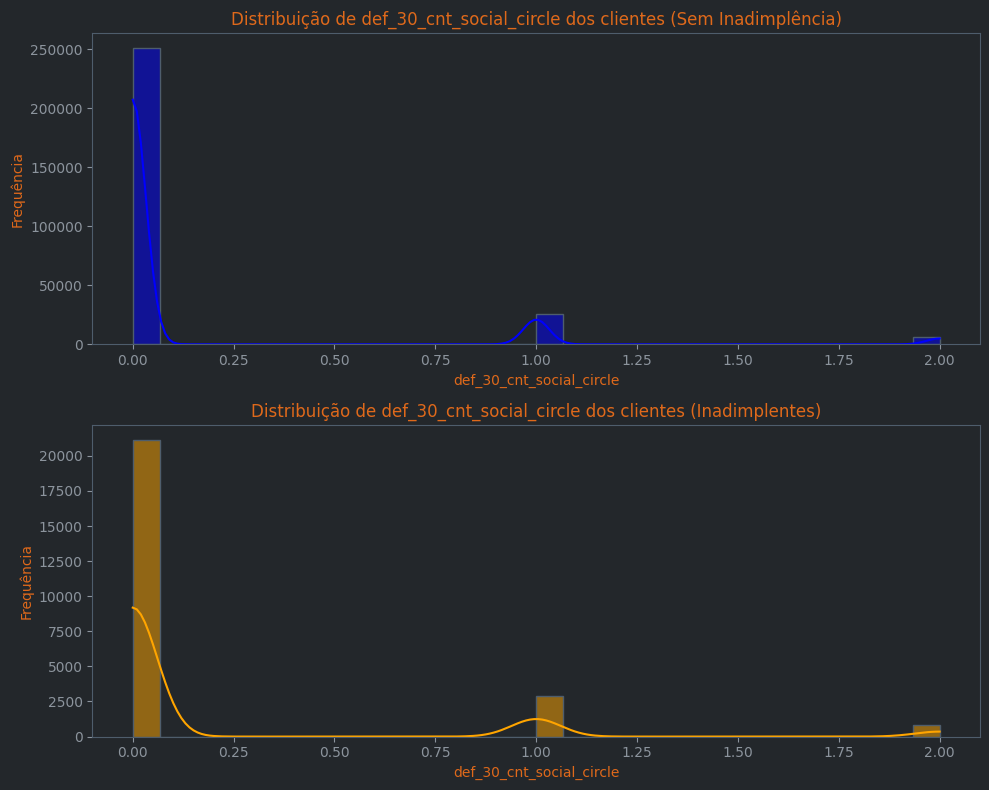

Correlação de Pearson entre def_30_cnt_social_circle e target: 0.0331


In [ ]:
plot_num_var_by_target(
    df3,
    num_var='def_30_cnt_social_circle',
    title_0='Distribuição de def_30_cnt_social_circle dos clientes (Sem Inadimplência)',
    title_1='Distribuição de def_30_cnt_social_circle dos clientes (Inadimplentes)',
    label_x='def_30_cnt_social_circle',
    discrete=True
)
# Correlação de def_30_cnt_social_circle com a target
pearson_corr = df3['def_30_cnt_social_circle'].corr(df3['target'], method='pearson')
print(f"Correlação de Pearson entre def_30_cnt_social_circle e target: {pearson_corr:.4f}")



##### H45 — Default in the 60-day social circle is positively associated with individual default risk. TRUE


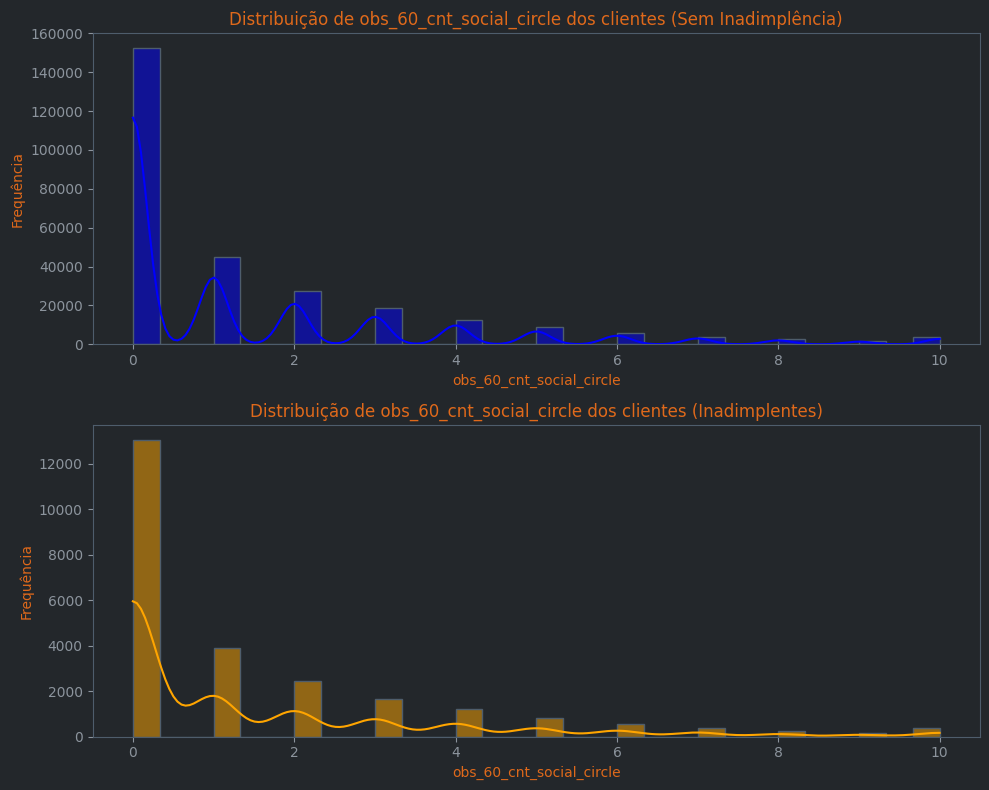

Correlação de Pearson entre obs_60_cnt_social_circle e target: 0.0103


In [ ]:
plot_num_var_by_target(
    df3,
    num_var='obs_60_cnt_social_circle',
    title_0='Distribuição de obs_60_cnt_social_circle dos clientes (Sem Inadimplência)',
    title_1='Distribuição de obs_60_cnt_social_circle dos clientes (Inadimplentes)',
    label_x='obs_60_cnt_social_circle',
    discrete=True
)

# Correlação de obs_60_cnt_social_circle com a target
pearson_corr = df3['obs_60_cnt_social_circle'].corr(df3['target'], method='pearson')
print(f"Correlação de Pearson entre obs_60_cnt_social_circle e target: {pearson_corr:.4f}")

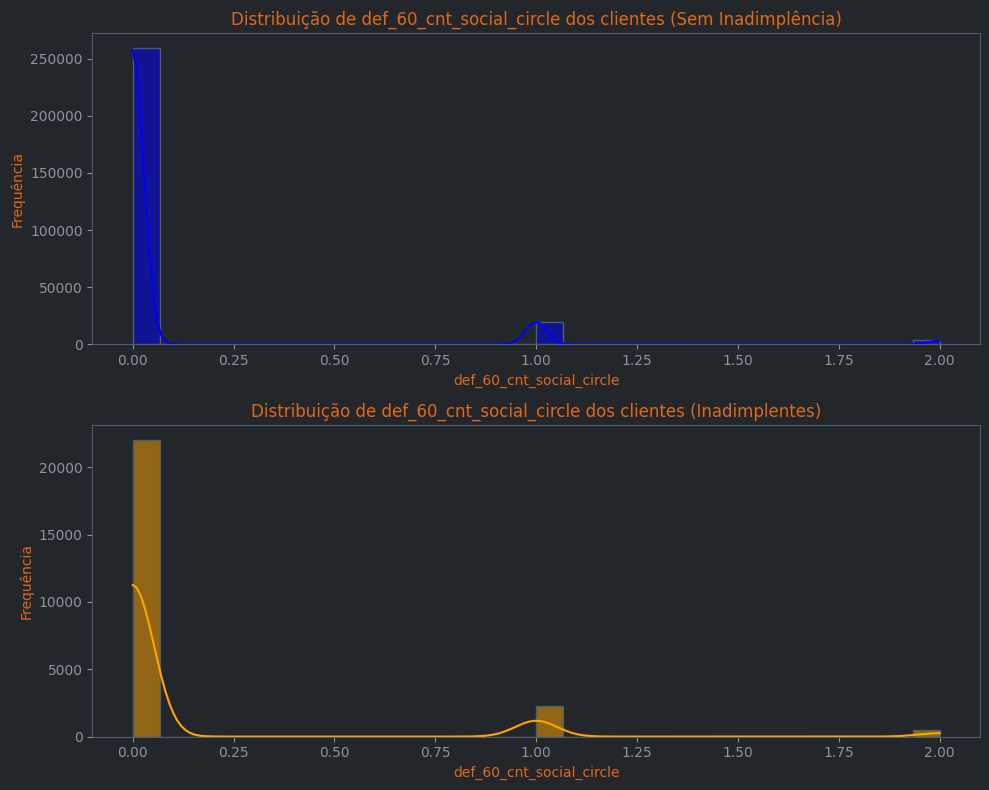

Correlação de Pearson entre def_60_cnt_social_circle e target: 0.0318


In [ ]:
plot_num_var_by_target(
    df3,
    num_var='def_60_cnt_social_circle',
    title_0='Distribuição de def_60_cnt_social_circle dos clientes (Sem Inadimplência)',
    title_1='Distribuição de def_60_cnt_social_circle dos clientes (Inadimplentes)',
    label_x='def_60_cnt_social_circle',
    discrete=True
)
# Correlação de def_60_cnt_social_circle com a target
pearson_corr = df3['def_60_cnt_social_circle'].corr(df3['target'], method='pearson')
print(f"Correlação de Pearson entre def_60_cnt_social_circle e target: {pearson_corr:.4f}")

##### H46 — The time since the last phone change is related to default probability. FALSE

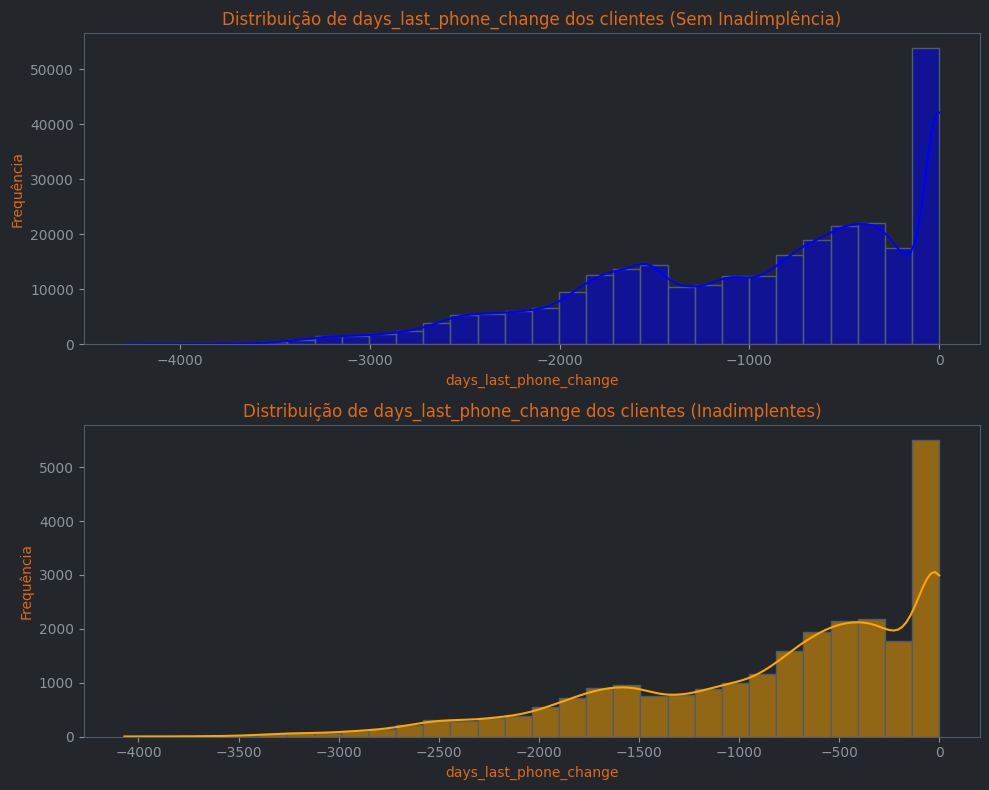

Correlação de Pearson entre days_last_phone_change e target: 0.0552


In [ ]:
plot_num_var_by_target(
    df3,
    num_var='days_last_phone_change',
    title_0='Distribuição de days_last_phone_change dos clientes (Sem Inadimplência)',
    title_1='Distribuição de days_last_phone_change dos clientes (Inadimplentes)',
    label_x='days_last_phone_change',
    discrete=True
)
# Correlação de days_last_phone_change com a target
pearson_corr = df3['days_last_phone_change'].corr(df3['target'], method='pearson')
print(f"Correlação de Pearson entre days_last_phone_change e target: {pearson_corr:.4f}")

##### H47 — The number of submitted documents is inversely associated with default. FALSE

flag_document_2

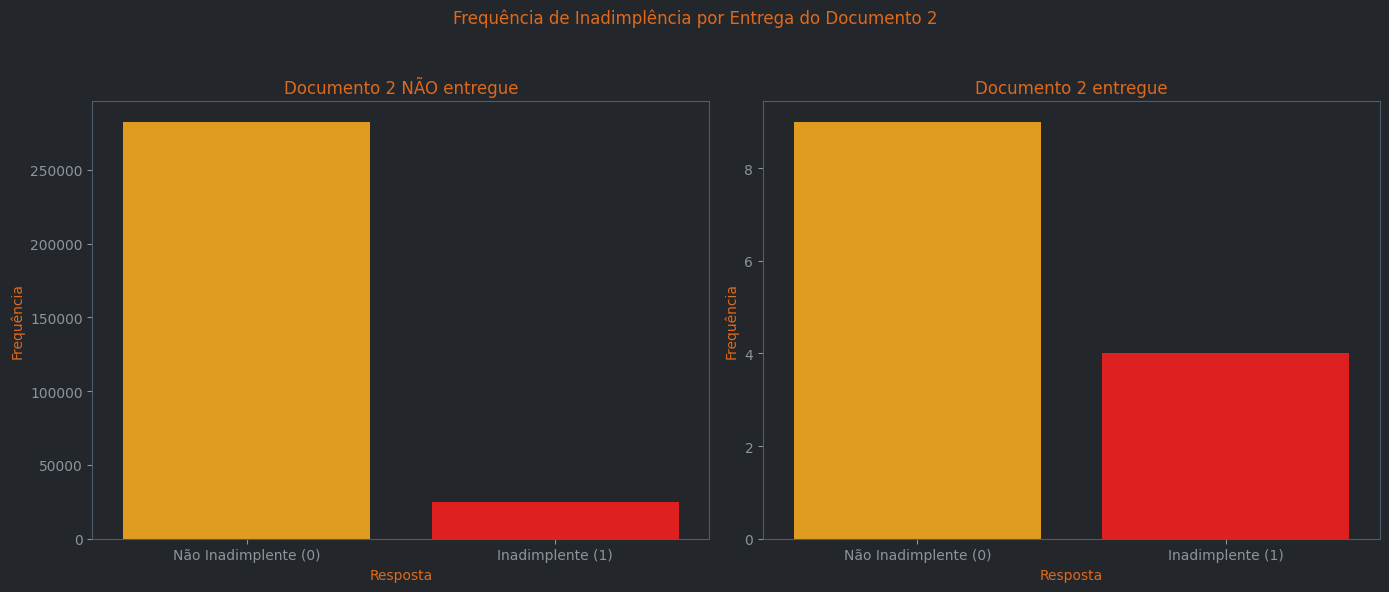

V de Cramer entre flag_document_2 e target: 0.0045


In [ ]:

plot_binaria_target(
    df3,
    var_binaria='flag_document_2',
    label_0='Documento 2 NÃO entregue',
    label_1='Documento 2 entregue',
    suptitle='Frequência de Inadimplência por Entrega do Documento 2'
)
calcular_cramers_v(df3, 'flag_document_2', 'target')


flag_document_3

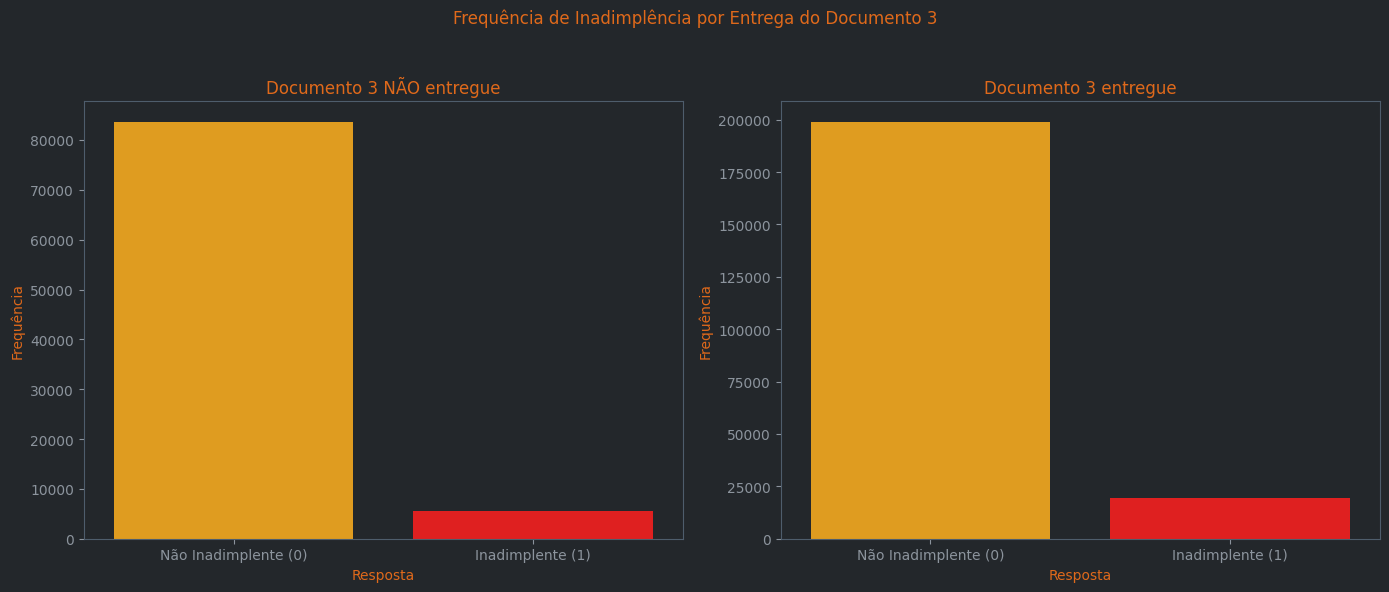

V de Cramer entre flag_document_3 e target: 0.0443


In [ ]:

plot_binaria_target(
    df3,
    var_binaria='flag_document_3',
    label_0='Documento 3 NÃO entregue',
    label_1='Documento 3 entregue',
    suptitle='Frequência de Inadimplência por Entrega do Documento 3'
)

calcular_cramers_v(df3, 'flag_document_3', 'target')


flag_document_4

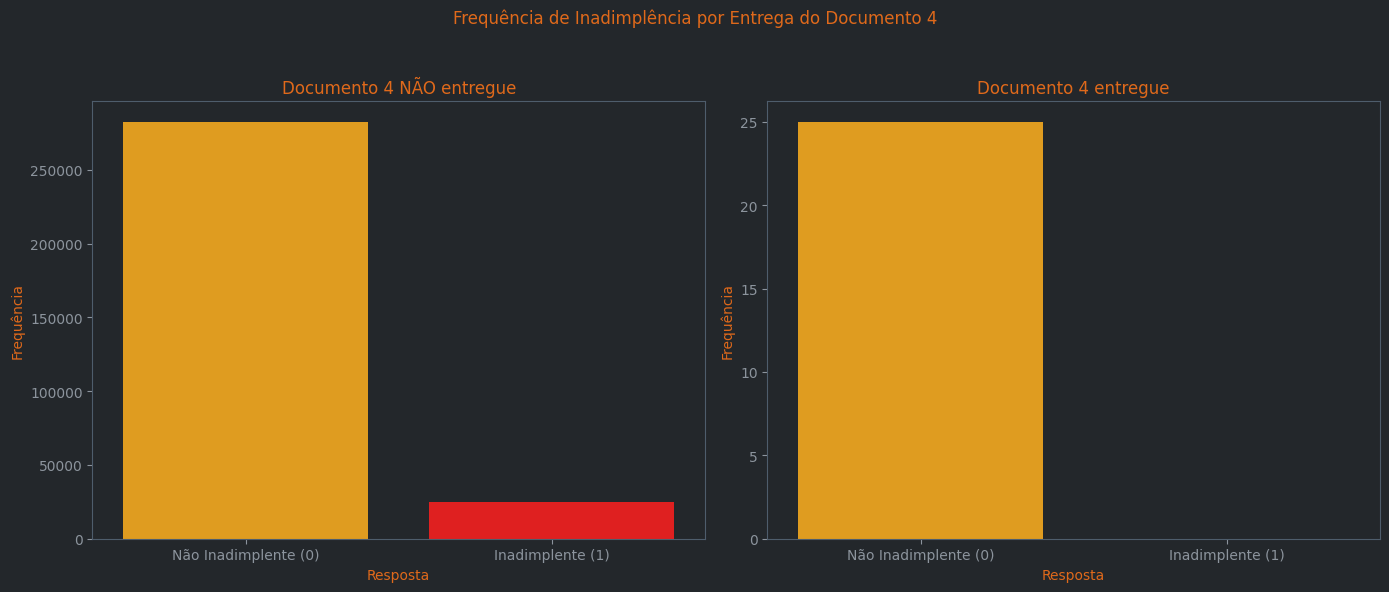

V de Cramer entre flag_document_4 e target: 0.0020


In [ ]:

plot_binaria_target(
    df3,
    var_binaria='flag_document_4',
    label_0='Documento 4 NÃO entregue',
    label_1='Documento 4 entregue',
    suptitle='Frequência de Inadimplência por Entrega do Documento 4'
)
calcular_cramers_v(df3, 'flag_document_4', 'target')


flag_document_5

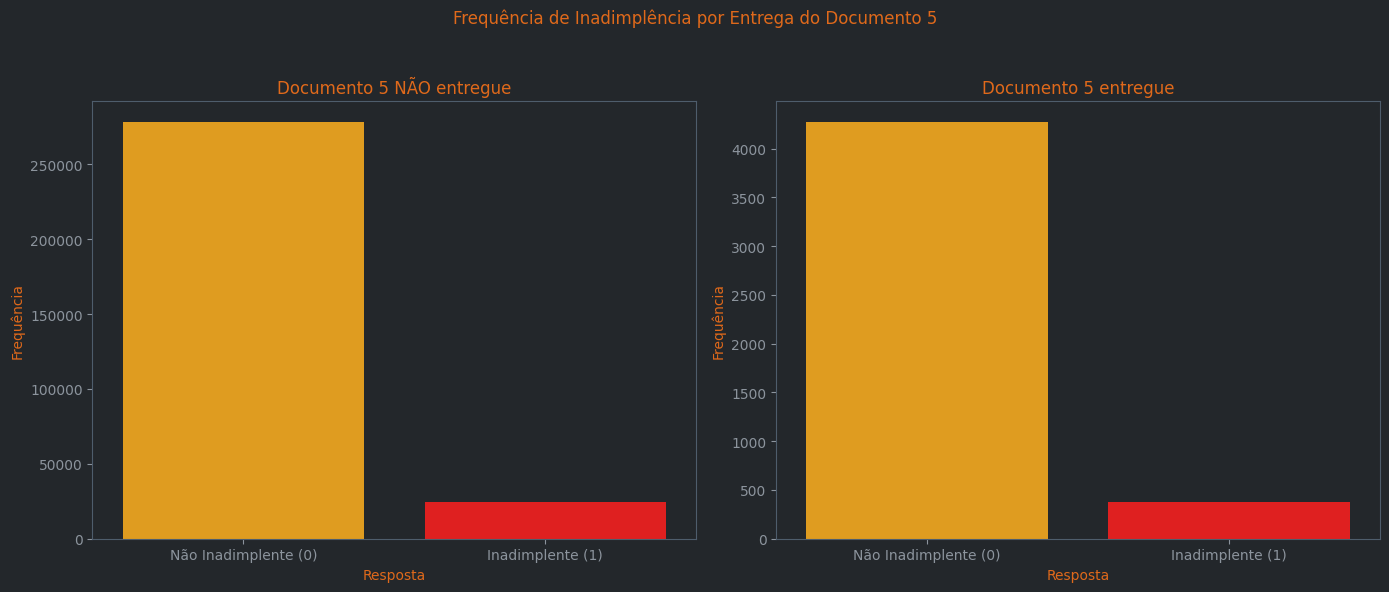

V de Cramer entre flag_document_5 e target: 0.0003


In [ ]:

plot_binaria_target(
    df3,
    var_binaria='flag_document_5',
    label_0='Documento 5 NÃO entregue',
    label_1='Documento 5 entregue',
    suptitle='Frequência de Inadimplência por Entrega do Documento 5'
)

calcular_cramers_v(df3, 'flag_document_5', 'target')


flag_document_6

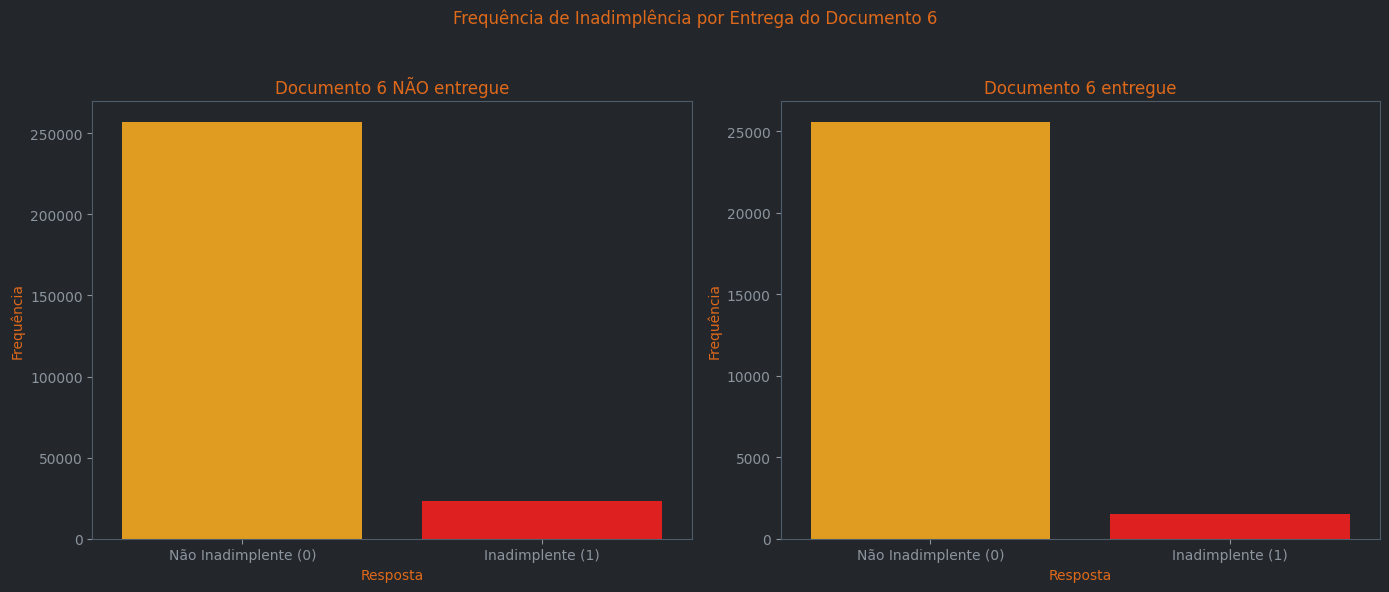

V de Cramer entre flag_document_6 e target: 0.0286


In [ ]:

plot_binaria_target(
    df3,
    var_binaria='flag_document_6',
    label_0='Documento 6 NÃO entregue',
    label_1='Documento 6 entregue',
    suptitle='Frequência de Inadimplência por Entrega do Documento 6'
)


calcular_cramers_v(df3, 'flag_document_6', 'target')


flag_document_7

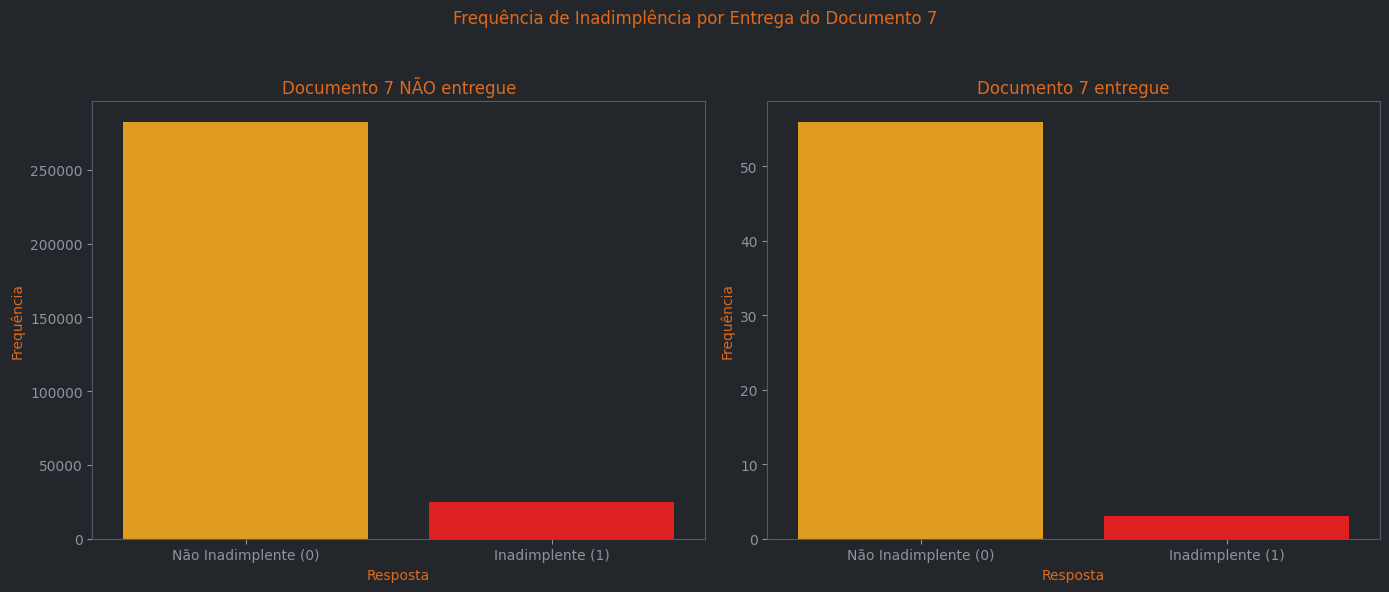

V de Cramer entre flag_document_7 e target: 0.0011


In [ ]:

plot_binaria_target(
    df3,
    var_binaria='flag_document_7',
    label_0='Documento 7 NÃO entregue',
    label_1='Documento 7 entregue',
    suptitle='Frequência de Inadimplência por Entrega do Documento 7'
)


calcular_cramers_v(df3, 'flag_document_7', 'target')


flag_document_8

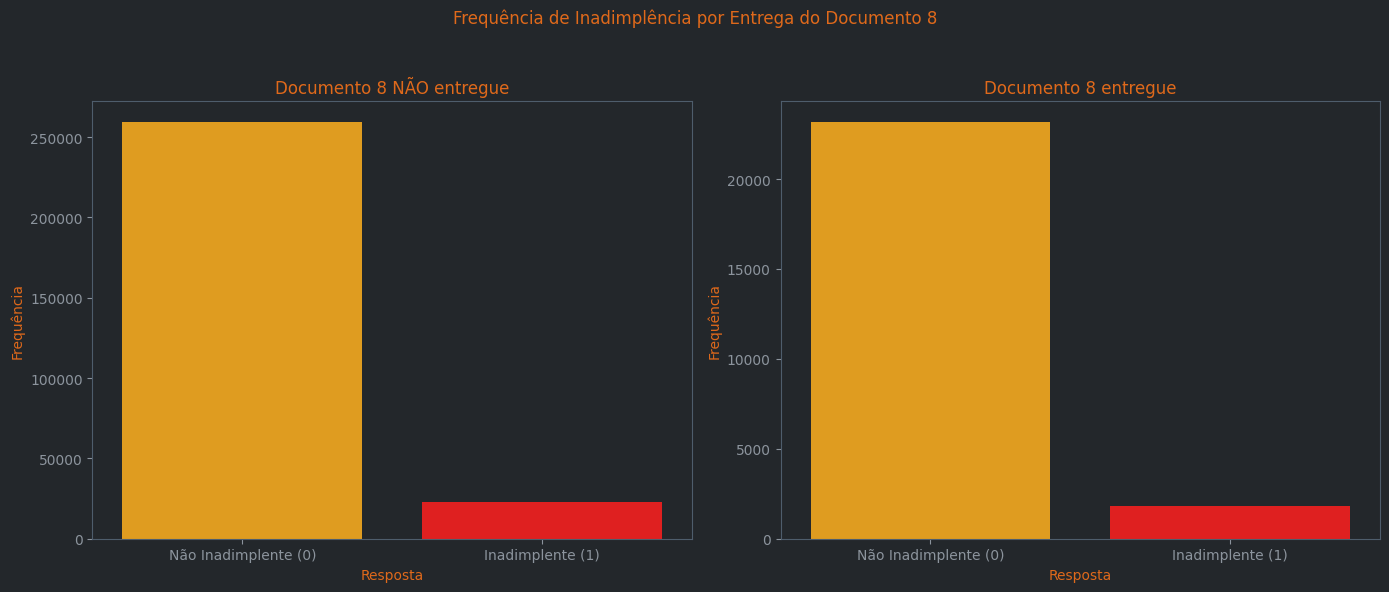

V de Cramer entre flag_document_8 e target: 0.0080


In [ ]:

plot_binaria_target(
    df3,
    var_binaria='flag_document_8',
    label_0='Documento 8 NÃO entregue',
    label_1='Documento 8 entregue',
    suptitle='Frequência de Inadimplência por Entrega do Documento 8'
)

calcular_cramers_v(df3, 'flag_document_8', 'target')


flag_document_9

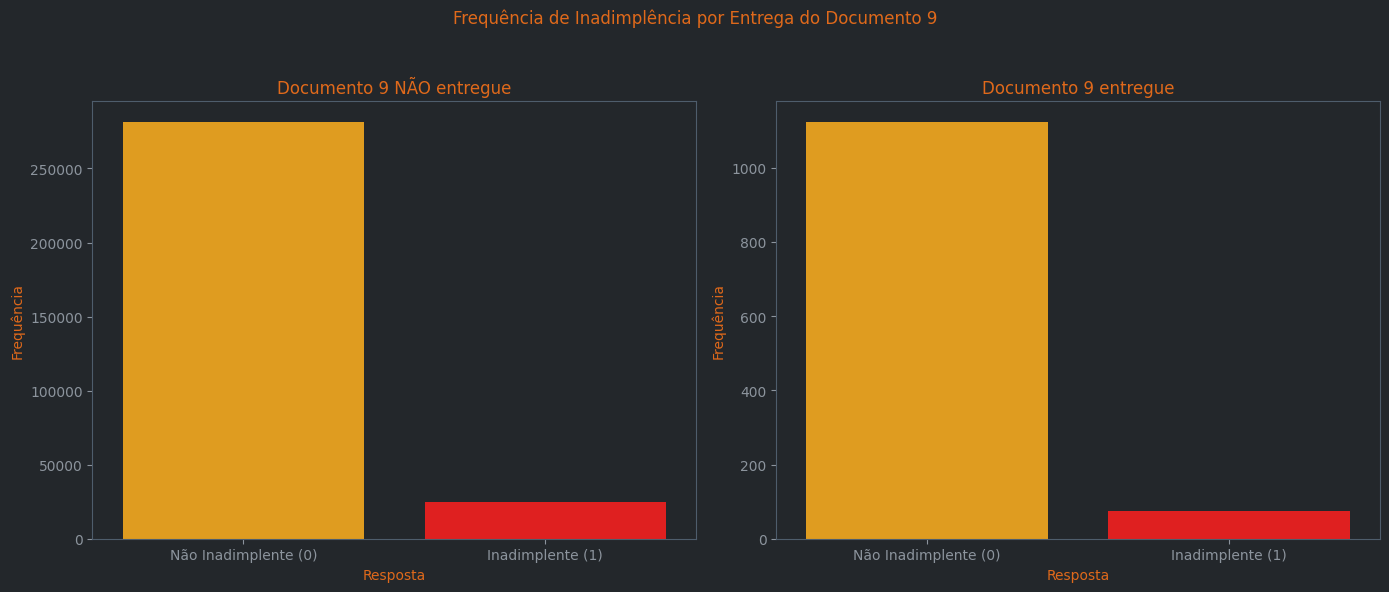

V de Cramer entre flag_document_9 e target: 0.0043


In [ ]:

plot_binaria_target(
    df3,
    var_binaria='flag_document_9',
    label_0='Documento 9 NÃO entregue',
    label_1='Documento 9 entregue',
    suptitle='Frequência de Inadimplência por Entrega do Documento 9'
)

calcular_cramers_v(df3, 'flag_document_9', 'target')


flag_document_10

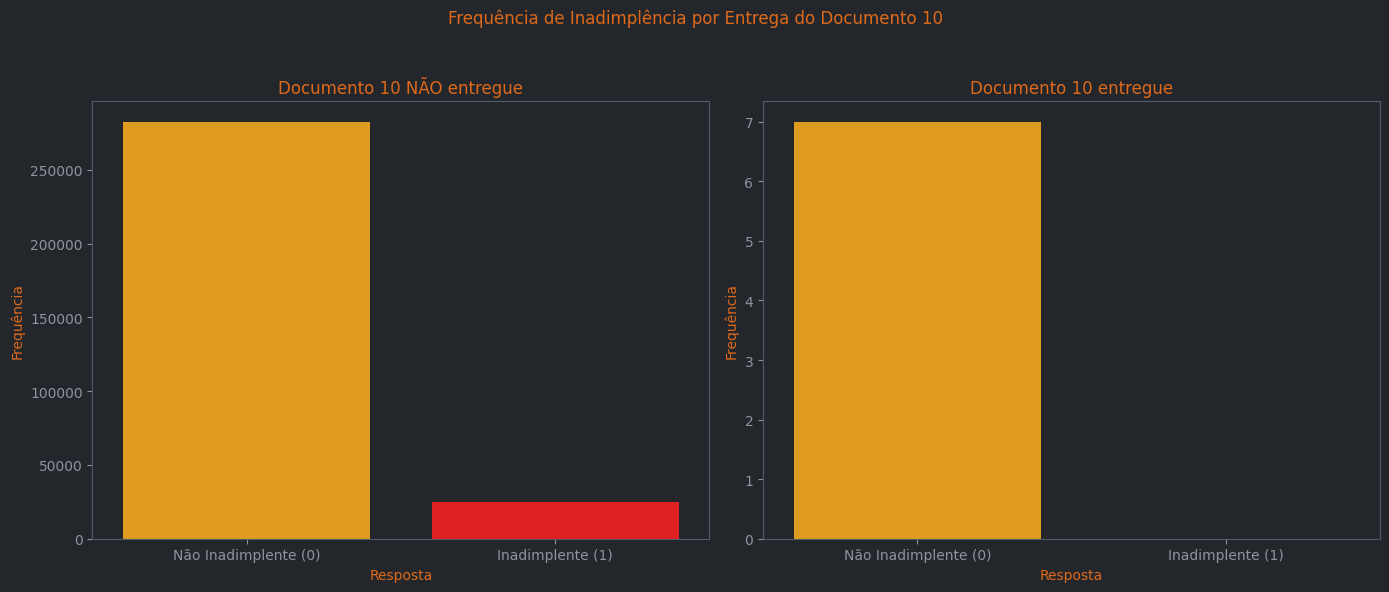

V de Cramer entre flag_document_10 e target: 0.0002


In [ ]:

plot_binaria_target(
    df3,
    var_binaria='flag_document_10',
    label_0='Documento 10 NÃO entregue',
    label_1='Documento 10 entregue',
    suptitle='Frequência de Inadimplência por Entrega do Documento 10'
)

calcular_cramers_v(df3, 'flag_document_10', 'target')


flag_document_11

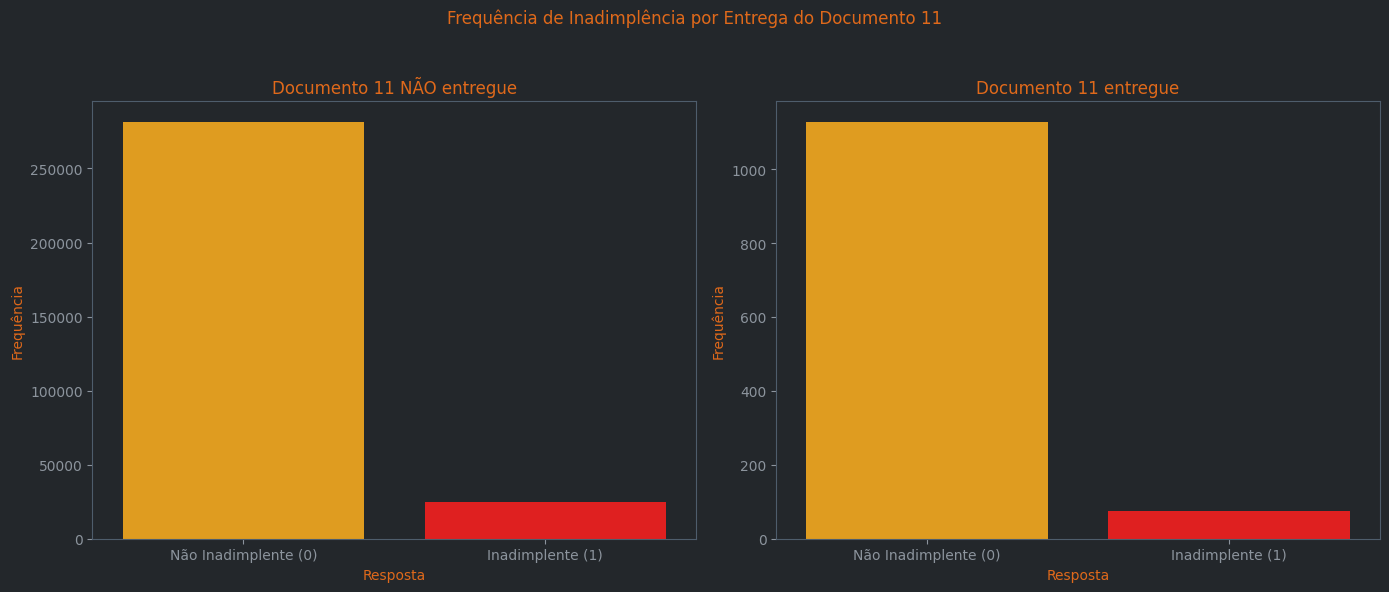

V de Cramer entre flag_document_11 e target: 0.0041


In [ ]:

plot_binaria_target(
    df3,
    var_binaria='flag_document_11',
    label_0='Documento 11 NÃO entregue',
    label_1='Documento 11 entregue',
    suptitle='Frequência de Inadimplência por Entrega do Documento 11'
)


calcular_cramers_v(df3, 'flag_document_11', 'target')


flag_document_12


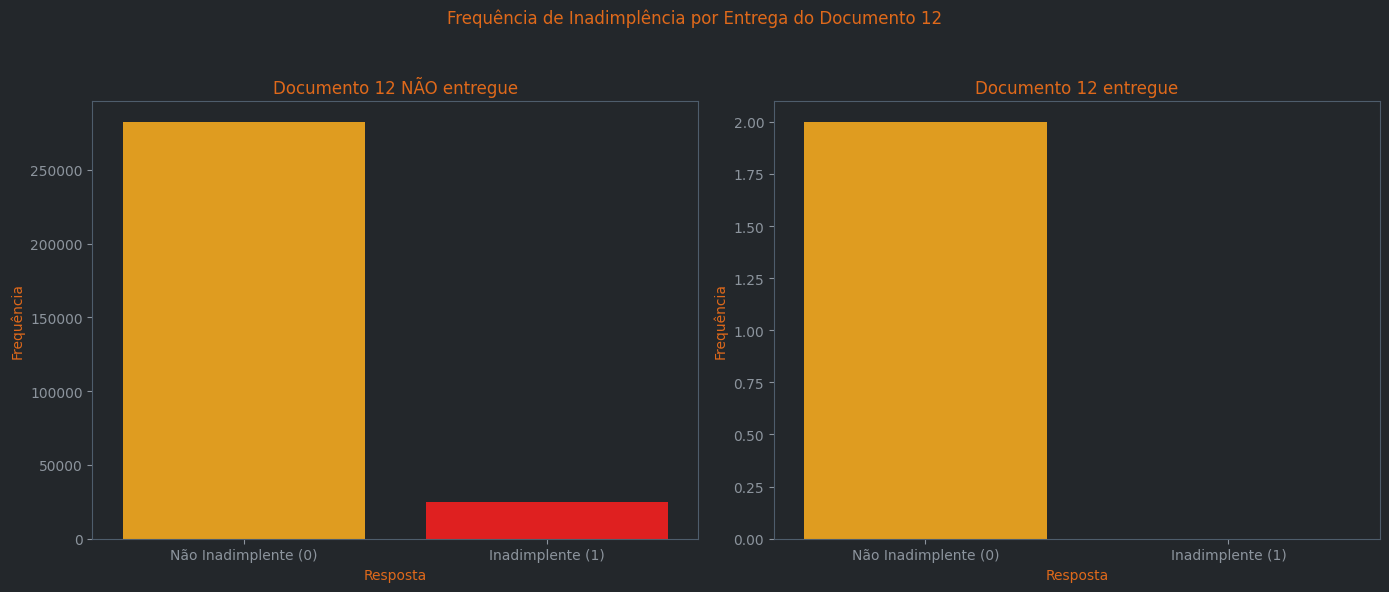

V de Cramer entre flag_document_12 e target: 0.0000


In [ ]:

plot_binaria_target(
    df3,
    var_binaria='flag_document_12',
    label_0='Documento 12 NÃO entregue',
    label_1='Documento 12 entregue',
    suptitle='Frequência de Inadimplência por Entrega do Documento 12'
)

calcular_cramers_v(df3, 'flag_document_12', 'target')


flag_document_13

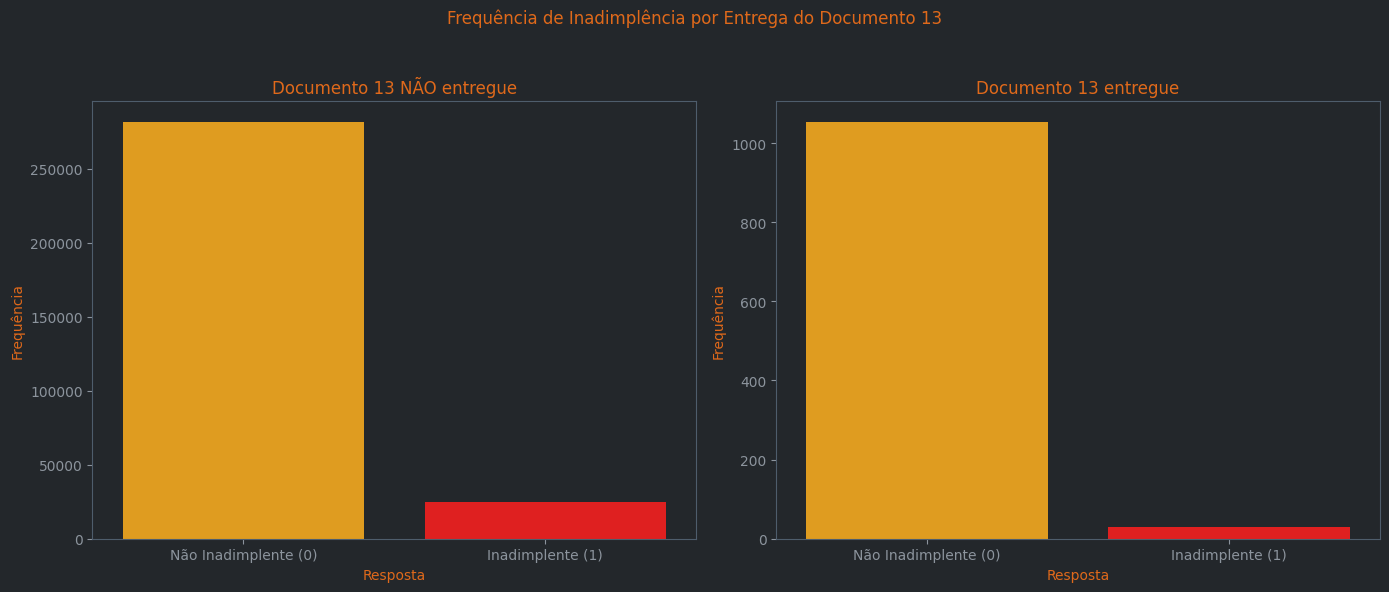

V de Cramer entre flag_document_13 e target: 0.0115


In [ ]:

plot_binaria_target(
    df3,
    var_binaria='flag_document_13',
    label_0='Documento 13 NÃO entregue',
    label_1='Documento 13 entregue',
    suptitle='Frequência de Inadimplência por Entrega do Documento 13'
)
calcular_cramers_v(df3, 'flag_document_13', 'target')


flag_document_14

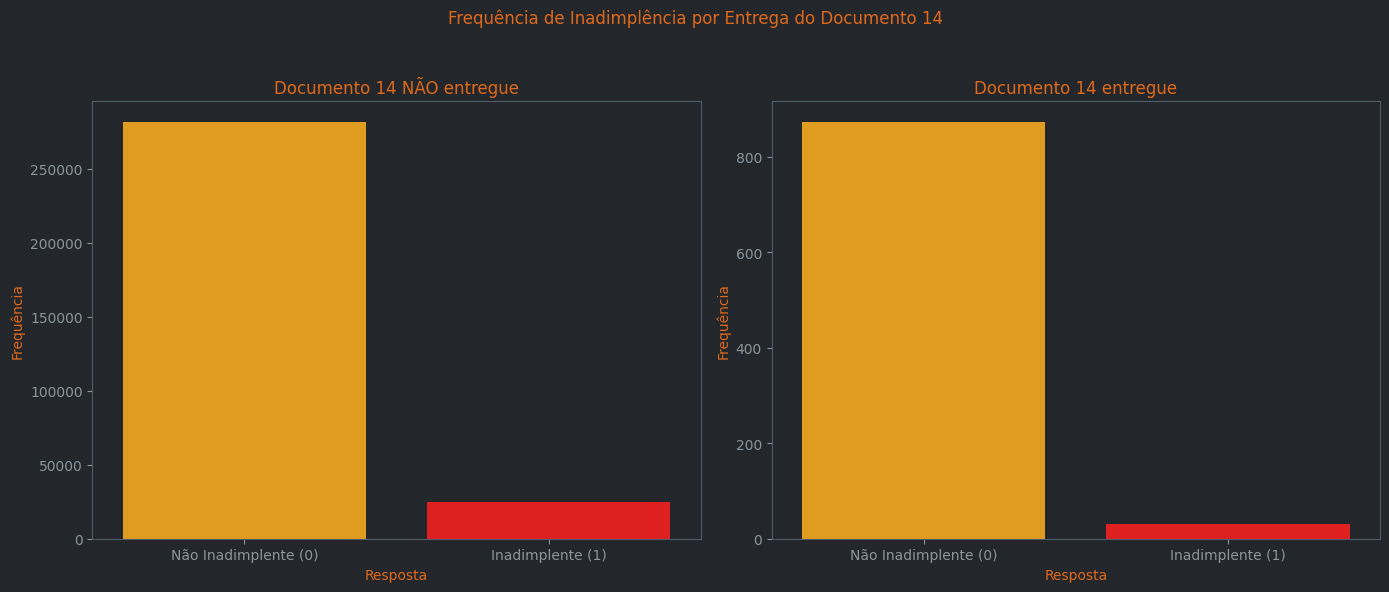

V de Cramer entre flag_document_14 e target: 0.0094


In [ ]:

plot_binaria_target(
    df3,
    var_binaria='flag_document_14',
    label_0='Documento 14 NÃO entregue',
    label_1='Documento 14 entregue',
    suptitle='Frequência de Inadimplência por Entrega do Documento 14'
)
calcular_cramers_v(df3, 'flag_document_14', 'target')


flag_document_15

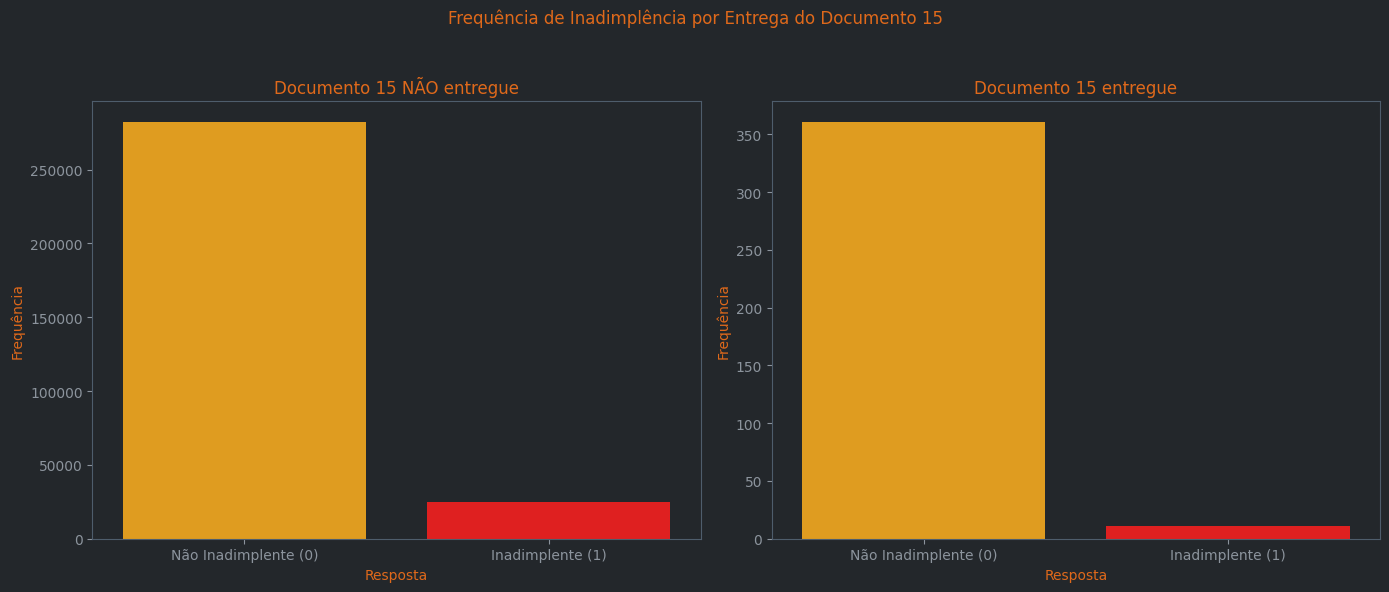

V de Cramer entre flag_document_15 e target: 0.0064


In [ ]:

plot_binaria_target(
    df3,
    var_binaria='flag_document_15',
    label_0='Documento 15 NÃO entregue',
    label_1='Documento 15 entregue',
    suptitle='Frequência de Inadimplência por Entrega do Documento 15'
)
calcular_cramers_v(df3, 'flag_document_15', 'target')


flag_document_16

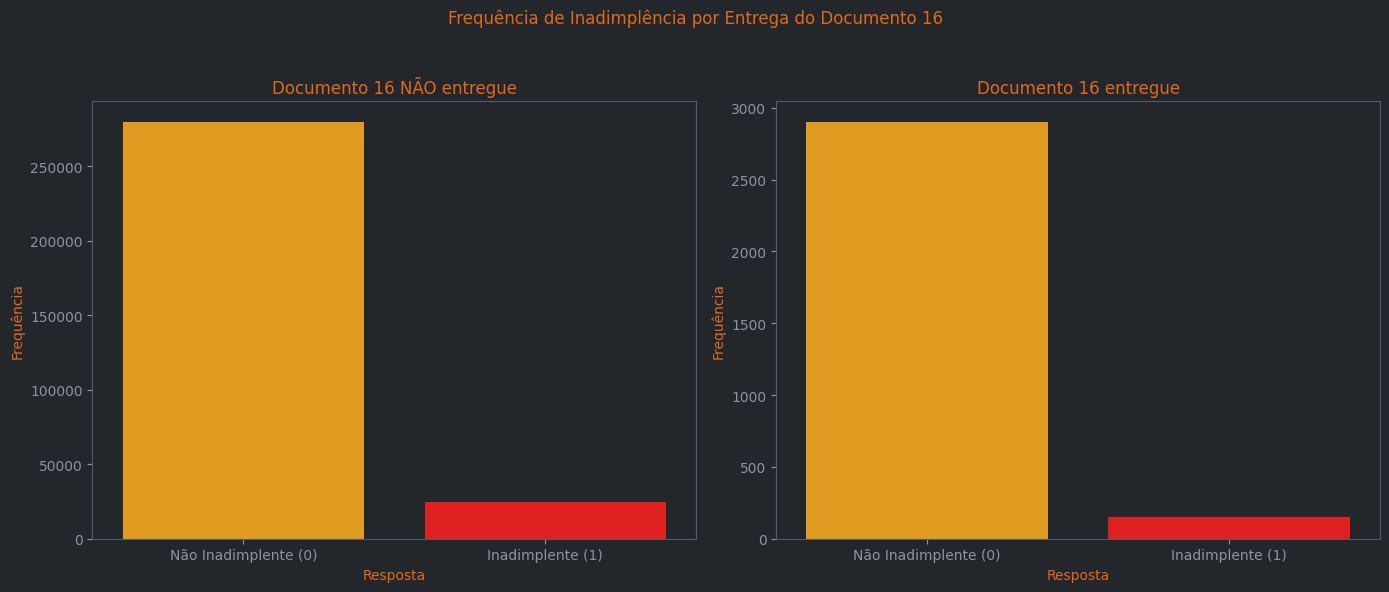

V de Cramer entre flag_document_16 e target: 0.0116


In [ ]:

plot_binaria_target(
    df3,
    var_binaria='flag_document_16',
    label_0='Documento 16 NÃO entregue',
    label_1='Documento 16 entregue',
    suptitle='Frequência de Inadimplência por Entrega do Documento 16'
)

calcular_cramers_v(df3, 'flag_document_16', 'target')


flag_document_17

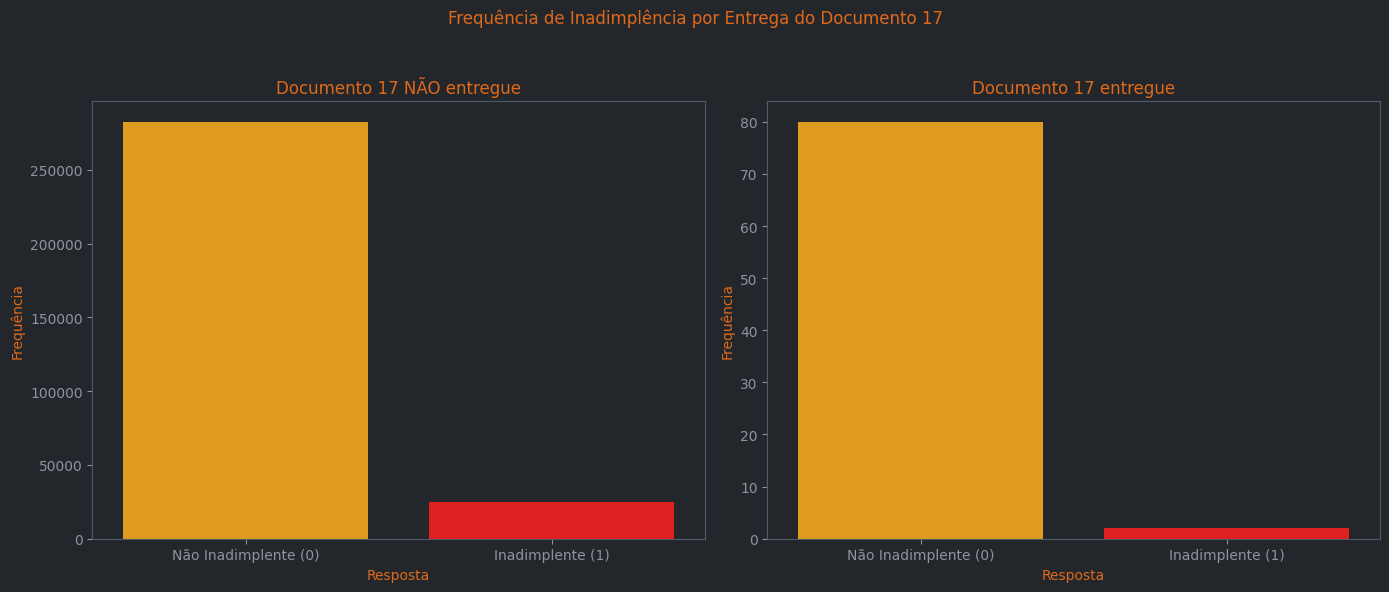

V de Cramer entre flag_document_17 e target: 0.0030


In [ ]:

plot_binaria_target(
    df3,
    var_binaria='flag_document_17',
    label_0='Documento 17 NÃO entregue',
    label_1='Documento 17 entregue',
    suptitle='Frequência de Inadimplência por Entrega do Documento 17'
)
calcular_cramers_v(df3, 'flag_document_17', 'target')


flag_document_18

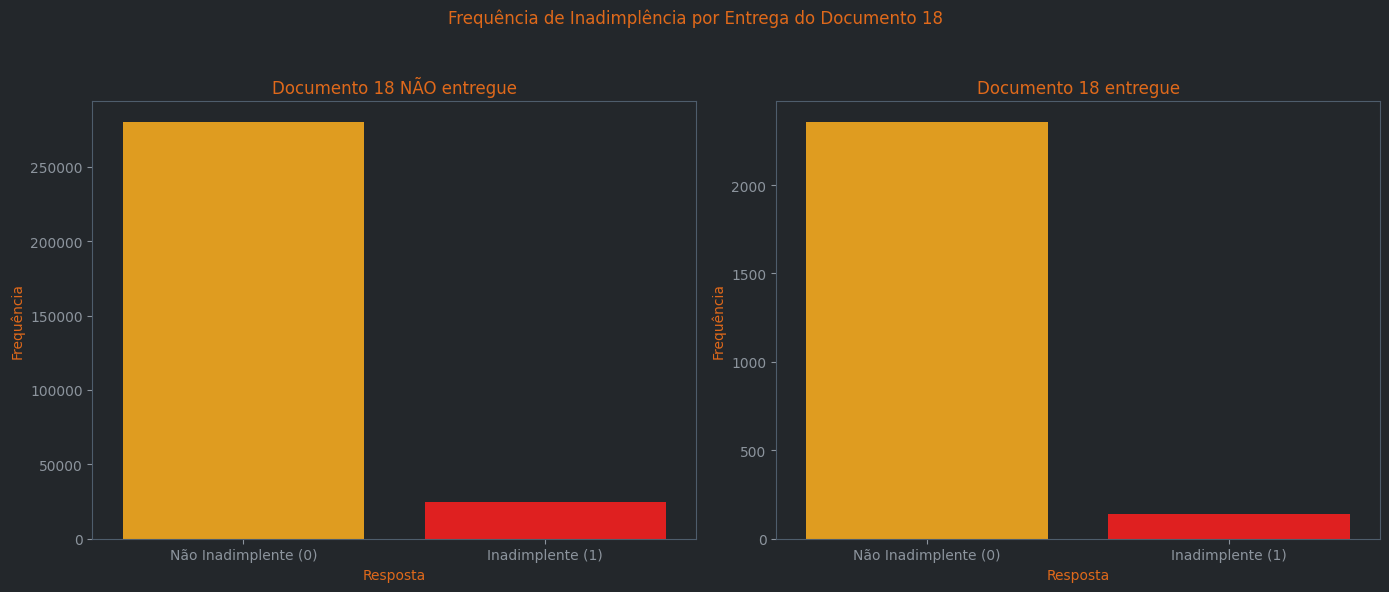

V de Cramer entre flag_document_18 e target: 0.0079


In [ ]:

plot_binaria_target(
    df3,
    var_binaria='flag_document_18',
    label_0='Documento 18 NÃO entregue',
    label_1='Documento 18 entregue',
    suptitle='Frequência de Inadimplência por Entrega do Documento 18'
)

calcular_cramers_v(df3, 'flag_document_18', 'target')


flag_document_19

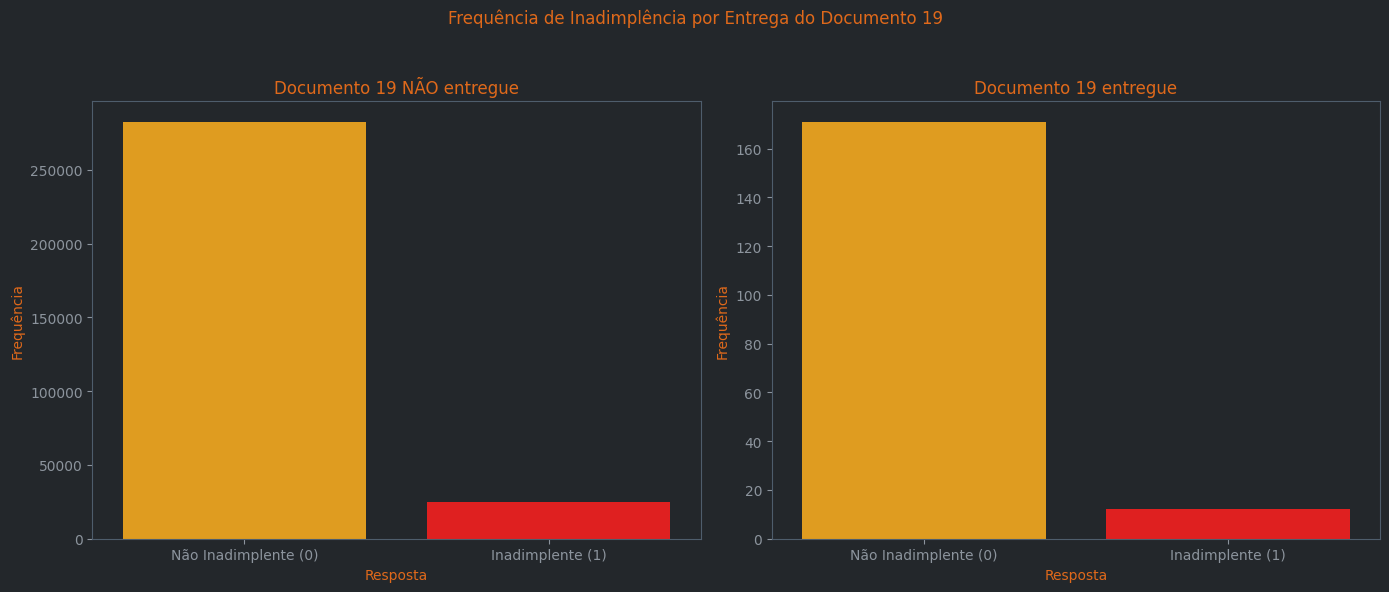

V de Cramer entre flag_document_19 e target: 0.0011


In [ ]:

plot_binaria_target(
    df3,
    var_binaria='flag_document_19',
    label_0='Documento 19 NÃO entregue',
    label_1='Documento 19 entregue',
    suptitle='Frequência de Inadimplência por Entrega do Documento 19'
)

calcular_cramers_v(df3, 'flag_document_19', 'target')


flag_document_20

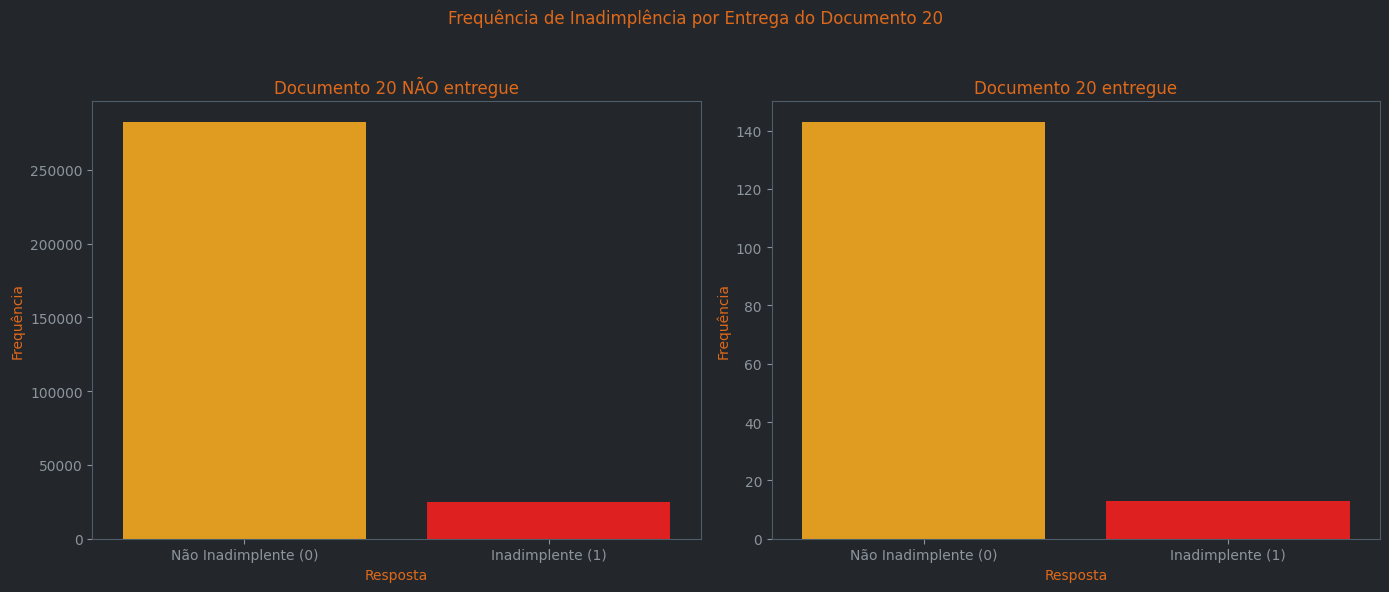

V de Cramer entre flag_document_20 e target: 0.0000


In [ ]:

plot_binaria_target(
    df3,
    var_binaria='flag_document_20',
    label_0='Documento 20 NÃO entregue',
    label_1='Documento 20 entregue',
    suptitle='Frequência de Inadimplência por Entrega do Documento 20'
)

calcular_cramers_v(df3, 'flag_document_20', 'target')


flag_document_21

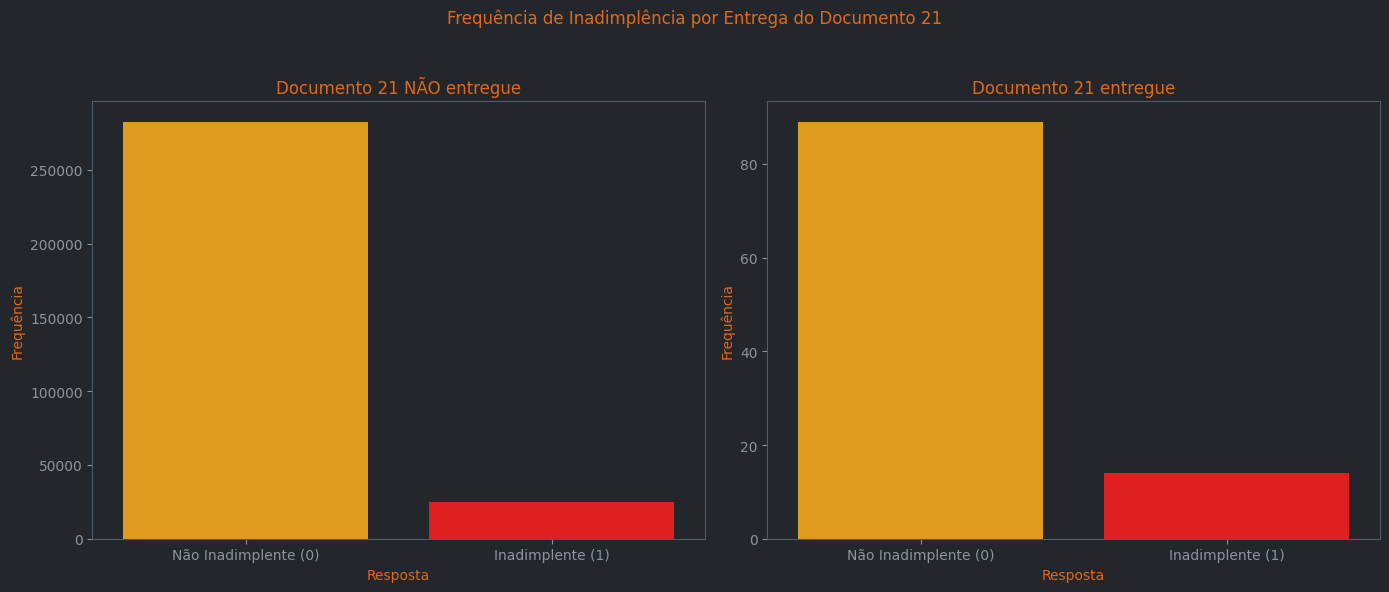

V de Cramer entre flag_document_21 e target: 0.0034


In [ ]:

plot_binaria_target(
    df3,
    var_binaria='flag_document_21',
    label_0='Documento 21 NÃO entregue',
    label_1='Documento 21 entregue',
    suptitle='Frequência de Inadimplência por Entrega do Documento 21'
)
calcular_cramers_v(df3, 'flag_document_21', 'target')


#### Block 4 Hypotesis

##### H48 — Credit inquiry history and credit amounts influence the probability of default. TRUE

amt_req_credit_bureau_hour

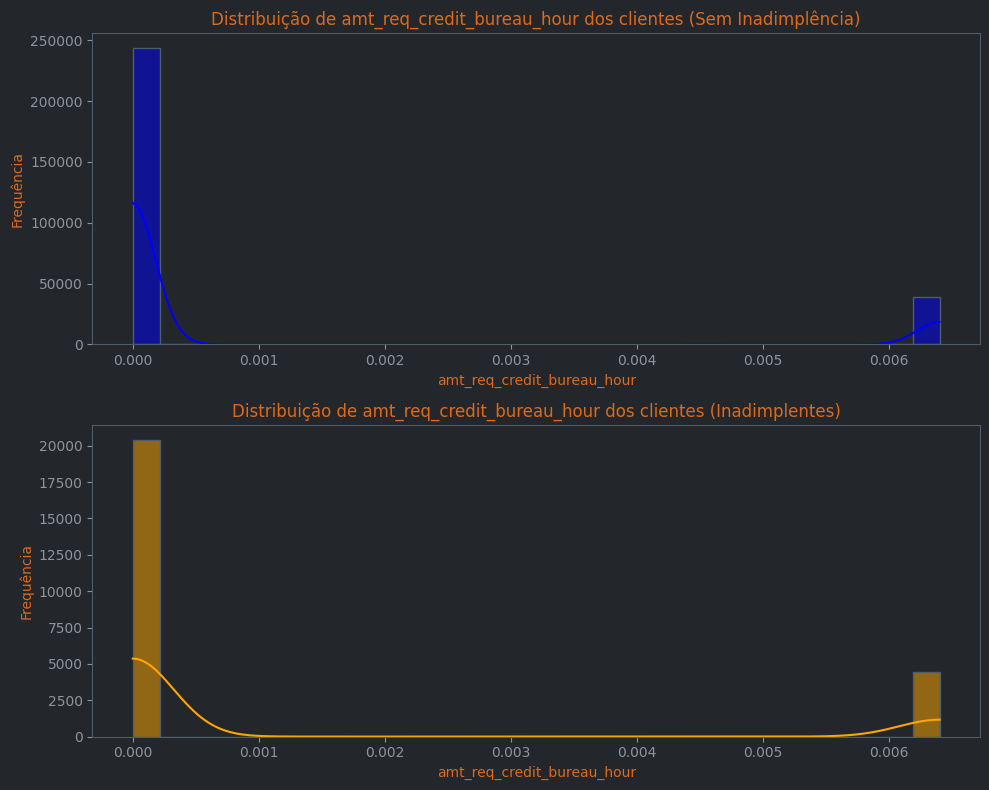

Correlação de Pearson entre amt_req_credit_bureau_hour e target: 0.0323


In [ ]:
plot_num_var_by_target(
    df3,
    num_var='amt_req_credit_bureau_hour',
    title_0='Distribuição de amt_req_credit_bureau_hour dos clientes (Sem Inadimplência)',
    title_1='Distribuição de amt_req_credit_bureau_hour dos clientes (Inadimplentes)',
    label_x='amt_req_credit_bureau_hour',
    discrete=True
)

# Correlação de amt_req_credit_bureau_hour com a target
pearson_corr = df3['amt_req_credit_bureau_hour'].corr(df3['target'], method='pearson')
print(f"Correlação de Pearson entre amt_req_credit_bureau_hour e target: {pearson_corr:.4f}")

amt_req_credit_bureau_day

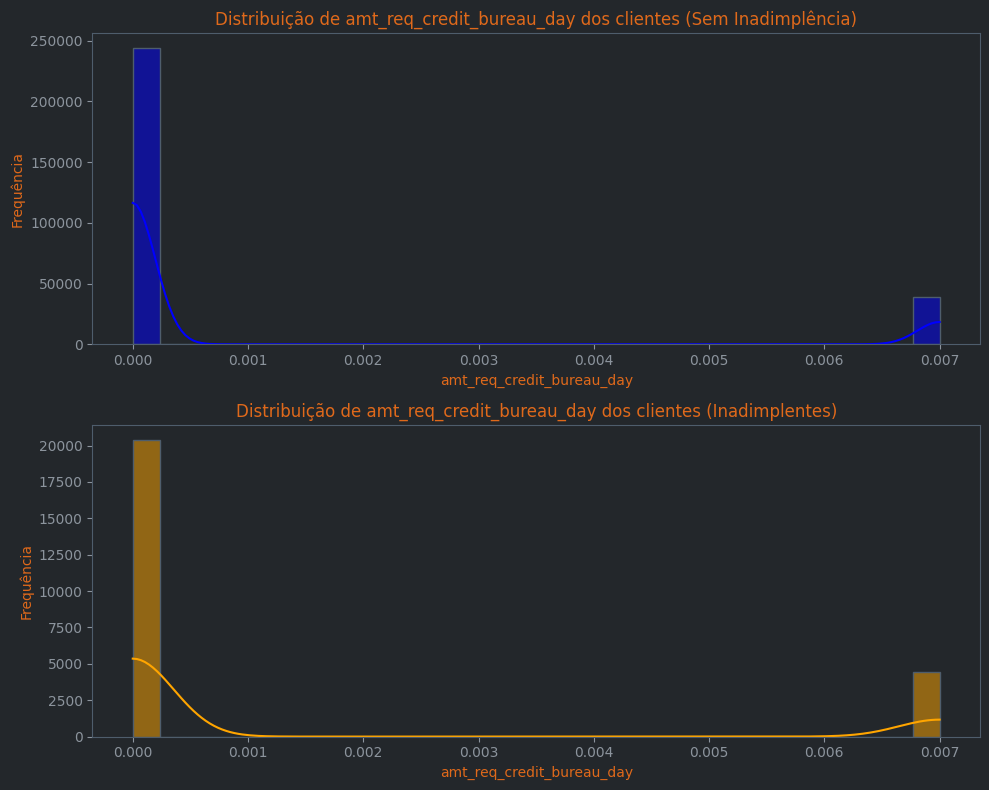

Correlação de Pearson entre amt_req_credit_bureau_day e target: 0.0331


In [ ]:

fig, axes = plt.subplots(2, 1, figsize=(10, 8), sharey=False)

sns.histplot(
    data=df3[df3['target'] == 0],
    x='amt_req_credit_bureau_day',
    color='blue',
    ax=axes[0],
    kde=True,
    bins=30
)
axes[0].set_title('Distribuição de amt_req_credit_bureau_day dos clientes (Sem Inadimplência)')
axes[0].set_ylabel('Frequência')
axes[0].set_xlabel('amt_req_credit_bureau_day')

sns.histplot(
    data=df3[df3['target'] == 1],
    x='amt_req_credit_bureau_day',
    color='orange',
    ax=axes[1],
    kde=True,
    bins=30
)
axes[1].set_title('Distribuição de amt_req_credit_bureau_day dos clientes (Inadimplentes)')
axes[1].set_ylabel('Frequência')
axes[1].set_xlabel('amt_req_credit_bureau_day')

plt.tight_layout()
plt.show()


pearson_corr = df3['amt_req_credit_bureau_day'].corr(df3['target'], method='pearson')
print(f"Correlação de Pearson entre amt_req_credit_bureau_day e target: {pearson_corr:.4f}")

amt_req_credit_bureau_week

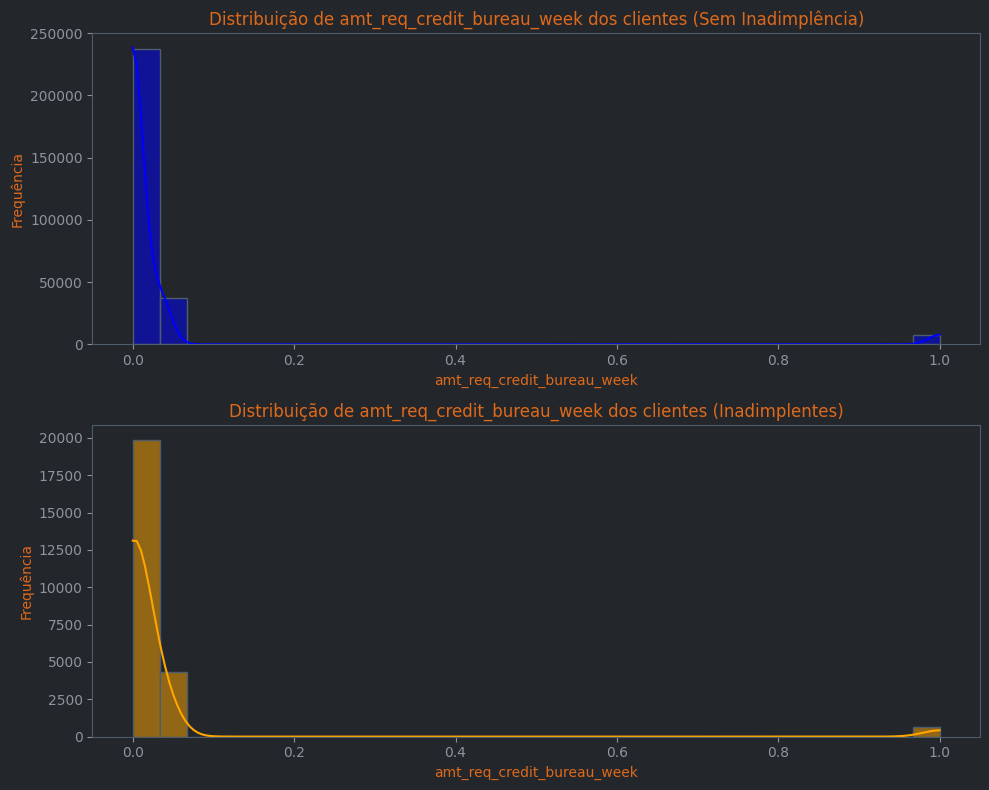

Correlação de Pearson entre amt_req_credit_bureau_week e target: 0.0008


In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(10, 8), sharey=False)

sns.histplot(
    data=df3[df3['target'] == 0],
    x='amt_req_credit_bureau_week',
    color='blue',
    ax=axes[0],
    kde=True,
    bins=30
)
axes[0].set_title('Distribuição de amt_req_credit_bureau_week dos clientes (Sem Inadimplência)')
axes[0].set_ylabel('Frequência')
axes[0].set_xlabel('amt_req_credit_bureau_week')


sns.histplot(
    data=df3[df3['target'] == 1],
    x='amt_req_credit_bureau_week',
    color='orange',
    ax=axes[1],
    kde=True,
    bins=30
)
axes[1].set_title('Distribuição de amt_req_credit_bureau_week dos clientes (Inadimplentes)')
axes[1].set_ylabel('Frequência')
axes[1].set_xlabel('amt_req_credit_bureau_week')

plt.tight_layout()
plt.show()


pearson_corr = df3['amt_req_credit_bureau_week'].corr(df3['target'], method='pearson')
print(f"Correlação de Pearson entre amt_req_credit_bureau_week e target: {pearson_corr:.4f}")

amt_req_credit_bureau_mon

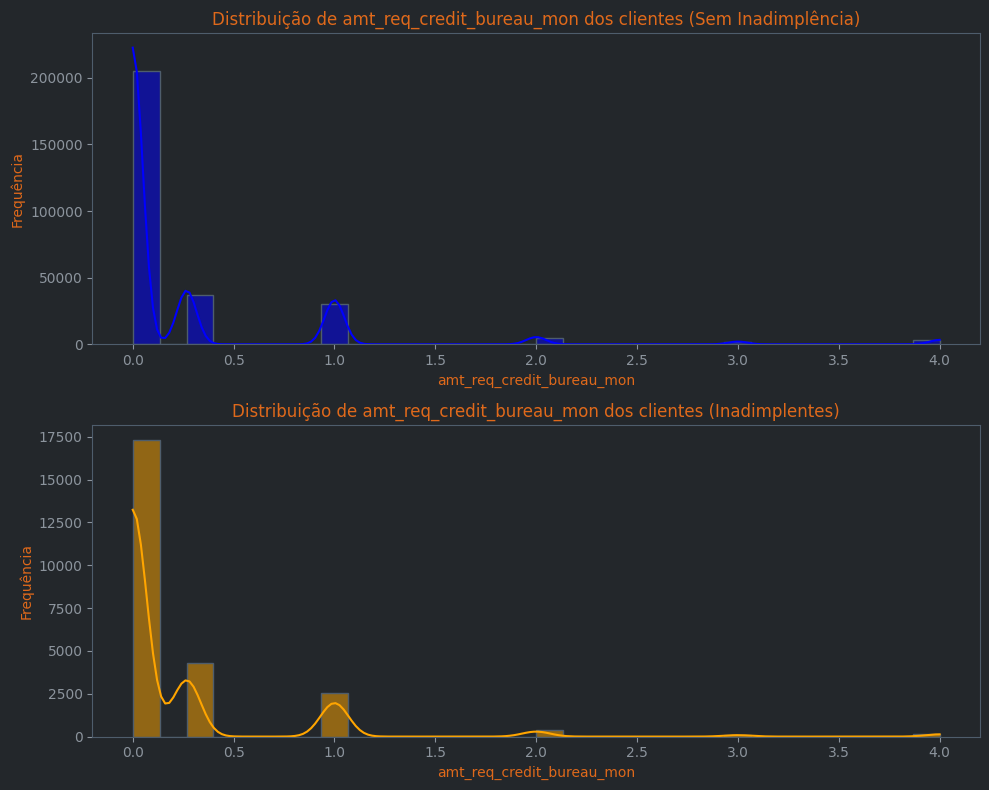

Correlação de Pearson entre amt_req_credit_bureau_mon e target: -0.0099


In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(10, 8), sharey=False)

sns.histplot(
    data=df3[df3['target'] == 0],
    x='amt_req_credit_bureau_mon',
    color='blue',
    ax=axes[0],
    kde=True,
    bins=30
)
axes[0].set_title('Distribuição de amt_req_credit_bureau_mon dos clientes (Sem Inadimplência)')
axes[0].set_ylabel('Frequência')
axes[0].set_xlabel('amt_req_credit_bureau_mon')

sns.histplot(
    data=df3[df3['target'] == 1],
    x='amt_req_credit_bureau_mon',
    color='orange',
    ax=axes[1],
    kde=True,
    bins=30
)
axes[1].set_title('Distribuição de amt_req_credit_bureau_mon dos clientes (Inadimplentes)')
axes[1].set_ylabel('Frequência')
axes[1].set_xlabel('amt_req_credit_bureau_mon')

plt.tight_layout()
plt.show()

pearson_corr = df3['amt_req_credit_bureau_mon'].corr(df3['target'], method='pearson')
print(f"Correlação de Pearson entre amt_req_credit_bureau_mon e target: {pearson_corr:.4f}")

amt_req_credit_bureau_qrt

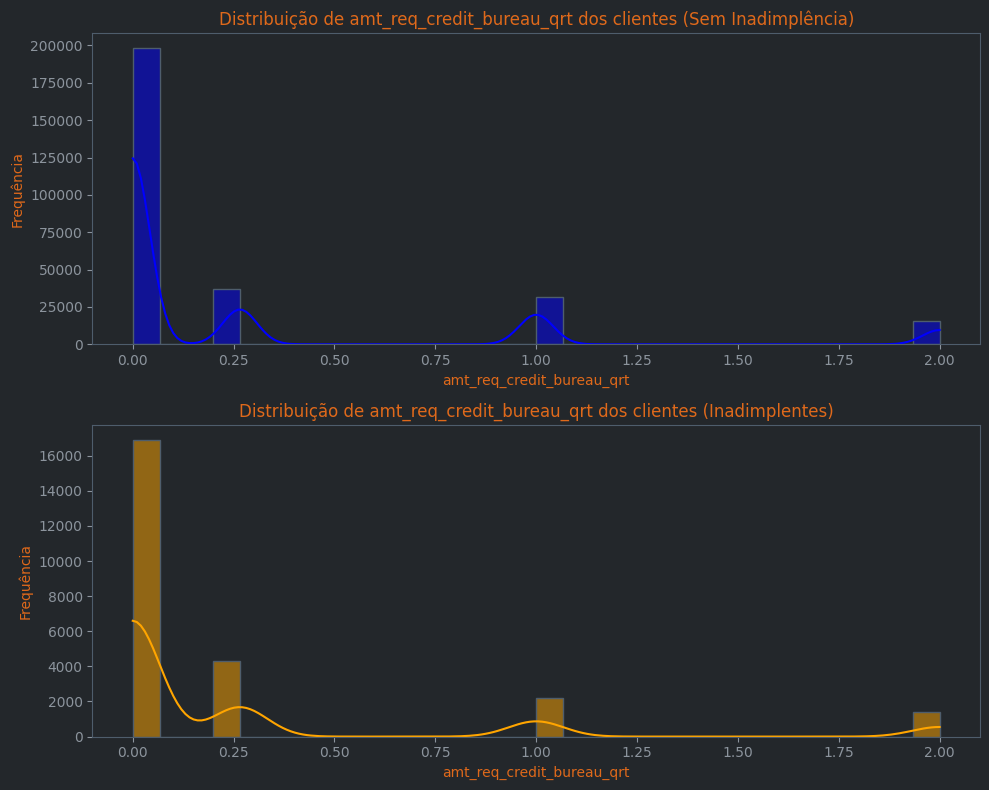

Correlação de Pearson entre amt_req_credit_bureau_qrt e target: -0.0035


In [ ]:

fig, axes = plt.subplots(2, 1, figsize=(10, 8), sharey=False)

sns.histplot(
    data=df3[df3['target'] == 0],
    x='amt_req_credit_bureau_qrt',
    color='blue',
    ax=axes[0],
    kde=True,
    bins=30
)
axes[0].set_title('Distribuição de amt_req_credit_bureau_qrt dos clientes (Sem Inadimplência)')
axes[0].set_ylabel('Frequência')
axes[0].set_xlabel('amt_req_credit_bureau_qrt')

sns.histplot(
    data=df3[df3['target'] == 1],
    x='amt_req_credit_bureau_qrt',
    color='orange',
    ax=axes[1],
    kde=True,
    bins=30
)
axes[1].set_title('Distribuição de amt_req_credit_bureau_qrt dos clientes (Inadimplentes)')
axes[1].set_ylabel('Frequência')
axes[1].set_xlabel('amt_req_credit_bureau_qrt')

plt.tight_layout()
plt.show()

pearson_corr = df3['amt_req_credit_bureau_qrt'].corr(df3['target'], method='pearson')
print(f"Correlação de Pearson entre amt_req_credit_bureau_qrt e target: {pearson_corr:.4f}")

amt_req_credit_bureau_year

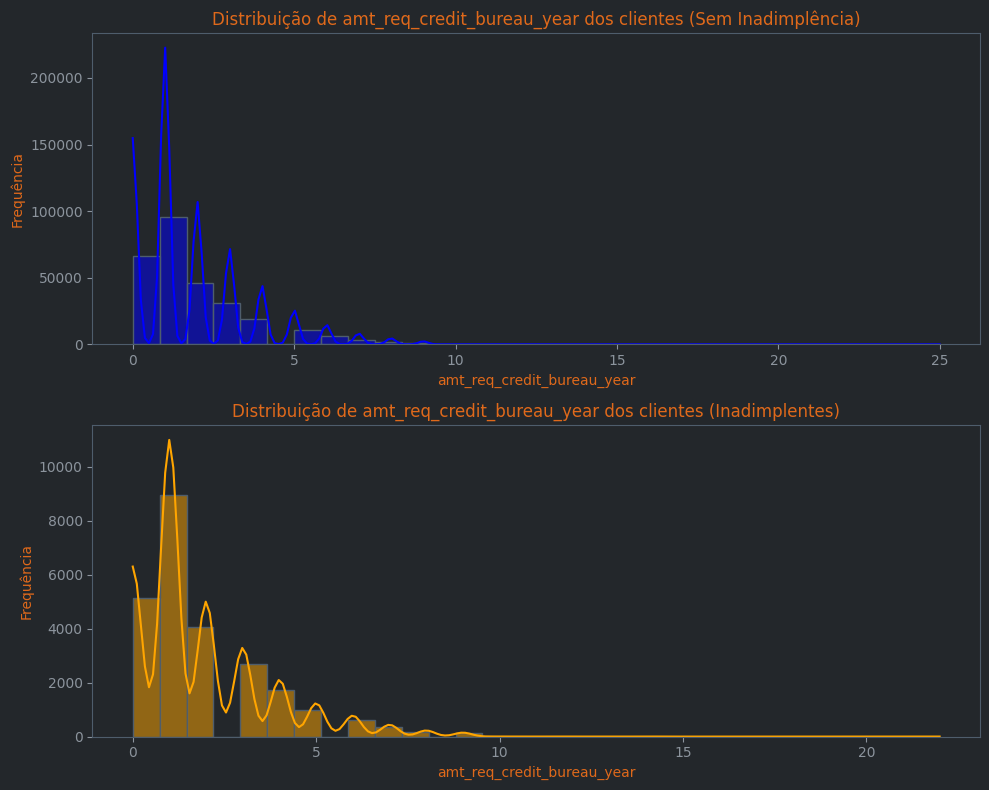

Correlação de Pearson entre amt_req_credit_bureau_year e target: 0.0122


In [ ]:

fig, axes = plt.subplots(2, 1, figsize=(10, 8), sharey=False)

sns.histplot(
    data=df3[df3['target'] == 0],
    x='amt_req_credit_bureau_year',
    color='blue',
    ax=axes[0],
    kde=True,
    bins=30
)
axes[0].set_title('Distribuição de amt_req_credit_bureau_year dos clientes (Sem Inadimplência)')
axes[0].set_ylabel('Frequência')
axes[0].set_xlabel('amt_req_credit_bureau_year')

sns.histplot(
    data=df3[df3['target'] == 1],
    x='amt_req_credit_bureau_year',
    color='orange',
    ax=axes[1],
    kde=True,
    bins=30
)
axes[1].set_title('Distribuição de amt_req_credit_bureau_year dos clientes (Inadimplentes)')
axes[1].set_ylabel('Frequência')
axes[1].set_xlabel('amt_req_credit_bureau_year')

plt.tight_layout()
plt.show()

pearson_corr = df3['amt_req_credit_bureau_year'].corr(df3['target'], method='pearson')
print(f"Correlação de Pearson entre amt_req_credit_bureau_year e target: {pearson_corr:.4f}")

amt_credit_sum_mean

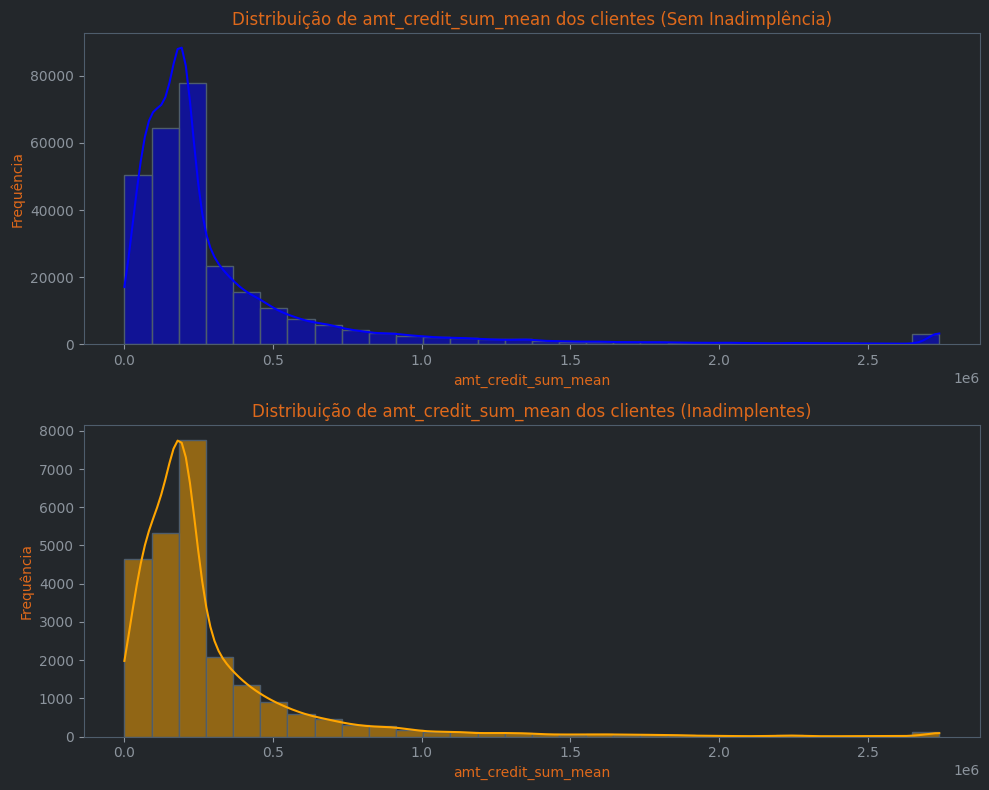

Correlação de Pearson entre amt_credit_sum_mean e target: -0.0289


In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(10, 8), sharey=False)

sns.histplot(
    data=df3[df3['target'] == 0],
    x='amt_credit_sum_mean',
    color='blue',
    ax=axes[0],
    kde=True,
    bins=30
)
axes[0].set_title('Distribuição de amt_credit_sum_mean dos clientes (Sem Inadimplência)')
axes[0].set_ylabel('Frequência')
axes[0].set_xlabel('amt_credit_sum_mean')

sns.histplot(
    data=df3[df3['target'] == 1],
    x='amt_credit_sum_mean',
    color='orange',
    ax=axes[1],
    kde=True,
    bins=30
)
axes[1].set_title('Distribuição de amt_credit_sum_mean dos clientes (Inadimplentes)')
axes[1].set_ylabel('Frequência')
axes[1].set_xlabel('amt_credit_sum_mean')

plt.tight_layout()
plt.show()

pearson_corr = df3['amt_credit_sum_mean'].corr(df3['target'], method='pearson')
print(f"Correlação de Pearson entre amt_credit_sum_mean e target: {pearson_corr:.4f}")

amt_credit_sum_sum

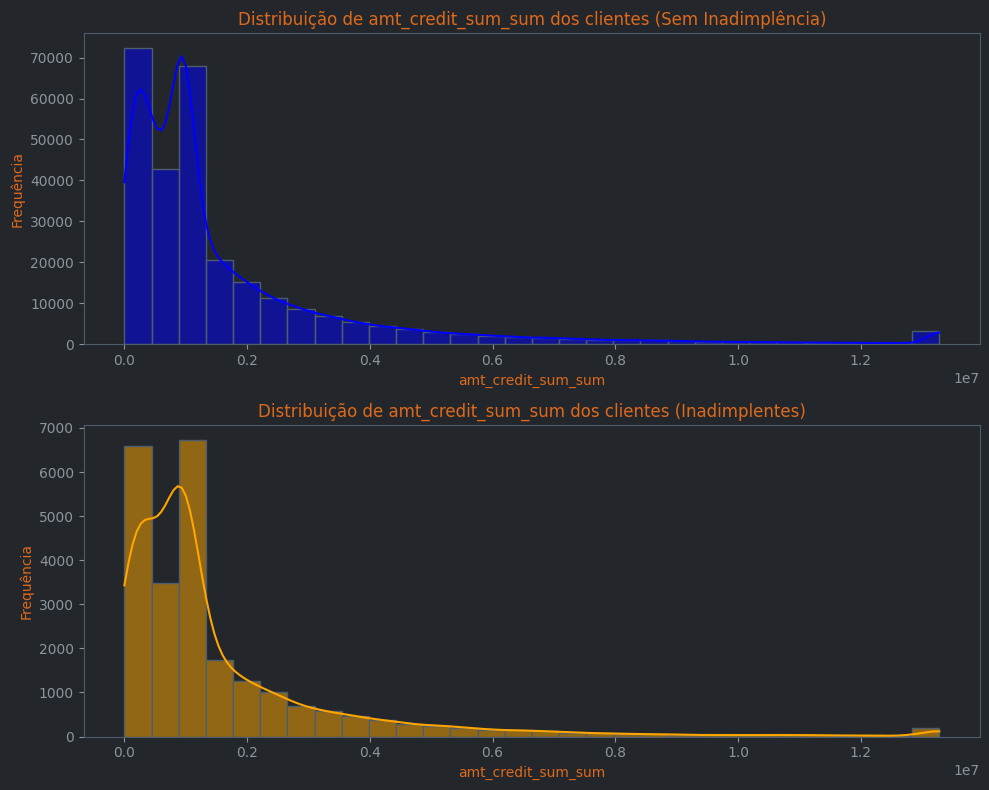

Correlação de Pearson entre amt_credit_sum_sum e target: -0.0198


In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(10, 8), sharey=False)

sns.histplot(
    data=df3[df3['target'] == 0],
    x='amt_credit_sum_sum',
    color='blue',
    ax=axes[0],
    kde=True,
    bins=30
)
axes[0].set_title('Distribuição de amt_credit_sum_sum dos clientes (Sem Inadimplência)')
axes[0].set_ylabel('Frequência')
axes[0].set_xlabel('amt_credit_sum_sum')

sns.histplot(
    data=df3[df3['target'] == 1],
    x='amt_credit_sum_sum',
    color='orange',
    ax=axes[1],
    kde=True,
    bins=30
)
axes[1].set_title('Distribuição de amt_credit_sum_sum dos clientes (Inadimplentes)')
axes[1].set_ylabel('Frequência')
axes[1].set_xlabel('amt_credit_sum_sum')

plt.tight_layout()
plt.show()

pearson_corr = df3['amt_credit_sum_sum'].corr(df3['target'], method='pearson')
print(f"Correlação de Pearson entre amt_credit_sum_sum e target: {pearson_corr:.4f}")

credit_active_nunique

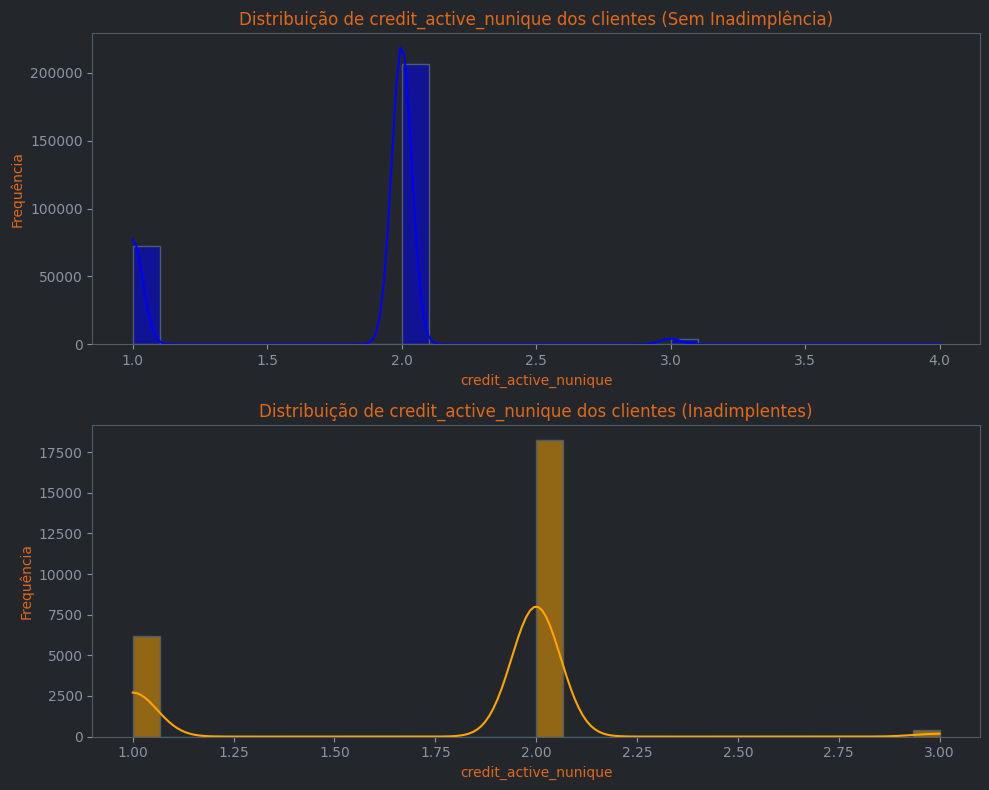

Correlação de Pearson entre credit_active_nunique e target: 0.0060


In [ ]:

fig, axes = plt.subplots(2, 1, figsize=(10, 8), sharey=False)

sns.histplot(
    data=df3[df3['target'] == 0],
    x='credit_active_nunique',
    color='blue',
    ax=axes[0],
    kde=True,
    bins=30
)
axes[0].set_title('Distribuição de credit_active_nunique dos clientes (Sem Inadimplência)')
axes[0].set_ylabel('Frequência')
axes[0].set_xlabel('credit_active_nunique')

sns.histplot(
    data=df3[df3['target'] == 1],
    x='credit_active_nunique',
    color='orange',
    ax=axes[1],
    kde=True,
    bins=30
)
axes[1].set_title('Distribuição de credit_active_nunique dos clientes (Inadimplentes)')
axes[1].set_ylabel('Frequência')
axes[1].set_xlabel('credit_active_nunique')

plt.tight_layout()
plt.show()

pearson_corr = df3['credit_active_nunique'].corr(df3['target'], method='pearson')
print(f"Correlação de Pearson entre credit_active_nunique e target: {pearson_corr:.4f}")

amt_credit_mean

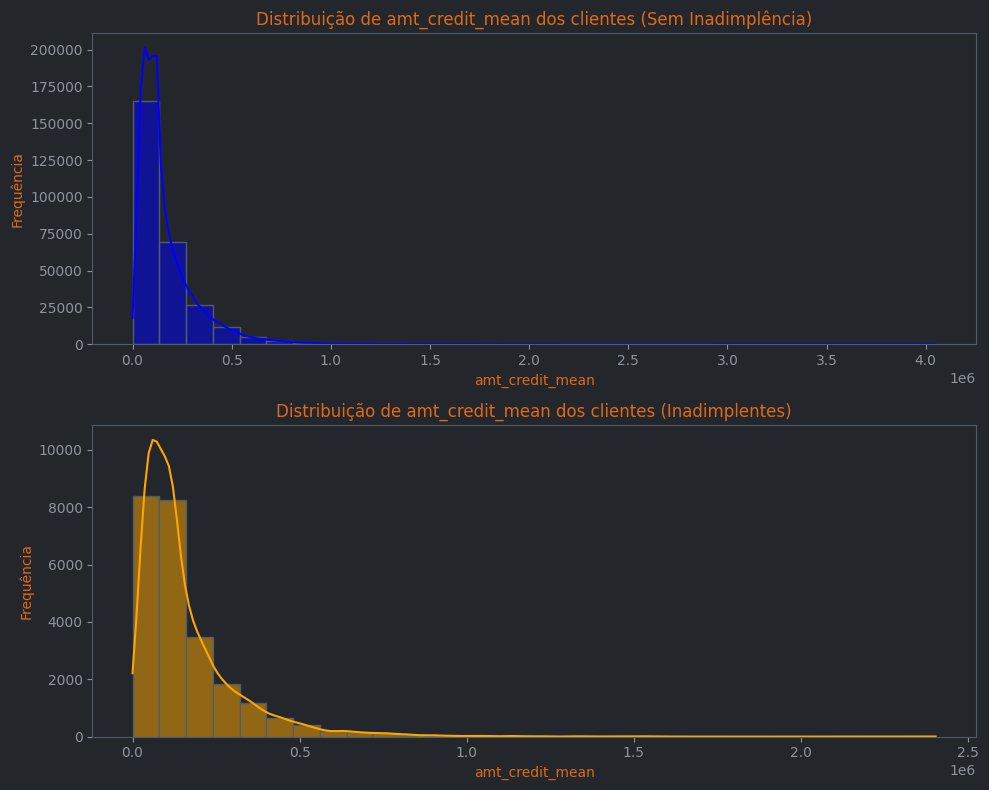

Correlação de Pearson entre amt_credit_mean e target: -0.0144


In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(10, 8), sharey=False)

sns.histplot(
    data=df3[df3['target'] == 0],
    x='amt_credit_mean',
    color='blue',
    ax=axes[0],
    kde=True,
    bins=30
)
axes[0].set_title('Distribuição de amt_credit_mean dos clientes (Sem Inadimplência)')
axes[0].set_ylabel('Frequência')
axes[0].set_xlabel('amt_credit_mean')

sns.histplot(
    data=df3[df3['target'] == 1],
    x='amt_credit_mean',
    color='orange',
    ax=axes[1],
    kde=True,
    bins=30
)
axes[1].set_title('Distribuição de amt_credit_mean dos clientes (Inadimplentes)')
axes[1].set_ylabel('Frequência')
axes[1].set_xlabel('amt_credit_mean')

plt.tight_layout()
plt.show()

pearson_corr = df3['amt_credit_mean'].corr(df3['target'], method='pearson')
print(f"Correlação de Pearson entre amt_credit_mean e target: {pearson_corr:.4f}")

amt_credit_sum

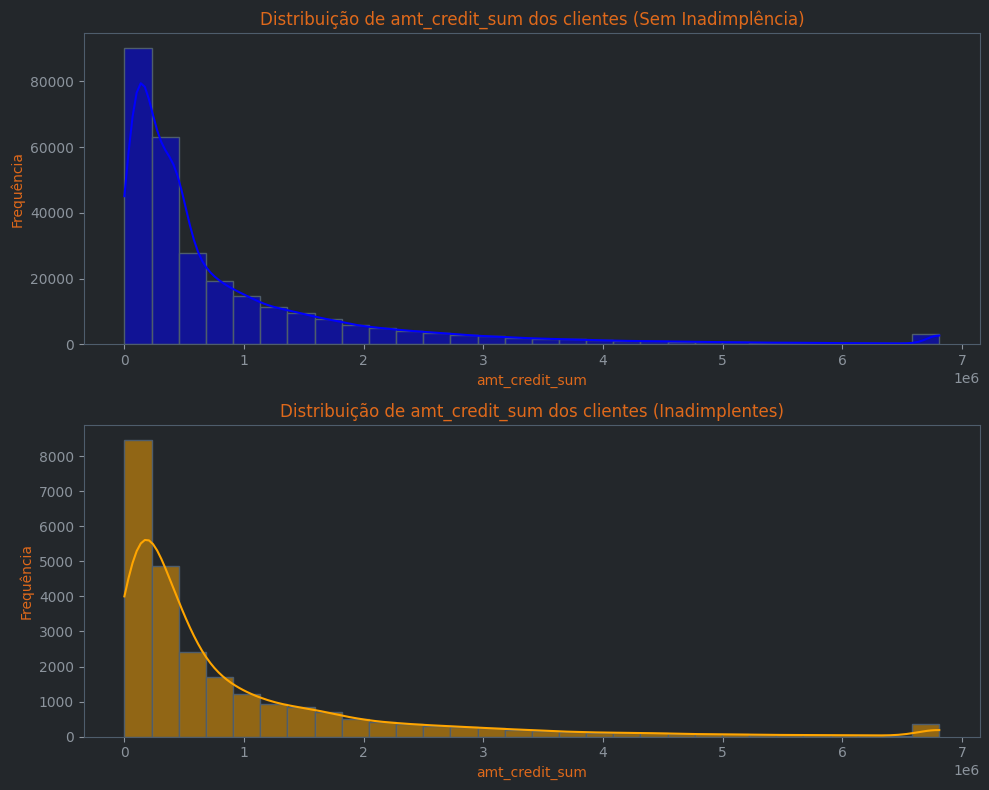

Correlação de Pearson entre amt_credit_sum e target: 0.0076


In [ ]:

fig, axes = plt.subplots(2, 1, figsize=(10, 8), sharey=False)

sns.histplot(
    data=df3[df3['target'] == 0],
    x='amt_credit_sum',
    color='blue',
    ax=axes[0],
    kde=True,
    bins=30
)
axes[0].set_title('Distribuição de amt_credit_sum dos clientes (Sem Inadimplência)')
axes[0].set_ylabel('Frequência')
axes[0].set_xlabel('amt_credit_sum')

sns.histplot(
    data=df3[df3['target'] == 1],
    x='amt_credit_sum',
    color='orange',
    ax=axes[1],
    kde=True,
    bins=30
)
axes[1].set_title('Distribuição de amt_credit_sum dos clientes (Inadimplentes)')
axes[1].set_ylabel('Frequência')
axes[1].set_xlabel('amt_credit_sum')

plt.tight_layout()
plt.show()

pearson_corr = df3['amt_credit_sum'].corr(df3['target'], method='pearson')
print(f"Correlação de Pearson entre amt_credit_sum e target: {pearson_corr:.4f}")

amt_credit_max

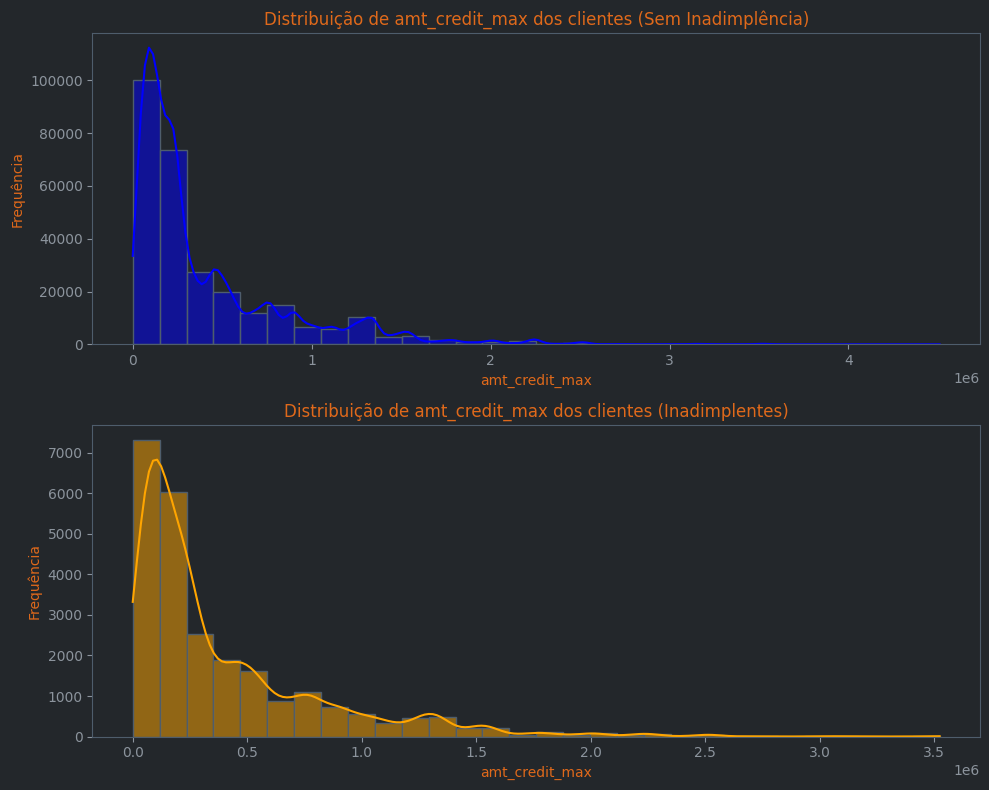

Correlação de Pearson entre amt_credit_max e target: -0.0065


In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(10, 8), sharey=False)

sns.histplot(
    data=df3[df3['target'] == 0],
    x='amt_credit_max',
    color='blue',
    ax=axes[0],
    kde=True,
    bins=30
)
axes[0].set_title('Distribuição de amt_credit_max dos clientes (Sem Inadimplência)')
axes[0].set_ylabel('Frequência')
axes[0].set_xlabel('amt_credit_max')

sns.histplot(
    data=df3[df3['target'] == 1],
    x='amt_credit_max',
    color='orange',
    ax=axes[1],
    kde=True,
    bins=30
)
axes[1].set_title('Distribuição de amt_credit_max dos clientes (Inadimplentes)')
axes[1].set_ylabel('Frequência')
axes[1].set_xlabel('amt_credit_max')

plt.tight_layout()
plt.show()

pearson_corr = df3['amt_credit_max'].corr(df3['target'], method='pearson')
print(f"Correlação de Pearson entre amt_credit_max e target: {pearson_corr:.4f}")

amt_application_mean

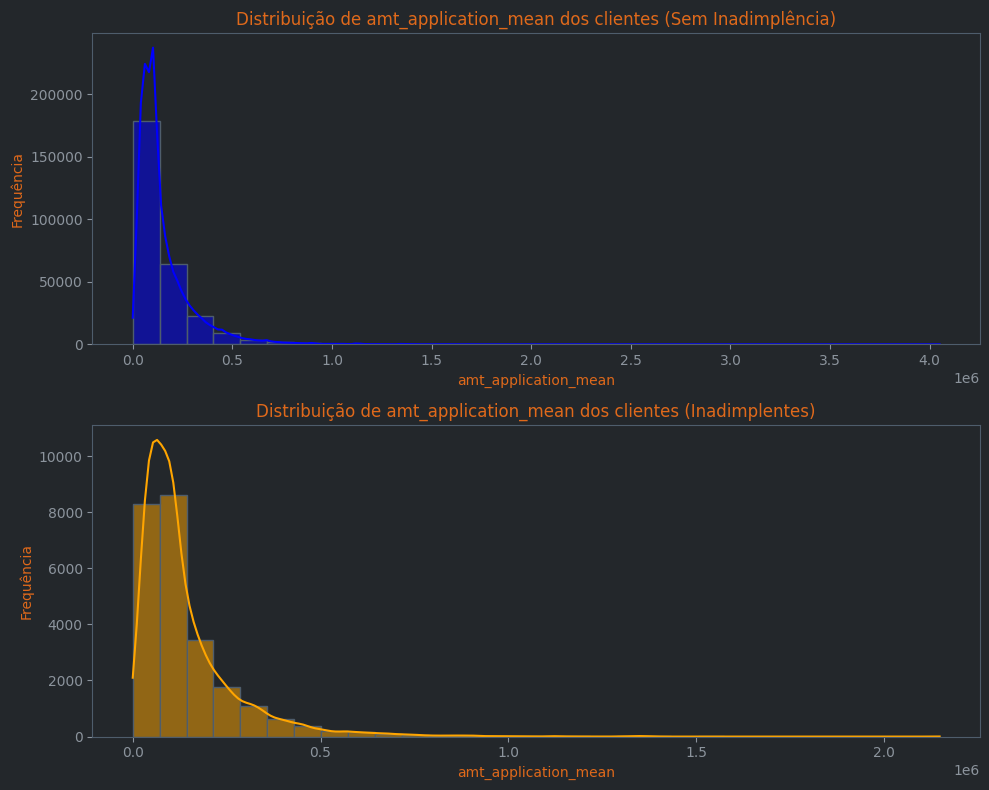

Correlação de Pearson entre amt_application_mean e target: -0.0200


In [ ]:


fig, axes = plt.subplots(2, 1, figsize=(10, 8), sharey=False)

sns.histplot(
    data=df3[df3['target'] == 0],
    x='amt_application_mean',
    color='blue',
    ax=axes[0],
    kde=True,
    bins=30
)
axes[0].set_title('Distribuição de amt_application_mean dos clientes (Sem Inadimplência)')
axes[0].set_ylabel('Frequência')
axes[0].set_xlabel('amt_application_mean')

sns.histplot(
    data=df3[df3['target'] == 1],
    x='amt_application_mean',
    color='orange',
    ax=axes[1],
    kde=True,
    bins=30
)
axes[1].set_title('Distribuição de amt_application_mean dos clientes (Inadimplentes)')
axes[1].set_ylabel('Frequência')
axes[1].set_xlabel('amt_application_mean')

plt.tight_layout()
plt.show()

pearson_corr = df3['amt_application_mean'].corr(df3['target'], method='pearson')
print(f"Correlação de Pearson entre amt_application_mean e target: {pearson_corr:.4f}")

days_decision_mean

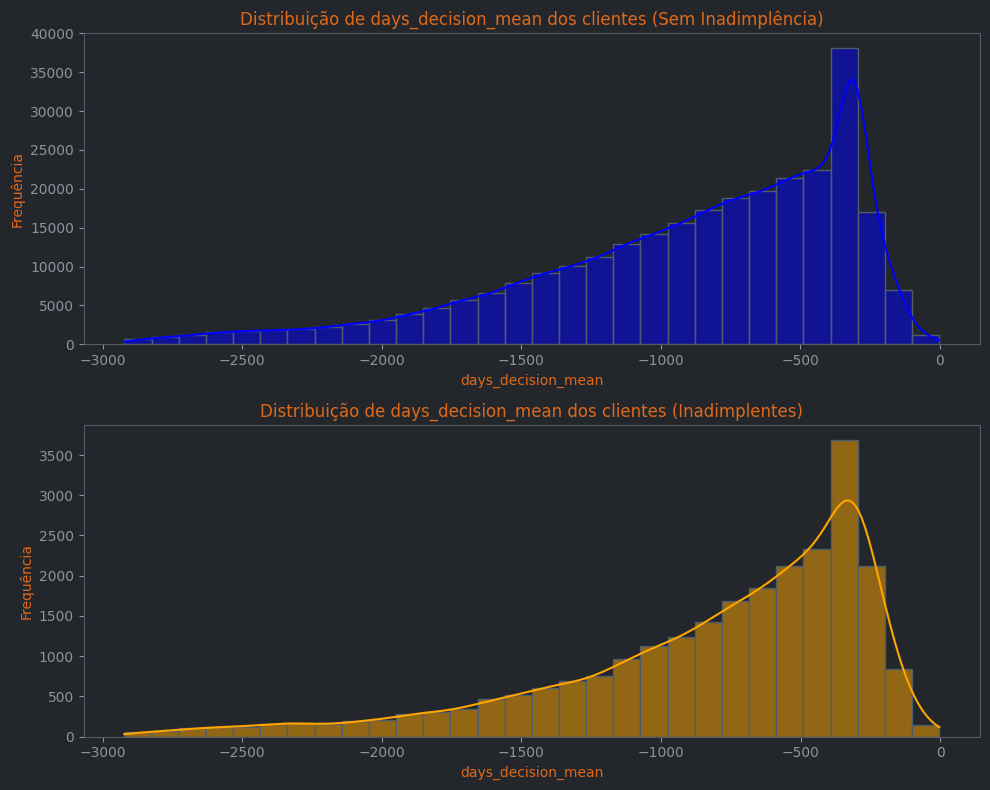

Correlação de Pearson entre days_decision_mean e target: 0.0402


In [ ]:

fig, axes = plt.subplots(2, 1, figsize=(10, 8), sharey=False)

sns.histplot(
    data=df3[df3['target'] == 0],
    x='days_decision_mean',
    color='blue',
    ax=axes[0],
    kde=True,
    bins=30
)
axes[0].set_title('Distribuição de days_decision_mean dos clientes (Sem Inadimplência)')
axes[0].set_ylabel('Frequência')
axes[0].set_xlabel('days_decision_mean')

sns.histplot(
    data=df3[df3['target'] == 1],
    x='days_decision_mean',
    color='orange',
    ax=axes[1],
    kde=True,
    bins=30
)
axes[1].set_title('Distribuição de days_decision_mean dos clientes (Inadimplentes)')
axes[1].set_ylabel('Frequência')
axes[1].set_xlabel('days_decision_mean')

plt.tight_layout()
plt.show()

pearson_corr = df3['days_decision_mean'].corr(df3['target'], method='pearson')
print(f"Correlação de Pearson entre days_decision_mean e target: {pearson_corr:.4f}")

##### H49 — Property characteristics and employment status influence repayment capacity. TRUE

is_building

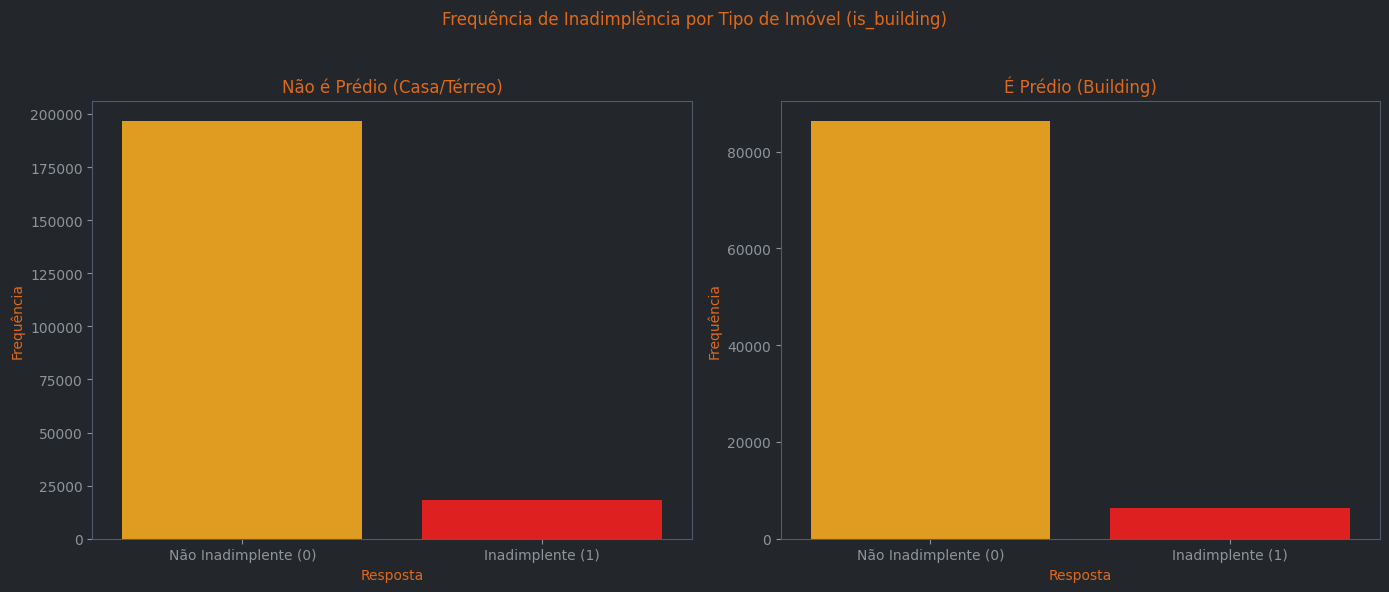

V de Cramer entre is_building e target: 0.0280


In [ ]:

plot_binaria_target(
    df3,
    var_binaria='is_building',
    label_0='Não é Prédio',
    label_1='É Prédio',
    suptitle='Frequência de Inadimplência por tipo do Imóvel'
)

calcular_cramers_v(df3, 'is_building', 'target')


has_basement

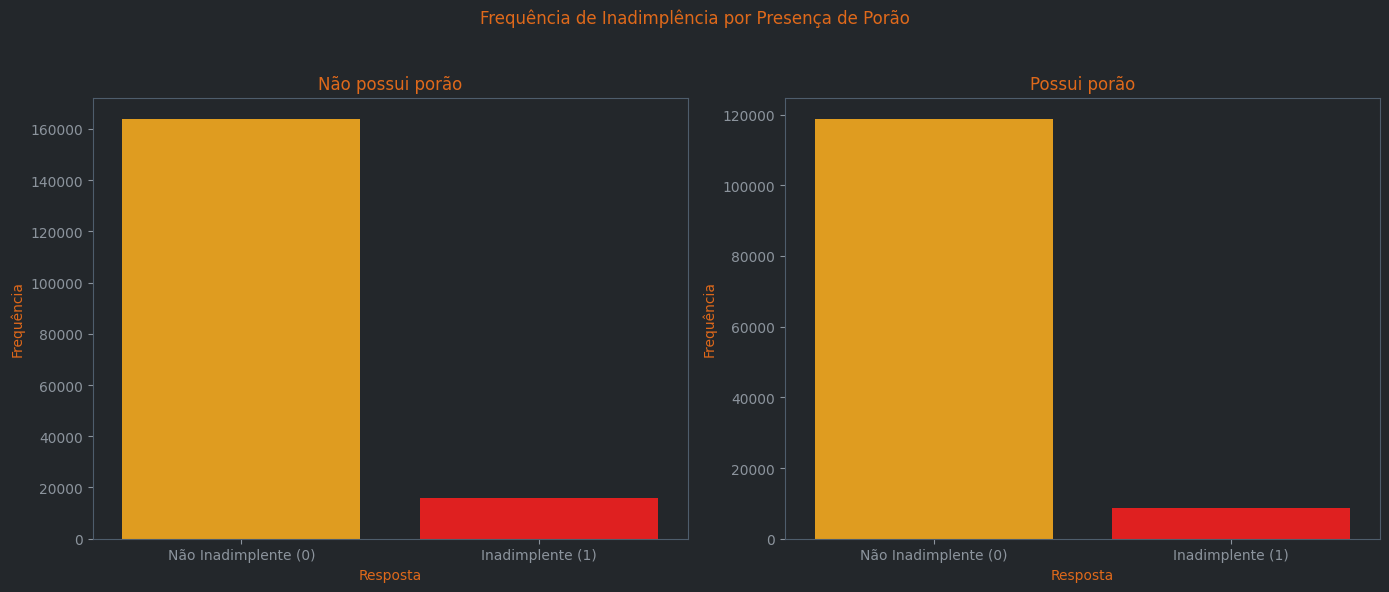

V de Cramer entre has_basement e target: 0.0366


In [ ]:

plot_binaria_target(
    df3,
    var_binaria='has_basement',
    label_0='Não possui porão',
    label_1='Possui porão',
    suptitle='Frequência de Inadimplência por Presença de Porão'
)

calcular_cramers_v(df3, 'has_basement', 'target')


has_noliving

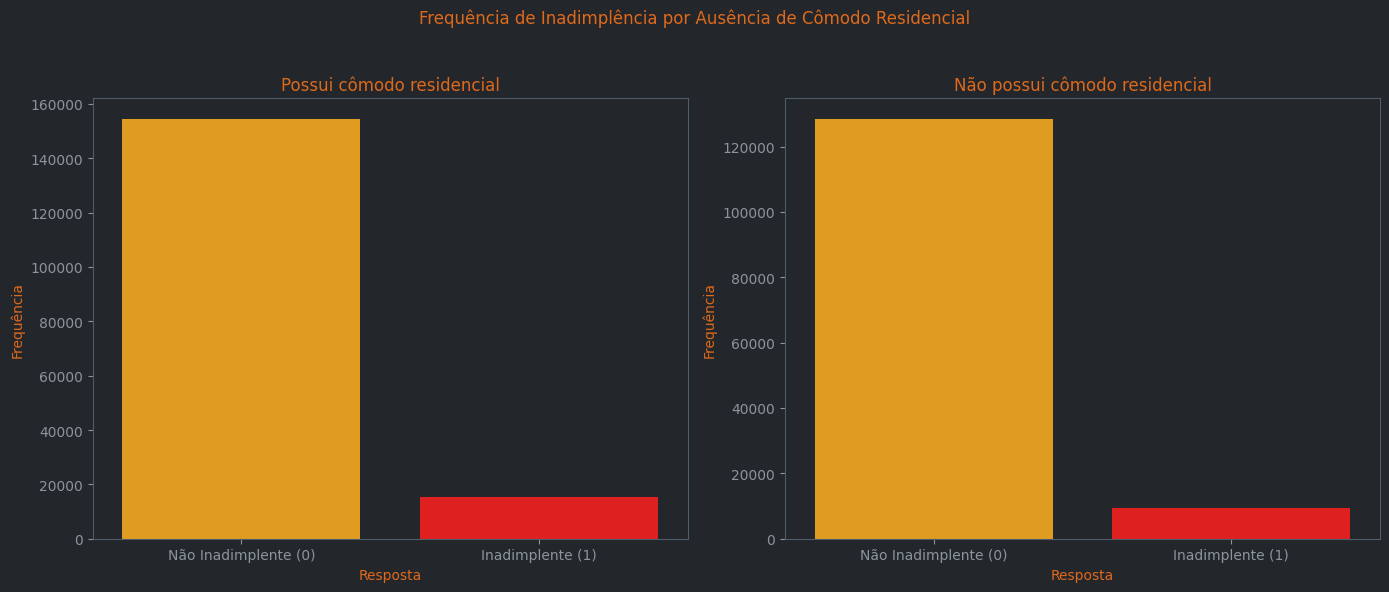

V de Cramer entre has_noliving e target: 0.0392


In [ ]:


plot_binaria_target(
    df3,
    var_binaria='has_noliving',
    label_0='Possui cômodo residencial',
    label_1='Possui cômodo residencial',
    suptitle='Frequência de Inadimplência por Ausência de Cômodo Residencial'
)
calcular_cramers_v(df3, 'has_noliving', 'target')


is_employed

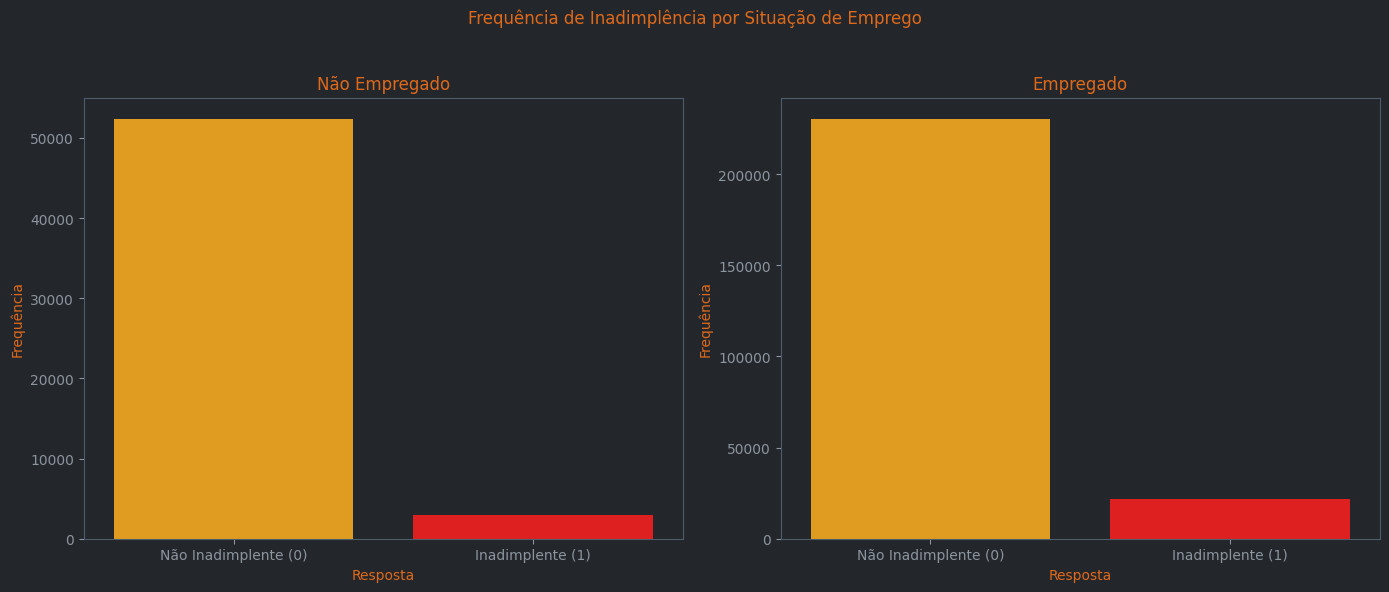

V de Cramer entre is_employed e target: 0.0460


In [ ]:

plot_binaria_target(
    df3,
    var_binaria='is_building',
    label_0='Não Empregado',
    label_1='Empregado',
    suptitle='Frequência de Inadimplência por Situação de Emprego'
)
calcular_cramers_v(df3, 'is_employed', 'target')


## 8. Data Preparation

In [ ]:
df4 = df3.copy()

### 8.1 Scaling

#### 8.1.1 Log Transform

In [8]:

log_transform_cols = [
    'decision_credit_diff',
    'annuity_burden_ratio',
    'credit_efficiency',
]

for col in log_transform_cols:
    df4[col + '_log'] = np.log1p(df4[col])
    df4.drop(columns=col, inplace=True)

c:\Users\Patryck\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


#### 8.1.2 Robust Scaler

In [9]:
cols_to_scale = [
    'phone_change_frequency',
    'amt_income_total',
    'amt_credit',
    'num_flag_document',
    'amt_annuity',
    'amt_goods_price',
    'apartments_avg',
    'floorsmax_avg',
    'livingarea_avg',
    'years_build_avg',
    'phone_change_rate',
    'elevators_avg',
    'elevators_mode',
    'elevators_medi',
    'own_car_age',
    'obs_30_cnt_social_circle',
    'def_30_cnt_social_circle',
    'obs_60_cnt_social_circle',
    'def_60_cnt_social_circle',
    'amt_req_credit_bureau_hour',
    'amt_req_credit_bureau_day',
    'amt_req_credit_bureau_week',
    'amt_req_credit_bureau_mon',
    'amt_req_credit_bureau_qrt',
    'amt_req_credit_bureau_year',
    'goods_to_credit_ratio',
    'basementarea_avg',
    'livingapartments_avg',
    'landarea_avg',
    'nonlivingapartments_avg',
    'commonarea_avg',
    'years_beginexpluatation_avg',
    'nonlivingarea_avg',
    'days_employed',
    'payment_rate',
    'payment_rate^2',
    'payment_rate ext_source_mean',
    'days_birth^2 payment_rate',
    'days_birth payment_rate^2',
    'payment_rate^3',
    'payment_rate^2 ext_source_mean',
    'payment_rate ext_source_mean^2',
]

robust_scaler = RobustScaler()
df4[cols_to_scale] = robust_scaler.fit_transform(df4[cols_to_scale])


#### 8.1.3 Standard Scaler

In [10]:

cols_to_standard_scale = [ 
    'days_registration', 
    'days_since_last_employment_until_application',
    'income_per_employed',
    'days_id_publish',
    'days_last_phone_change', 
    'recent_instability',
    'employment_stability',
    'employment_life_ratio',
    'cnt_fam_members',
    'goods_to_credit_ratio',
    'days_birth',
    'days_birth^2',
    'days_birth payment_rate',
    'days_birth ext_source_mean',
    'ext_source_mean^2',
    'days_birth^3',
    'days_birth^2 ext_source_mean',
    'days_birth payment_rate ext_source_mean',
    'days_birth ext_source_mean^2',
    'ext_source_mean^3'
]


standard_scaler = StandardScaler()
df4[cols_to_standard_scale] = standard_scaler.fit_transform(df4[cols_to_standard_scale])

#### 8.1.4 MinMaxScaler

In [11]:
cols_to_minmax_scale = [
    'cnt_children',
    'region_population_relative',
    'bureau_to_credit_ratio',
    'bureau_request_intensity',
    'annuity_to_income_ratio',
    'id_document_age_ratio',
]
minmax_scaler = MinMaxScaler()

df4[cols_to_minmax_scale] = minmax_scaler.fit_transform(df4[cols_to_minmax_scale])

#### 8.1.5 Scaling Final

In [12]:

binary_cols = [col for col in df4.columns if sorted(df4[col].dropna().unique()) in [[0, 1], [1], [0]] and df4[col].dtype != 'object']

lists_to_exclude = set(
    cols_to_standard_scale + 
    cols_to_scale + 
    cols_to_minmax_scale +
    binary_cols +
    [col for col in df4.columns if df4[col].dtype == 'object'] +
    ['target']
)

other_columns = [col for col in df4.columns if (col not in lists_to_exclude) and (col not in binary_cols)]

scaler = StandardScaler()
df4[other_columns] = scaler.fit_transform(df4[other_columns])


### 8.2 Encoding

#### 8.2.1 BinaryEncoding

In [4]:

df4['name_contract_type'] = (df4['name_contract_type'] != 'Cash loans').astype(int)
df4['code_gender'] = df4['code_gender'].map({'F': 0, 'M': 1})


#### 8.2.2 OneHotEncoding

In [5]:
encoder_suite = OneHotEncoder(drop='first', sparse_output=False)
encoded_suite = encoder_suite.fit_transform(df4[['name_type_suite']])
col_names_suite = [f"nts_{cat}" for cat in encoder_suite.categories_[0][1:]]
encoded_df_suite = pd.DataFrame(encoded_suite, columns=col_names_suite, index=df4.index)
df4 = pd.concat([df4.drop(columns=['name_type_suite']), encoded_df_suite], axis=1)

encoder_fam = OneHotEncoder(drop='first', sparse_output=False)
encoded_fam = encoder_fam.fit_transform(df4[['name_family_status']])
col_names_fam = [f"nfs_{cat}" for cat in encoder_fam.categories_[0][1:]]
encoded_df_fam = pd.DataFrame(encoded_fam, columns=col_names_fam, index=df4.index)
df4 = pd.concat([df4.drop(columns=['name_family_status']), encoded_df_fam], axis=1)

encoder_housing = OneHotEncoder(drop='first', sparse_output=False)
encoded_housing = encoder_housing.fit_transform(df4[['name_housing_type']])
col_names_housing = [f"nht_{cat}" for cat in encoder_housing.categories_[0][1:]]
encoded_df_housing = pd.DataFrame(encoded_housing, columns=col_names_housing, index=df4.index)
df4 = pd.concat([df4.drop(columns=['name_housing_type']), encoded_df_housing], axis=1)

encoder_housetype_mode = OneHotEncoder(drop='first', sparse_output=False)
encoded_housetype_mode = encoder_housetype_mode.fit_transform(df4[['housetype_mode']])
col_names_housetype_mode = [f"htm_{cat}" for cat in encoder_housetype_mode.categories_[0][1:]]
encoded_df_housetype_mode = pd.DataFrame(encoded_housetype_mode, columns=col_names_housetype_mode, index=df4.index)
df4 = pd.concat([df4.drop(columns=['housetype_mode']), encoded_df_housetype_mode], axis=1)

encoder_walls = OneHotEncoder(drop='first', sparse_output=False)
encoded_walls = encoder_walls.fit_transform(df4[['wallsmaterial_mode']])
col_names_walls = [f"wm_{cat}" for cat in encoder_walls.categories_[0][1:]]
encoded_df_walls = pd.DataFrame(encoded_walls, columns=col_names_walls, index=df4.index)
df4 = pd.concat([df4.drop(columns=['wallsmaterial_mode']), encoded_df_walls], axis=1)

#### 8.2.3 TargetEncoding

In [6]:

target_mean_income = df4.groupby('name_income_type')['target'].mean()
df4['name_income_type_te'] = df4['name_income_type'].map(target_mean_income)
df4.drop('name_income_type', axis=1, inplace=True)

target_mean_occupation = df4.groupby('occupation_type')['target'].mean()
df4['occupation_type_te'] = df4['occupation_type'].map(target_mean_occupation)
df4.drop('occupation_type', axis=1, inplace=True)

target_mean_organization = df4.groupby('organization_type')['target'].mean()
df4['organization_type_te'] = df4['organization_type'].map(target_mean_organization)
df4.drop('organization_type', axis=1, inplace=True)

target_mean_region_rating_client = df4.groupby('region_rating_client')['target'].mean()
df4['region_rating_client_te'] = df4['region_rating_client'].map(target_mean_region_rating_client)
df4.drop('region_rating_client', axis=1, inplace=True)

target_mean_region_rating_client_w_city = df4.groupby('region_rating_client_w_city')['target'].mean()
df4['region_rating_client_w_city_te'] = df4['region_rating_client_w_city'].map(target_mean_region_rating_client_w_city)
df4.drop('region_rating_client_w_city', axis=1, inplace=True)


#### 8.2.4 OrdinalEncoding

In [7]:
education_order = [
    'Lower secondary',
    'Secondary / secondary special',
    'Incomplete higher',
    'Higher education',
    'Academic degree'
]
df4['name_education_type'] = pd.Categorical(
    df4['name_education_type'],
    categories=education_order,
    ordered=True
).codes

## 9. Feature Selection

In [ ]:
df5 = df3.copy()

In [4]:
df5.columns = [col.replace('/', '_').replace(',', '_').replace(' ', '') for col in df5.columns]

### 9.1 Features Importance

In [5]:

X = df5.drop(['target'], axis=1)
y =  df5['target']


target = df5['target']
num_neg = (target == 0).sum()
num_pos = (target == 1).sum()
scale_pos_weight = num_neg / num_pos

xgbm_model = xgb.XGBClassifier(
    n_estimators=300,
    random_state=42,
    n_jobs=-1,
    scale_pos_weight=scale_pos_weight,
    eval_metric='logloss'
)
xgbm_model.fit(X, y)

lgbm_model = lgb.LGBMClassifier(
    n_estimators=300,
    random_state=42,
    n_jobs=-1,
    scale_pos_weight=scale_pos_weight
)
lgbm_model.fit(X, y)

cat_model = CatBoostClassifier(
    iterations=300,
    random_state=42,
    verbose=0,
    scale_pos_weight=scale_pos_weight
)
cat_model.fit(X, y)
shap_sample = X.sample(n=min(1000, len(X)), random_state=42)

explainer_xgb = shap.TreeExplainer(xgbm_model)
shap_values_xgb = explainer_xgb.shap_values(shap_sample)
mean_abs_shap_xgb = np.abs(shap_values_xgb).mean(axis=0)

feat_importance_xgb = pd.DataFrame({
    'Feature': X.columns,
    'SHAP_XGB': mean_abs_shap_xgb
})

explainer_lgb = shap.TreeExplainer(lgbm_model)
shap_values_lgb = explainer_lgb.shap_values(shap_sample)
if isinstance(shap_values_lgb, list):
    shap_values_lgb = shap_values_lgb[1]

mean_abs_shap_lgb = np.abs(shap_values_lgb).mean(axis=0)
feat_importance_lgb = pd.DataFrame({
    'Feature': X.columns,
    'SHAP_LGBM': mean_abs_shap_lgb
})

explainer_cat = shap.TreeExplainer(cat_model)
shap_values_cat = explainer_cat.shap_values(shap_sample)
if isinstance(shap_values_cat, (list, tuple)):
    shap_values_cat = shap_values_cat[1]

mean_abs_shap_cat = np.abs(shap_values_cat).mean(axis=0)
feat_importance_cat = pd.DataFrame({
    'Feature': X.columns,
    'SHAP_CAT': mean_abs_shap_cat
})

feat_importance_df = (
    feat_importance_xgb
        .merge(feat_importance_lgb, on='Feature')
        .merge(feat_importance_cat, on='Feature')
)

feat_importance_df['SHAP_XGB_NORM'] = feat_importance_df['SHAP_XGB'] / feat_importance_df['SHAP_XGB'].sum()
feat_importance_df['SHAP_LGBM_NORM'] = feat_importance_df['SHAP_LGBM'] / feat_importance_df['SHAP_LGBM'].sum()
feat_importance_df['SHAP_CAT_NORM'] = feat_importance_df['SHAP_CAT'] / feat_importance_df['SHAP_CAT'].sum()

feat_importance_df['SHAP_MEAN_NORM'] = feat_importance_df[
    ['SHAP_XGB_NORM', 'SHAP_LGBM_NORM', 'SHAP_CAT_NORM']
].mean(axis=1)

feat_importance_df = feat_importance_df.sort_values(by='SHAP_MEAN_NORM', ascending=False).reset_index(drop=True)


[LightGBM] [Info] Number of positive: 24825, number of negative: 282686
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 5.431486 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 119911
[LightGBM] [Info] Number of data points in the train set: 307511, number of used features: 1603
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080729 -> initscore=-2.432486
[LightGBM] [Info] Start training from score -2.432486


c:\Users\Patryck\AppData\Local\Programs\Python\Python311\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


In [6]:
feat_importance_df.head(50)

Feature  SHAP_XGB  SHAP_LGBM  SHAP_CAT  \
0                            ext_source_mean  0.479819   0.136462  0.098005   
1                          ext_source_mean^3  0.000000   0.234489  0.196949   
2                            amt_goods_price  0.180001   0.119373  0.168450   
3                                 amt_credit  0.188181   0.099917  0.149596   
4                          ext_source_mean^2  0.000000   0.128990  0.256225   
5                                code_gender  0.131131   0.120886  0.131836   
6                        name_education_type  0.093606   0.084137  0.100661   
7            instf_inst_amt_payment_min_mean  0.112430   0.082894  0.070336   
8                                amt_annuity  0.100947   0.068007  0.084914   
9                                nfs_Married  0.080827   0.077176  0.077103   
10                      organization_type_te  0.082617   0.071622  0.078300   
11              bur_amt_credit_sum_debt_mean  0.078518   0.064338  0.091906   
12                      ext_source_1_missing  0.085076   0.064582  0.085060   
13                  ext_source_weighted_mean  0.069700   0.057586  0.080541   
14            instf_inst_amt_payment_min_min  0.071058   0.061853  0.058185   
15                        occupation_type_te  0.058921   0.054293  0.069931   
16               bur_days_credit_enddate_max  0.072368   0.052928  0.056696   
17  posf_pos_cnt_instalment_future_mean_mean  0.061260   0.042279  0.080664   
18                     employment_life_ratio  0.032763   0.033041  0.115123   
19                      prev_cnt_payment_max  0.038009   0.047791  0.069048   
20                 bur_days_enddate_fact_max  0.061550   0.043459  0.054840   
21                              flag_own_car  0.072230   0.059843  0.018257   
22           posf_pos_months_balance_max_max  0.061593   0.043903  0.047087   
23                         num_flag_document  0.056485   0.046360  0.039938   
24                       bur_days_credit_max  0.056292   0.039222  0.049257   
25               annuity_per_employment_year  0.041860   0.040980  0.057281   
26                   annuity_to_income_ratio  0.055552   0.032860  0.047513   
27     instf_inst_days_entry_payment_max_max  0.064776   0.025673  0.046376   
28                              ext_source_3  0.041073   0.029021  0.058268   
29            instf_inst_amt_payment_min_max  0.032871   0.028211  0.066105   
30                own_car_age_employed_ratio  0.048990   0.038457  0.030191   
31               days_birthext_source_mean^2  0.068693   0.034609  0.017099   
32                     prev_cnt_payment_mean  0.064248   0.032823  0.017195   
33                region_population_relative  0.045858   0.024654  0.043919   
34                    bur_amt_credit_sum_min  0.046560   0.024092  0.044253   
35                amt_application_goods_diff  0.048215   0.025340  0.039803   
36                           days_id_publish  0.047277   0.039052  0.014773   
37                 prev_amt_down_payment_max  0.042961   0.034000  0.024261   
38                              ext_source_2  0.046125   0.021802  0.040196   
39                                days_birth  0.049212   0.021245  0.037912   
40        instf_inst_days_instalment_max_max  0.050373   0.019795  0.039331   
41                           flag_document_3  0.035472   0.021595  0.047636   
42   posf_pos_cnt_instalment_future_min_mean  0.039702   0.033119  0.024424   
43            bur_amt_credit_max_overdue_max  0.053756   0.027124  0.020737   
44                         phone_change_rate  0.076217   0.014552  0.022423   
45                       income_per_employed  0.041240   0.009397  0.057745   
46    posf_pos_cnt_instalment_future_min_max  0.024989   0.025092  0.044489   
47            region_rating_client_w_city_te  0.033190   0.025745  0.035299   
48               days_birth^2ext_source_mean  0.038953   0.016967  0.044518   
49                         days_registration  0.043024   0.019410  0.033100   

    SHA

In [7]:

print(f"Número de colunas iniciais em X: {df5.shape[1]}")

feat_importance_df_ordenado = feat_importance_df.sort_values(by='SHAP_LGBM_NORM', ascending=False).reset_index(drop=True)


cumsum = feat_importance_df_ordenado['SHAP_LGBM_NORM'].cumsum()
n_feat_95 = (cumsum <= 0.95).sum() + 1  

selected_features_95 = feat_importance_df_ordenado.loc[:n_feat_95-1, 'Feature'].tolist()

print(f"Quantidade de features para explicar 95% do fenômeno: {len(selected_features_95)}")
print(selected_features_95)

X = df5[selected_features_95]





Número de colunas iniciais em X: 1628
Quantidade de features para explicar 95% do fenômeno: 256
['ext_source_mean^3', 'ext_source_mean', 'ext_source_mean^2', 'code_gender', 'amt_goods_price', 'amt_credit', 'name_education_type', 'instf_inst_amt_payment_min_mean', 'nfs_Married', 'organization_type_te', 'amt_annuity', 'ext_source_1_missing', 'bur_amt_credit_sum_debt_mean', 'instf_inst_amt_payment_min_min', 'flag_own_car', 'ext_source_weighted_mean', 'occupation_type_te', 'bur_days_credit_enddate_max', 'prev_cnt_payment_max', 'num_flag_document', 'posf_pos_months_balance_max_max', 'bur_days_enddate_fact_max', 'posf_pos_cnt_instalment_future_mean_mean', 'annuity_per_employment_year', 'bur_days_credit_max', 'days_id_publish', 'own_car_age_employed_ratio', 'days_birthext_source_mean^2', 'prev_amt_down_payment_max', 'posf_pos_cnt_instalment_future_min_mean', 'employment_life_ratio', 'annuity_to_income_ratio', 'prev_cnt_payment_mean', 'ext_source_3', 'instf_inst_amt_payment_min_max', 'posf_pos

## 10. Machine Learning

In [9]:
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=0, stratify=y
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=0, stratify=y_temp
)

### 10.1 Logistic Regression

In [9]:
neg, pos = np.bincount(y_train)
scale_pos_weight = neg / pos

logreg = LogisticRegression(
    max_iter=2000,
    class_weight='balanced'
)

In [10]:
logreg.fit(X_train, y_train)

df_metricas = avaliar_metricas(logreg, X_val, y_val, X_test, y_test)
display(df_metricas)

validacao     teste
recall      0.997315  0.998120
precision   0.080792  0.080845
f1_score    0.149475  0.149574
auc_roc     0.500389  0.500746
auc_pr      0.080792  0.080845

### 10.2 Random Forest

In [ ]:
rf_clf = BalancedRandomForestClassifier(
    n_estimators=1000,
    random_state=42,
    n_jobs=-1
)

In [ ]:
rf_clf.fit(X_train, y_train)

df_metricas = avaliar_metricas(rf_clf, X_val, y_val, X_test, y_test)
display(df_metricas)

validacao     teste
recall      0.504834  0.516917
precision   0.215893  0.219950
f1_score    0.302445  0.308592
auc_roc     0.757899  0.768832
auc_pr      0.230295  0.240063

### 10.3 XGBoost

In [10]:
num_neg = (y_train == 0).sum()
num_pos = (y_train == 1).sum()
scale_pos_weight = num_neg / num_pos

xgb_clf = xgb.XGBClassifier(
    n_estimators=1000,
    random_state=42,
    scale_pos_weight=scale_pos_weight,
)


In [11]:

xgb_clf.fit(X_train, y_train)

df_metricas = avaliar_metricas(xgb_clf, X_val, y_val, X_test, y_test)
display(df_metricas)


validacao     teste
recall      0.209184  0.204082
precision   0.304654  0.292871
f1_score    0.248050  0.240544
auc_roc     0.729740  0.723740
auc_pr      0.217711  0.214192

### 10.4 LightGBM 

In [12]:

num_neg = (y_train == 0).sum()
num_pos = (y_train == 1).sum()
scale_pos_weight = num_neg / num_pos

lgbm_clf = lgb.LGBMClassifier(
    n_estimators=1000,
    random_state=42,
    scale_pos_weight=scale_pos_weight,
    verbose=-1
)

In [13]:
lgbm_clf.fit(X_train, y_train)

df_metricas = avaliar_metricas(lgbm_clf, X_val, y_val, X_test, y_test)
display(df_metricas)

validacao     teste
recall      0.488722  0.485768
precision   0.232024  0.230387
f1_score    0.314661  0.312543
auc_roc     0.764907  0.763319
auc_pr      0.252291  0.250929

### 10.5 CatBoost

In [14]:

num_neg = (y_train == 0).sum()
num_pos = (y_train == 1).sum()
scale_pos_weight = num_neg / num_pos

cat_clf = CatBoostClassifier(
    iterations=1000,
    random_state=42,
    verbose=0,
    scale_pos_weight=scale_pos_weight,
)


In [15]:
cat_clf.fit(X_train, y_train)


df_metricas = avaliar_metricas(cat_clf, X_val, y_val, X_test, y_test)
display(df_metricas)

validacao     teste
recall      0.601504  0.594522
precision   0.208391  0.207265
f1_score    0.309542  0.307372
auc_roc     0.774728  0.776648
auc_pr      0.271922  0.267967

### 10.6 ADABoosting

In [ ]:
adaboost_clf = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(
        max_depth=1,
        class_weight={0: 1.0, 1: scale_pos_weight}
    ),
    n_estimators=1000,
    random_state=42
)


In [ ]:
adaboost_clf.fit(X_train, y_train)

df_metricas = avaliar_metricas(adaboost_clf, X_val, y_val, X_test, y_test)
display(df_metricas)

validacao     teste
recall      0.656284  0.675081
precision   0.143900  0.147026
f1_score    0.236044  0.241464
auc_roc     0.656692  0.665560
auc_pr      0.122189  0.125486

### 10.7 HistBoosting

In [ ]:
histboost_clf = HistGradientBoostingClassifier(
    max_iter=200,
    learning_rate=0.1,
    max_depth=None,
    random_state=42,
    class_weight='balanced'
)


In [ ]:
histboost_clf.fit(X_train, y_train)

df_metricas = avaliar_metricas(histboost_clf, X_val, y_val, X_test, y_test)
display(df_metricas)

validacao     teste
recall      0.665951  0.693609
precision   0.182299  0.188595
f1_score    0.286242  0.296556
auc_roc     0.774241  0.783426
auc_pr      0.254090  0.272599

### 10.8 Nayves Bayes

In [ ]:
nb_clf = GaussianNB()

nb_clf.fit(X_train, y_train)

df_metricas = avaliar_metricas(nb_clf, X_val, y_val, X_test, y_test)
display(df_metricas)

c:\Users\Patryck\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Patryck\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


validacao     teste
recall      0.000000  0.000000
precision   0.000000  0.000000
f1_score    0.000000  0.000000
auc_roc     0.500378  0.500664
auc_pr      0.080792  0.080839

## 11. HyperTuning

### 11.1 BayesSearch

In [ ]:
X_full = pd.concat([X_train, X_val]).reset_index(drop=True)
y_full = pd.concat([y_train, y_val]).reset_index(drop=True)

search_spaces = {
    'n_estimators': Integer(2000, 6000),
    'learning_rate': Real(0.0005, 0.1, prior='log-uniform'),
    'max_depth': Integer(3, 12),
    'min_child_weight': Integer(1, 30),
    'gamma': Real(0, 5.0),                  
    'reg_alpha': Real(1e-8, 50, prior='log-uniform'),
    'reg_lambda': Real(1e-6, 300, prior='log-uniform'),
    'subsample': Real(0.5, 1.0),
    'colsample_bytree': Real(0.4, 1.0),
    'colsample_bylevel': Real(0.3, 1.0),
    'colsample_bynode': Real(0.3, 1.0),
    'booster': Categorical(['gbtree']),
    'tree_method': Categorical(['hist', 'exact']),
    'grow_policy': Categorical(['depthwise', 'lossguide']),
    'scale_pos_weight': Integer(1, 40),
    'max_delta_step': Integer(0, 10),
}

model = xgb.XGBClassifier(
    random_state=42,
    eval_metric='auc',
    tree_method='hist'
)

bayes = BayesSearchCV(
    estimator=model,
    search_spaces=search_spaces,
    scoring='roc_auc',  
    n_iter=120,                   
    cv=3,
    n_jobs=-1,
    verbose=3,
    random_state=42,
    refit=True,
    optimizer_kwargs={'acq_func': 'EI'}  
)

bayes.fit(
    X_full, 
    y_full,
    callback=None,
    **{
        "eval_set": [(X_val, y_val)],
        "early_stopping_rounds": 50,
        "verbose": False
    }
)

print("\n🔝 Melhor score (roc_auc):", bayes.best_score_)
print("🔧 Melhores parâmetros encontrados:\n")
for p, v in bayes.best_params_.items():
    print(f"  {p}: {v}")

## 12. Training the Final Model

In [10]:

xgb_params = {
    'booster': 'gbtree',
    'n_estimators': 5116,
    'learning_rate': 0.006466,
    'max_depth': 6,
    'subsample': 0.83743,
    'colsample_bytree': 0.921139,
    'colsample_bylevel': 0.674959,
    'gamma': 2.165815,
    'min_child_weight': 12,
    'reg_alpha': 0.000102,
    'reg_lambda': 17.3739,
    'scale_pos_weight': 1,
    'random_state': 42,
}


X_trainval = np.concatenate([X_train, X_val])
y_trainval = np.concatenate([y_train, y_val])

xgb_final = xgb.XGBClassifier(**xgb_params)
xgb_final.fit(X_trainval, y_trainval)


y_pred_proba = xgb_final.predict_proba(X_test)[:, 1]
y_pred = xgb_final.predict(X_test)

print("Classification Report (TESTE):")
print(classification_report(y_test, y_pred))

print("Matriz de Confusão (TESTE):")
print(confusion_matrix(y_test, y_pred))

print("\nAUC-ROC:", roc_auc_score(y_test, y_pred_proba))
print("AUC-PR:", average_precision_score(y_test, y_pred_proba))
print("Recall:", recall_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))


Classification Report (TESTE):
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     42403
           1       0.57      0.04      0.08      3724

    accuracy                           0.92     46127
   macro avg       0.75      0.52      0.52     46127
weighted avg       0.89      0.92      0.89     46127

Matriz de Confusão (TESTE):
[[42290   113]
 [ 3574   150]]

AUC-ROC: 0.795399200495334
AUC-PR: 0.2904329200889078
Recall: 0.040279269602577876
Precision: 0.5703422053231939
F1 Score: 0.07524454477050414


In [11]:

best_threshold, best_f1 = find_best_threshold(y_test, y_pred_proba, metric="f1")
y_pred_best = (y_pred_proba >= best_threshold).astype(int)

print(f"Melhor threshold para F1: {best_threshold:.4f} (F1: {best_f1:.4f})\n")

print("Classification Report (TESTE):")
print(classification_report(y_test, y_pred_best))

print("Matriz de Confusão (TESTE):")
print(confusion_matrix(y_test, y_pred_best))

print("\nAUC-ROC:", roc_auc_score(y_test, y_pred_proba))
print("AUC-PR:", average_precision_score(y_test, y_pred_proba))
print("Recall:", recall_score(y_test, y_pred_best))
print("Precision:", precision_score(y_test, y_pred_best))
print("F1 Score:", f1_score(y_test, y_pred_best))

Melhor threshold para F1: 0.1910 (F1: 0.3437)

Classification Report (TESTE):
              precision    recall  f1-score   support

           0       0.94      0.93      0.94     42403
           1       0.31      0.38      0.34      3724

    accuracy                           0.88     46127
   macro avg       0.63      0.65      0.64     46127
weighted avg       0.89      0.88      0.89     46127

Matriz de Confusão (TESTE):
[[39255  3148]
 [ 2298  1426]]

AUC-ROC: 0.795399200495334
AUC-PR: 0.2904329200889078
Recall: 0.382921589688507
Precision: 0.31176213379973766
F1 Score: 0.34369727645215714


### 12.1 Training with All Data

In [13]:
xgb_params = {
    'booster': 'gbtree',
    'n_estimators': 5116,
    'learning_rate': 0.006466,
    'max_depth': 6,
    'subsample': 0.83743,
    'colsample_bytree': 0.921139,
    'colsample_bylevel': 0.674959,
    'gamma': 2.165815,
    'min_child_weight': 12,
    'reg_alpha': 0.000102,
    'reg_lambda': 17.3739,
    'scale_pos_weight': 1,
    'random_state': 42,
}

xgb_final = xgb.XGBClassifier(**xgb_params)

xgb_final.fit(X, y)

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=0.674959, colsample_bynode=None,
              colsample_bytree=0.921139, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, feature_weights=None,
              gamma=2.165815, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.006466,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=12, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=5116, n_jobs=None,
              num_parallel_tree=None, ...)

## 13. Error Interpretation and Translation


In [12]:
best_threshold, best_f1 = find_best_threshold(y_test, y_pred_proba, metric="f1")
y_pred_best = (y_pred_proba >= best_threshold).astype(int)

print(f"Melhor threshold para F1: {best_threshold:.4f} (F1: {best_f1:.4f})")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_best))

print("Matriz de Confusão:")
print(confusion_matrix(y_test, y_pred_best))

print("\nAUC-ROC:", roc_auc_score(y_test, y_pred_proba))
print("AUC-PR :", average_precision_score(y_test, y_pred_proba))
print("MCC    :", matthews_corrcoef(y_test, y_pred_best))


Melhor threshold para F1: 0.1910 (F1: 0.3437)

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.93      0.94     42403
           1       0.31      0.38      0.34      3724

    accuracy                           0.88     46127
   macro avg       0.63      0.65      0.64     46127
weighted avg       0.89      0.88      0.89     46127

Matriz de Confusão:
[[39255  3148]
 [ 2298  1426]]

AUC-ROC: 0.795399200495334
AUC-PR : 0.2904329200889078
MCC    : 0.28136141644784807


**Model Results Summary**

The optimal decision threshold was **0.1910**, with an **F1-score of 0.3437** for the defaulter class.

The model shows:

* **Overall accuracy of 88%**, indicating strong global performance.
* **Recall of 38% for defaulters**, meaning the model is able to identify a relevant portion of high-risk customers.
* **Precision of 31% for the defaulter class**, still impacted by data imbalance.
* **AUC-ROC of 0.795**, showing good ability to separate good and bad payers.
* **MCC of 0.28**, indicating a reasonable correlation between predictions and actual values.

**Business Impact**

With the threshold set at **0.19**, the model:

* **Anticipates a significant portion of defaulters**.
* Reduces the risk of granting credit to bad payers.
* Generates some **false positives** (good customers flagged as risky), but keeps financial risk more controlled.

**Practical Recommendation**

Use a threshold close to **0.19** as an **initial risk screening filter**, prioritizing loss prevention.
For final credit decisions, a more conservative criterion is recommended to balance approval rates and profitability.


### 13.1 Financial Interpretation of the Error



**Assumptions**

* Total customers: **46,127**
* Good payers: **42,403**
* Defaulters: **3,724**

Financial assumptions:

* Profit per good payer: **R$ 1,000**
* Loss per defaulter: **R$ 5,000**
* Cost per false positive: **R$ 500**
* A false positive **does not generate profit**

---

**Model Threshold**

* **Optimal threshold (F1): 0.1910**
* **F1-score: 0.3437**
* AUC-ROC: **0.795**
* MCC: **0.281**

---

**Confusion Matrix (0.1910)**

|                       | Predicted 0 | Predicted 1 |
| --------------------- | ----------- | ----------- |
| Actual 0 (Good payer) | 39,255      | 3,148       |
| Actual 1 (Defaulter)  | 2,298       | 1,426       |

**Summary:**

* **TP:** 1,426
* **FN:** 2,298
* **FP:** 3,148
* **TN:** 39,255

---

**Financial Impact**

**1) TP (defaulters avoided)**
Gain: `1,426 × 5,000 = R$ 7,130,000`

**2) FN (undetected defaulters)**
Loss: `2,298 × 5,000 = –R$ 11,490,000`

**3) FP (good customers wrongly blocked)**
Loss: `3,148 × (1,000 + 500) = –R$ 4,722,000`

**4) TN (good customers correctly approved)**
Gain: `39,255 × 1,000 = R$ 39,255,000`

---

**Net Profit with the Model**

```
Profit =  7,130,000
        –11,490,000
        – 4,722,000
        +39,255,000

Net profit = R$ 30,173,000
```

---

**Scenario Without the Model**

* Loss from defaulters:
  `3,724 × 5,000 = –R$ 18,620,000`

* Profit from good payers:
  `42,403 × 1,000 = R$ 42,403,000`

**Net profit without model = R$ 23,783,000**

---

**Incremental Gain from the Model**

```
30,173,000 – 23,783,000 = R$ 6,390,000
```

---

### Final Result

With **threshold = 0.1910**, the model generates approximately:

**R$ 6.39 million in additional profit** compared to the scenario without the model.


## 14. Testing in a Real Production Environment

In [16]:
df_test = pd.read_csv('../data/test.csv')


### 14.1 Missing Values

In [17]:
cols_old = list(df_test.columns)

cols_old = list(df_test.columns)

cols_new = snake_case(cols_old)

df_test.columns = cols_new

df_test_final = df_test[['sk_id_curr']].copy()

df_test = df_test.drop(columns=["sk_id_curr"])

df_test['flag_own_car'] = df_test['flag_own_car'].map({'N': 0, 'Y': 1})
df_test['flag_own_realty'] = df_test['flag_own_realty'].map({'N': 0, 'Y': 1})
df_test['emergencystate_mode'] = df_test['emergencystate_mode'].map({'No': 0, 'Yes': 1})

weekday_map = {
    'MONDAY': 1,
    'TUESDAY': 2,
    'WEDNESDAY': 3,
    'THURSDAY': 4,
    'FRIDAY': 5,
    'SATURDAY': 6,
    'SUNDAY': 7
}

df_test['weekday_appr_process_start'] = df_test['weekday_appr_process_start'].map(weekday_map)

df_test = df_test.replace('XNA', pd.NA)



aux_missing_cols = {}


aux_missing_cols['is_building']          = df_test.filter(like='commonarea_').notna().any(axis=1).astype(int)
aux_missing_cols['is_building_missing']  = (~df_test.filter(like='commonarea_').notna().any(axis=1)).astype(int)
aux_missing_cols['has_basement']         = df_test['basementarea_avg'].notna().astype(int)
aux_missing_cols['basementarea_missing'] = df_test['basementarea_avg'].isna().astype(int)
aux_missing_cols['has_noliving']         = df_test['nonlivingarea_avg'].notna().astype(int)
aux_missing_cols['nonlivingarea_missing']= df_test['nonlivingarea_avg'].isna().astype(int)
aux_missing_cols['is_employed']          = (~df_test['days_employed'].isna()).astype(int)

aux_missing_cols['livingarea_missing']    = df_test['livingarea_avg'].isna().astype(int)
aux_missing_cols['apartments_missing']    = df_test['apartments_avg'].isna().astype(int)
aux_missing_cols['floorsmax_missing']     = df_test['floorsmax_avg'].isna().astype(int)
aux_missing_cols['years_build_missing']   = df_test['years_build_avg'].isna().astype(int)
aux_missing_cols['commonarea_missing']    = df_test['commonarea_avg'].isna().astype(int)

aux_missing_cols['emergencystate_missing']= df_test['emergencystate_mode'].isna().astype(int)
df_test['emergencystate_mode']           = df_test['emergencystate_mode'].fillna(0)
for col in ['elevators_avg', 'elevators_mode', 'elevators_medi']:
    aux_missing_cols[col + "_missing"] = df_test[col].isna().astype(int)
    df_test[col] = df_test[col].fillna(0)


cols_moda = [
    'housetype_mode', 'wallsmaterial_mode', 'occupation_type', 'organization_type'
]
for col in cols_moda:
    aux_missing_cols[col + '_missing'] = df_test[col].isna().astype(int)

df_test['housetype_mode']      = df_test['housetype_mode'].fillna('Unknown')
df_test['wallsmaterial_mode']  = df_test['wallsmaterial_mode'].fillna('Unknown')
df_test['occupation_type']     = df_test['occupation_type'].fillna('Other')
df_test['organization_type']   = df_test['organization_type'].fillna('Unknown')

drop_columns = {
    'fondkapremont_mode', 'landarea_mode', 'landarea_medi', 
    'livingarea_mode', 'livingarea_medi',
    'entrances_avg', 'entrances_mode', 'entrances_medi', 
    'floorsmax_mode', 'floorsmax_medi', 
    'apartments_mode', 'apartments_medi', 'years_build_mode','years_build_medi'
}

do_not_drop = {
    'livingarea_avg', 'apartments_avg', 'floorsmax_avg', 'years_build_avg', 
    'basementarea_avg', 'nonlivingarea_avg', 'livingapartments_missing', 
    'own_car_age', 'years_beginexpluatation_avg','commonarea_avg', 'nonlivingapartments_avg', 'livingapartments_avg', 'nonlivingapartments_missing', 'commonarea_missing', 'basementarea_missing', 'nonlivingarea_missing', 'years_beginexpluatation_missing'
}

prefixes = (
    'nonlivingapartments_','livingapartments_','floorsmin_','commonarea_','basementarea_', 
    'nonlivingarea_','years_beginexpluatation_'
)

cols_to_drop = [
    col for col in df_test.columns 
    if ((col.startswith(prefixes) and col not in do_not_drop) or col in drop_columns)
]

df_test = df_test.drop(columns=cols_to_drop)



In [18]:
aux_missing_cols['name_type_suite_missing'] = df_test['name_type_suite'].isna().astype(int)
df_test["name_type_suite"] = df_test["name_type_suite"].fillna(mode_suite)

aux_missing_cols['code_gender_missing'] = df_test['code_gender'].isna().astype(int)
df_test["code_gender"] = df_test["code_gender"].fillna(mode_gender)

cols_nan_remanescentes = df_test.columns[df_test.isnull().any()]
for col_nome in cols_nan_remanescentes:
    aux_missing_cols[col_nome + '_missing'] = df_test[col_nome].isna().astype(int)
    mediana = df_mediana.loc[df_mediana['coluna'] == col_nome, 'mediana'].values
    if len(mediana) > 0:
        mediana_value = mediana[0]
        df_test[col_nome] = df_test[col_nome].fillna(mediana_value)
    else:
        df_test[col_nome] = df_test[col_nome].fillna(0)



In [19]:
df_test = pd.concat([df_test, pd.DataFrame(aux_missing_cols, index=df_test.index)], axis=1)
df_test = df_test.copy()


### 14.2 Feature Engineering

In [ ]:
df_test2 = df_test.copy()

In [9]:

df_test2['days_employed_anom'] = df_test2["days_employed"] == 365243
df_test2['days_birth'] = df_test2['days_birth'].abs()
df_test2['days_employed'] = df_test2['days_employed'].abs()
df_test2['days_id_publish'] = df_test2['days_id_publish'].abs()
df_test2['days_registration'] = df_test2['days_registration'].abs()
df_test2['age_years'] = df_test2['days_birth'] / 365
df_test2['employment_years'] = df_test2['days_employed'] / 365
df_test2['id_publish_years'] = df_test2['days_id_publish'] / 365

df_test2['annuity_burden_ratio'] = df_test2['amt_annuity'] / (df_test2['bur_amt_credit_sum_mean'] + 1e-6)
df_test2['phone_change_rate'] = df_test2['days_last_phone_change'] / (df_test2['days_birth'] + 1e-6)
df_test2['id_change_rate'] = df_test2['days_id_publish'] / (df_test2['days_birth'] + 1e-6)
df_test2['ext_source_weighted_mean'] = (
    0.5 * df_test2['ext_source_2'] + 0.3 * df_test2['ext_source_3'] + 0.2 * df_test2['ext_source_1']
)
df_test2['ext_source_max'] = df_test2[['ext_source_1', 'ext_source_2', 'ext_source_3']].max(axis=1)
df_test2['amt_application_credit_diff'] = df_test2['prev_amt_application_mean'] - df_test2['bur_amt_credit_sum_mean']
df_test2['amt_application_goods_diff'] = df_test2['prev_amt_application_mean'] - df_test2['amt_goods_price']


flag_document_cols = [col for col in df_test2.columns if col.startswith('flag_document_')]
df_test2['num_flag_document'] = df_test2[flag_document_cols].sum(axis=1)
df_test2['credit_to_income_ratio'] = df_test2['bur_amt_credit_sum_mean'] / (df_test2['amt_income_total'] + 1e-5)
df_test2['annuity_to_income_ratio'] = df_test2['amt_annuity'] / (df_test2['amt_income_total'] + 1e-5)
df_test2['payment_rate'] = df_test2['amt_annuity'] / (df_test2['bur_amt_credit_sum_mean'] + 1e-5)
df_test2['goods_to_credit_ratio'] = df_test2['bur_amt_credit_sum_mean'] / (df_test2['amt_goods_price'] + 1e-5)
df_test2['credit_efficiency'] = df_test2['bur_amt_credit_sum_mean'] / (df_test2['prev_amt_application_mean'] + 1e-5)
df_test2['employment_life_ratio'] = df_test2['days_employed'] / (df_test2['days_birth'])
df_test2['bureau_request_intensity'] = (
    df_test2['amt_req_credit_bureau_day'] +
    df_test2['amt_req_credit_bureau_week'] +
    df_test2['amt_req_credit_bureau_mon'] +
    df_test2['amt_req_credit_bureau_qrt']
)

ext_sources = ['ext_source_1', 'ext_source_2', 'ext_source_3']
df_test2['ext_source_mean'] = df_test2[ext_sources].mean(axis=1)
df_test2['ext_source_range'] = df_test2[ext_sources].max(axis=1) - df_test2[ext_sources].min(axis=1)
df_test2['ext_source_std'] = df_test2[ext_sources].std(axis=1)
df_test2['ext_source_agreement'] = 1 / (df_test2['ext_source_std'] + 1e-5)


df_test2['decision_credit_diff'] = df_test2['prev_days_decision_mean'] / (df_test2['bur_amt_credit_sum_mean'] + 1 + 1e-5)
df_test2['bureau_to_credit_ratio'] = df_test2['bureau_request_intensity'] / (df_test2['bur_amt_credit_sum_mean'] + 1 + 1e-5)

df_test2['credit_per_employment_year'] = df_test2['bur_amt_credit_sum_mean'] / (df_test2['employment_years'] + 1e-6)
df_test2['annuity_per_employment_year'] = df_test2['amt_annuity'] / (df_test2['employment_years'] + 1e-6)

df_test2['income_per_employed'] = df_test2['amt_income_total'] / ((df_test2['days_employed']+ 1e-5))
df_test2['income_per_birth'] = df_test2['amt_income_total'] / (df_test2['days_birth'])
df_test2['own_car_age_birth_ratio'] = df_test2['own_car_age'] / (df_test2['days_birth'])
df_test2['own_car_age_employed_ratio'] = df_test2['own_car_age'] / ((df_test2['days_employed']+ 1e-5))
df_test2['days_since_last_employment_until_application'] = df_test2['days_employed'] - df_test2['days_birth']

poly_vars = [
    'days_birth',
    'payment_rate',
    'ext_source_mean',
]
X_poly = df_test2[poly_vars].fillna(0).copy()

X_poly_trans = poly.transform(X_poly)
poly_feature_names = poly.get_feature_names_out(poly_vars)
df_poly = pd.DataFrame(X_poly_trans, columns=poly_feature_names, index=df_test2.index)
df_poly = df_poly.drop(columns=poly_vars, errors='ignore')
df_test2 = pd.concat([df_test2, df_poly], axis=1)


df_test2['employment_stability'] = df_test2['employment_years'] / (df_test2['age_years'] + 1e-6)
df_test2['id_document_age_ratio'] = df_test2['id_publish_years'] / (df_test2['age_years'] + 1e-6)
df_test2['phone_change_frequency'] = 1 / (df_test2['days_last_phone_change'] + 1e-6)


df_test2['recent_instability'] = df_test2['phone_change_rate'] + df_test2['id_change_rate']
df_test2['bureau_overdue_ratio'] = df_test2['bur_amt_credit_max_overdue_max'] / (df_test2['bur_amt_credit_sum_mean'] + 1e-6)
df_test2['credit_risk_signal'] = df_test2['credit_to_income_ratio'] * ((df_test2['ext_source_1'] + df_test2['ext_source_2'] + df_test2['ext_source_3']) / 3)
df_test2['annuity_per_age'] = df_test2['amt_annuity'] / (df_test2['own_car_age'] + 1e-6)
df_test2["overdue_flag"] = (df_test2["bur_amt_credit_max_overdue_max"] > 0).astype(int)
df_test2["entry_vs_due_ratio"] = df_test2["instf_inst_days_entry_payment_mean_mean"] / (df_test2["prev_days_first_due_mean"]+ 1e-6)
df_test2["ext_source_interaction"] = df_test2["ext_source_1"] * df_test2["ext_source_3"]
df_test2["pos_balance_range"] = df_test2["posf_pos_months_balance_max_max"] - df_test2["bur_bb_months_balance_mean_min"]
df_test2["area_quality"] = df_test2["totalarea_mode"] / (df_test2["region_population_relative"] + 1e-6)


### 14.3 Scaling and Encoding

In [ ]:
df_test3 = df_test2.copy()

In [14]:

log_transform_cols = [
    'decision_credit_diff',
    'annuity_burden_ratio',
    'credit_efficiency',
]

for col in log_transform_cols:

    df_test3[col + '_log'] = np.log1p(df_test3[col])
    df_test3.drop(columns=col, inplace=True)

    

c:\Users\Patryck\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [15]:
cols_to_scale = [
    'phone_change_frequency',
    'amt_income_total',
    'amt_credit',
    'num_flag_document',
    'amt_annuity',
    'amt_goods_price',
    'apartments_avg',
    'floorsmax_avg',
    'livingarea_avg',
    'years_build_avg',
    'phone_change_rate',
    'elevators_avg',
    'elevators_mode',
    'elevators_medi',
    'own_car_age',
    'obs_30_cnt_social_circle',
    'def_30_cnt_social_circle',
    'obs_60_cnt_social_circle',
    'def_60_cnt_social_circle',
    'amt_req_credit_bureau_hour',
    'amt_req_credit_bureau_day',
    'amt_req_credit_bureau_week',
    'amt_req_credit_bureau_mon',
    'amt_req_credit_bureau_qrt',
    'amt_req_credit_bureau_year',
    'goods_to_credit_ratio',
    'basementarea_avg',
    'livingapartments_avg',
    'landarea_avg',
    'nonlivingapartments_avg',
    'commonarea_avg',
    'years_beginexpluatation_avg',
    'nonlivingarea_avg',
    'days_employed',
    'payment_rate',
    'payment_rate^2',
    'payment_rate ext_source_mean',
    'days_birth^2 payment_rate',
    'days_birth payment_rate^2',
    'payment_rate^3',
    'payment_rate^2 ext_source_mean',
    'payment_rate ext_source_mean^2',
]

df_test3[cols_to_scale] = robust_scaler.transform(df_test3[cols_to_scale])


In [16]:
cols_to_standard_scale = [ 
    'days_registration', 
    'days_since_last_employment_until_application',
    'income_per_employed',
    'days_id_publish',
    'days_last_phone_change', 
    'recent_instability',
    'employment_stability',
    'employment_life_ratio',
    'cnt_fam_members',
    'goods_to_credit_ratio',
    'days_birth',
    'days_birth^2',
    'days_birth payment_rate',
    'days_birth ext_source_mean',
    'ext_source_mean^2',
    'days_birth^3',
    'days_birth^2 ext_source_mean',
    'days_birth payment_rate ext_source_mean',
    'days_birth ext_source_mean^2',
    'ext_source_mean^3'
]


df_test3[cols_to_standard_scale] = standard_scaler.transform(df_test3[cols_to_standard_scale])


In [17]:
cols_to_minmax_scale = [
    'cnt_children',
    'region_population_relative',
    'bureau_to_credit_ratio',
    'bureau_request_intensity',
    'annuity_to_income_ratio',
    'id_document_age_ratio',
]

df_test3[cols_to_minmax_scale] = minmax_scaler.transform(df_test3[cols_to_minmax_scale])

In [20]:

binary_cols = [col for col in df_test3.columns if sorted(df_test3[col].dropna().unique()) in [[0, 1], [1], [0]] and df_test3[col].dtype != 'object']

lists_to_exclude = set(
    cols_to_standard_scale + 
    cols_to_scale + 
    cols_to_minmax_scale +
    binary_cols +
    [col for col in df_test3.columns if df_test3[col].dtype == 'object'] +
    ['target']
)

other_columns = [col for col in df_test3.columns if (col not in lists_to_exclude) and (col not in binary_cols)]

df_test3[other_columns] = scaler.transform(df_test3[other_columns])

In [10]:
df_test3['name_contract_type'] = (df_test3['name_contract_type'] != 'Cash loans').astype(int)
df_test3['code_gender'] = df_test3['code_gender'].map({'F': 0, 'M': 1})

encoded_suite_test = encoder_suite.transform(df_test3[['name_type_suite']])
col_names_suite = [f"nts_{cat}" for cat in encoder_suite.categories_[0][1:]]
encoded_df_suite_test = pd.DataFrame(encoded_suite_test, columns=col_names_suite, index=df_test3.index)
df_test3 = pd.concat([df_test3.drop(columns=['name_type_suite']), encoded_df_suite_test], axis=1)

encoded_fam_test = encoder_fam.transform(df_test3[['name_family_status']])
col_names_fam = [f"nfs_{cat}" for cat in encoder_fam.categories_[0][1:]]
encoded_df_fam_test = pd.DataFrame(encoded_fam_test, columns=col_names_fam, index=df_test3.index)
df_test3 = pd.concat([df_test3.drop(columns=['name_family_status']), encoded_df_fam_test], axis=1)

encoded_housing_test = encoder_housing.transform(df_test3[['name_housing_type']])
col_names_housing = [f"nht_{cat}" for cat in encoder_housing.categories_[0][1:]]
encoded_df_housing_test = pd.DataFrame(encoded_housing_test, columns=col_names_housing, index=df_test3.index)
df_test3 = pd.concat([df_test3.drop(columns=['name_housing_type']), encoded_df_housing_test], axis=1)

encoded_housetype_mode_test = encoder_housetype_mode.transform(df_test3[['housetype_mode']])
col_names_housetype_mode = [f"htm_{cat}" for cat in encoder_housetype_mode.categories_[0][1:]]
encoded_df_housetype_mode_test = pd.DataFrame(encoded_housetype_mode_test, columns=col_names_housetype_mode, index=df_test3.index)
df_test3 = pd.concat([df_test3.drop(columns=['housetype_mode']), encoded_df_housetype_mode_test], axis=1)

encoded_walls_test = encoder_walls.transform(df_test3[['wallsmaterial_mode']])
col_names_walls = [f"wm_{cat}" for cat in encoder_walls.categories_[0][1:]]
encoded_df_walls_test = pd.DataFrame(encoded_walls_test, columns=col_names_walls, index=df_test3.index)
df_test3 = pd.concat([df_test3.drop(columns=['wallsmaterial_mode']), encoded_df_walls_test], axis=1)


In [11]:

df_test3['name_income_type_te'] = df_test3['name_income_type'].map(target_mean_income)
df_test3.drop('name_income_type', axis=1, inplace=True)

df_test3['occupation_type_te'] = df_test3['occupation_type'].map(target_mean_occupation)
df_test3.drop('occupation_type', axis=1, inplace=True)

df_test3['organization_type_te'] = df_test3['organization_type'].map(target_mean_organization)
df_test3.drop('organization_type', axis=1, inplace=True)

df_test3['region_rating_client_te'] = df_test3['region_rating_client'].map(target_mean_region_rating_client)
df_test3.drop('region_rating_client', axis=1, inplace=True)

df_test3['region_rating_client_w_city_te'] = df_test3['region_rating_client_w_city'].map(target_mean_region_rating_client_w_city)
df_test3.drop('region_rating_client_w_city', axis=1, inplace=True)


In [12]:

education_order = [
    'Lower secondary',
    'Secondary / secondary special',
    'Incomplete higher',
    'Higher education',
    'Academic degree'
]
df_test3['name_education_type'] = pd.Categorical(
    df_test3['name_education_type'],
    categories=education_order,
    ordered=True
).codes

### 14.4 Selecting Features

In [ ]:
df_test4 = df_test3.copy()

In [15]:
df_test4.columns = [col.replace('/', '_').replace(',', '_').replace(' ', '') for col in df_test4.columns]

In [16]:
X_test_final = df_test4[X.columns].copy()

In [18]:
df_test_final = pd.read_csv("../data/test.csv")[['SK_ID_CURR']].copy()


In [19]:
df_test_final['TARGET'] = xgb_final.predict_proba(X_test_final)[:, 1]

In [ ]:
df_test_final.to_csv('../data/test_final.csv', index=False)


Auc final : 0.78421

## 15. Conclusion


**Project Conclusion**

The development of the predictive model to estimate the **probability of customer default** demonstrated, in a practical way, the level of **real-world complexity of large-scale credit risk problems**. Working with a dataset containing **more than 800 variables**, strong **class imbalance**, and weak signals in individual variables, the project required a deeply analytical, careful, and business value–driven approach.

The high number of variables introduced additional challenges, such as **multicollinearity, informational noise, and risk of overfitting**, requiring strong discipline in **feature selection, regularization, and cross-validation**. Even so, the combination of feature engineering, ensemble techniques, and probabilistic calibration made it possible to extract relevant patterns from a highly complex and heterogeneous dataset.

---

**Strategic Value of the Model**

The model demonstrated a real capacity to:

* Consistently differentiate **higher- and lower-risk profiles**;
* Anticipate default behavior with **measurable financial impact**;
* Support decisions based on **calibrated probabilities**, rather than purely heuristic rules.

The chosen threshold proved to be appropriate for the institution’s strategic objective: **reducing losses without compromising commercial efficiency**.

The financial simulation confirmed that the use of the model generates **incremental profit**, even after considering the operational costs of preventive actions and the impact of false positives. This demonstrates that the project not only improves statistical metrics but also **delivers real financial results**.

---

**Analytical and Technical Maturity**

Beyond the practical results, the project consolidated a relevant level of **technical maturity**, including:

* Handling a dataset with **more than 800 variables** and different data types;
* Balancing **model interpretability and performance**;
* Integrating technical metrics (AUC, F1, MCC) with **business metrics** (profit, losses avoided, and operational cost).

The project reinforces that credit risk models are not built merely to “predict”, but to **support strategic decisions with direct impact on portfolio profitability and sustainability**.

---

**Closing Remarks**

The final result is a **robust, scalable, and business-aligned model**, capable of operating in scenarios with a large number of variables, strong class imbalance, and weak signals.

More than a technical exercise, the project highlights the role of **data science as a central tool for risk management, operational efficiency, and competitive advantage in the financial sector**.

In summary, the work demonstrates that, even in complex and noisy environments, the combination of **data engineering, statistical modeling, and business strategy generates concrete and measurable value**.
